#### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.random import choice
from numpy.linalg import norm

from math import factorial

from itertools import permutations

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

from tqdm import tqdm
import os

In [2]:
from numpy.linalg import svd, eigvals
from sklearn.preprocessing import StandardScaler

In [3]:
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, homogeneity_completeness_v_measure, confusion_matrix, ConfusionMatrixDisplay

In [4]:
from skdim.id import *

In [5]:
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [6]:
plt.style.use('seaborn-whitegrid')

In [7]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

In [8]:
from generate_data import generate_permuted_sequence, makeTensorLoaders

#### Test for CUDA

In [9]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('No GPU, training on CPU')
    device = torch.device('cpu')
else:
    print('GPU found, training on GPU')
    device = torch.device('cuda')

GPU found, training on GPU


### Model training

#### Number of runs

In [10]:
nRuns = 5

#### Generate data for nRuns

In [11]:
nTot = 1000

nStates_reg = 3 ## Number of possible unique states (expected stimuli)
nStates_surp = factorial(nStates_reg) ## Number of possible unique states (surprise elements)
dim = 64 ## Dimensionality of the samples

fracTrain = 0.8
fracTest = np.round(1-fracTrain,2)

nTrain = int(nTot*fracTrain)
nTest = nTot - nTrain

fracSurprise_train = 0.00
fracSurprise_test = 0.5

lenSeq = nStates_reg + 1
nRepeats = 2

nStates_tot = nStates_reg + nStates_surp

In [12]:
def templateMaker(nStates_reg, nStates_surp, dim):
    ## Generate template representations (for expected elements)
    template_reg = np.zeros((nStates_reg, dim))
    for ii in range(nStates_reg):
        template_reg[ii] = choice(2, dim, p=[0.75, 0.25])## p=[Pr(0),Pr(1)]

    ## Generate template representations (for surprise elements)
    template_surp = np.zeros((nStates_surp, dim))
    for ii in range(nStates_surp):
        template_surp[ii] = choice(2, dim, p=[0.75, 0.25])## p=[Pr(0),Pr(1)]

    template = np.vstack((template_reg, template_surp))
    return template

In [13]:
template = {}
for cntr in range(nRuns):
    template[cntr] = templateMaker(nStates_reg,nStates_surp,dim)

In [14]:
def allStatesRepsTemplate(reps,yReps,allStates):
    numSamps, numSteps, dim = reps.shape
    seqIDs = np.unique(allStates[:,-1])
    numUniqueSequences = len(seqIDs)
    sequencesAll = np.zeros((numUniqueSequences,numSteps,dim))
    ySequencesAll = np.zeros((numUniqueSequences,numSteps,dim))
    for ii, seqID in enumerate(seqIDs):
        idx = np.min(np.where(allStates[:,-1]==seqID)[0])
        sequencesAll[ii] = reps[idx]
        ySequencesAll[ii] = yReps[idx] 
    return sequencesAll, ySequencesAll

In [15]:
repsTrain = {}
yRepsTrain = {}
eTrain = {}
pTrain = {}
surpTrain = {}
allStatesTrain = {}

In [16]:
repsTest = {}
yRepsTest = {}
eTest = {}
pTest = {}
surpTest = {}
allStatesTest = {}

In [17]:
for cntr in range(nRuns):
    (repsTrain[cntr],yRepsTrain[cntr],eTrain[cntr],pTrain[cntr],surpTrain[cntr]),\
    __,\
    (allStatesTrain[cntr],__),\
    template[cntr] = generate_permuted_sequence(int(nTot*fracTrain),1.,nStates_reg,dim,lenSeq,
                                          fracSurprise_train,template=template[cntr])

In [18]:
for cntr in range(nRuns):
    (repsTest[cntr],yRepsTest[cntr],eTest[cntr],pTest[cntr],surpTest[cntr]),\
    __,\
    (allStatesTest[cntr],__),\
    template[cntr] = generate_permuted_sequence(int(nTot*fracTest),1.,nStates_reg,dim,lenSeq,
                                          fracSurprise_test,template=template[cntr])

In [19]:
cleanSequences = {}
yCleanSequences = {}

surpSequences = {}
ySurpSequences = {}

In [20]:
surpRepsTest = {}
ySurpsTest = {}
surpAllStatesTest = {}

In [21]:
for cntr in range(nRuns):
    cleanSequences[cntr], yCleanSequences[cntr] = allStatesRepsTemplate(repsTrain[cntr],yRepsTrain[cntr],
                                                                        allStatesTrain[cntr])

In [22]:
for cntr in range(nRuns):
    surpRepsTest[cntr] = repsTest[cntr][np.where(surpTest[cntr]==1)]
    ySurpsTest[cntr] = yRepsTest[cntr][np.where(surpTest[cntr]==1)]

    surpAllStatesTest[cntr] = allStatesTest[cntr][np.where(surpTest[cntr]==1)]

    surpSequences[cntr], ySurpSequences[cntr] = allStatesRepsTemplate(surpRepsTest[cntr],ySurpsTest[cntr],
                                                                      surpAllStatesTest[cntr])

#### Create directories to save data and representations

In [15]:
pp = ## specify path

In [16]:
npp = {}
pp_npy = {}
pp_pts = {}

In [17]:
for cntr in range(nRuns):
    
    npp[cntr] = 'abcd-no-fb-'+str(cntr)+'/'
    pp_npy[cntr] = pp+npp[cntr]+'npys-'+str(cntr)+'/'
    pp_pts[cntr] = pp+npp[cntr]+'pts-'+str(cntr)+'/'

## uncomment the following lines to create the folders. comment out if already created
    
#     os.mkdir(os.path.join(pp,npp[cntr]))
#     os.mkdir(os.path.join(pp,npp[cntr],pp_npy[cntr]))
#     os.mkdir(os.path.join(pp,npp[cntr],pp_pts[cntr]))

#     os.mkdir(os.path.join(pp,npp[cntr],pp_npy[cntr],'Dataset/'))

#### Save template and dataset

In [26]:
seeds = np.random.randint(1000, size=nRuns)
np.save(pp_npy[cntr]+'seeds',seeds) ## 4

In [27]:
for cntr in range(nRuns):
    ## Template
    np.save(pp_npy[cntr]+'Dataset/template',template[cntr])

    ## Train Data
    np.save(pp_npy[cntr]+'Dataset/repsTrain',repsTrain[cntr])
    np.save(pp_npy[cntr]+'Dataset/yRepsTrain',yRepsTrain[cntr])
    np.save(pp_npy[cntr]+'Dataset/eTrain',eTrain[cntr])
    np.save(pp_npy[cntr]+'Dataset/pTrain',pTrain[cntr])
    np.save(pp_npy[cntr]+'Dataset/surpTrain',surpTrain[cntr])
    np.save(pp_npy[cntr]+'Dataset/allStatesTrain',allStatesTrain[cntr])

    ## Test Data
    np.save(pp_npy[cntr]+'Dataset/repsTest',repsTest[cntr])
    np.save(pp_npy[cntr]+'Dataset/yRepsTest',yRepsTest[cntr])
    np.save(pp_npy[cntr]+'Dataset/eTest',eTest[cntr])
    np.save(pp_npy[cntr]+'Dataset/pTest',pTest[cntr])
    np.save(pp_npy[cntr]+'Dataset/surpTest',surpTest[cntr])
    np.save(pp_npy[cntr]+'Dataset/allStatesTest',allStatesTest[cntr])

    np.save(pp_npy[cntr]+'Dataset/cleanSequences',cleanSequences[cntr])
    np.save(pp_npy[cntr]+'Dataset/surpSequences',surpSequences[cntr])

    np.save(pp_npy[cntr]+'Dataset/yCleanSequences',yCleanSequences[cntr])
    np.save(pp_npy[cntr]+'Dataset/ySurpSequences',ySurpSequences[cntr])

#### Load template, clean sequenes

In [18]:
template = {}
cleanSequences = {}
yCleanSequences = {}

surpSequences = {}
ySurpSequences = {}

In [19]:
seeds = np.zeros(nRuns)

In [20]:
for cntr in range(nRuns):
    ## Template
    template[cntr] = np.load(pp_npy[cntr]+'Dataset/template.npy')

    cleanSequences[cntr] = np.load(pp_npy[cntr]+'Dataset/cleanSequences.npy')
    surpSequences[cntr] = np.load(pp_npy[cntr]+'Dataset/surpSequences.npy')

    yCleanSequences[cntr] = np.load(pp_npy[cntr]+'Dataset/yCleanSequences.npy')
    ySurpSequences[cntr] = np.load(pp_npy[cntr]+'Dataset/ySurpSequences.npy')
    
seeds = np.load(pp_npy[cntr]+'seeds.npy')

In [28]:
nSteps = 6
n_epochs = 50

#### Convert data to tensors, create train and test loaders

In [26]:
batch_size = 100

In [29]:
pos_seq_idx = np.array([0,0,1,1,2,2])

In [30]:
train_loader = {}
test_loader = {}

In [31]:
for cntr in range(nRuns):
    train_loader[cntr] = makeTensorLoaders((repsTrain[cntr],yRepsTrain[cntr],eTrain[cntr],pTrain[cntr],surpTrain[cntr]),
                                           batch_size,shuffle=True)
    test_loader[cntr] = makeTensorLoaders((repsTest[cntr],yRepsTest[cntr],eTest[cntr],pTest[cntr],surpTest[cntr]),
                                          batch_size,shuffle=False)

#### Load architecture, models, optimizers

In [21]:
n_latent = 16 ## make sure it is the same in the architecture file as well
pop_list = [2,5,4] ## make sure it is the same in the architecture file as well

In [22]:
from architecture_no_feedback import microcircuit

In [23]:
model = {}
optimizer = {}

In [24]:
#specify loss function
reconLoss = nn.MSELoss()

#optimizer learning rate
eta = 0.001

In [27]:
for cntr in range(nRuns):
    model[cntr] = microcircuit(hidden_dim=n_latent,pop_list=pop_list,bsize=batch_size,manual_seed=seeds[cntr])
    model[cntr].to(device)
    optimizer[cntr] = torch.optim.Adam(model[cntr].parameters(), lr=eta)

#### Train and collect activations

In [37]:
for data, f_target, lastEvent, surprisePosition, surpriseBinary in train_loader[0]:
    if train_on_gpu:
        data, f_target = data.float().cuda(), f_target.float().cuda()
    else: data, f_target = data.float(), f_target.float()

In [38]:
output_pred, RNN_outputs, feedbackDiffs, projInterArea = model[0](data)

In [39]:
nSteps = data.shape[1]

In [40]:
## number of epochs
n_epochs = 50
div = n_epochs//n_epochs ## try ensuring that number used to divide by is a factor of n_epochs

In [41]:
train_losses = {}
test_losses = {}

train_expected_losses = {}
train_surprise_losses = {}

test_expected_losses = {}
test_surprise_losses = {}

MSE_mat_full_test = {}

In [42]:
for cntr in tqdm(range(nRuns)):
    
    train_losses[cntr] = np.zeros(n_epochs+1)
    test_losses[cntr] = np.zeros(n_epochs+1)

    train_loss_min = np.Inf
    best_epoch = 0

    train_expected_losses[cntr] = np.zeros(n_epochs+1)
    train_surprise_losses[cntr] = np.zeros(n_epochs+1)

    test_expected_losses[cntr] = np.zeros((n_epochs+1))
    test_surprise_losses[cntr] = np.zeros((n_epochs+1))

    MSE_mat_full_test[cntr] = np.zeros((n_epochs+1,nTest,nSteps)) ##Note -2 change

    for epoch in (range(1,n_epochs+1)):

        train_loss = 0.0

        train_loss = 0.0
        train_expected_loss = 0.0
        train_surprise_loss = 0.0

        test_expected_loss = 0.0
        test_surprise_loss = 0.0
        
        test_loss = 0.0

        cnt = 0
        
        ## Save model without training
        if epoch == 1:
            
            model[cntr].eval()
            torch.save(model[cntr].state_dict(), pp_pts[cntr]+'predRNN_epoch_0.pt')
            
            ## Losses at 0th epoch
            for data, f_target, lastEvent, surprisePosition, surpriseBinary in train_loader[cntr]:
                if train_on_gpu:
                    data, f_target = data.float().cuda(), f_target.float().cuda()
                else:
                    data, f_target = data.float(), f_target.float()

                ##define all-sequence targets
#                 target = torch.cat((data[:,2:,:],f_target.repeat(1,2,1)),dim=1)
                target = f_target

                optimizer[cntr].zero_grad() #clears older gradients
                output_pred, RNN_outputs, feedbackDiffs, projInterArea = model[cntr](data) #forward pass
                loss = reconLoss(output_pred[:,2:],target[:,2:]) #calculate the loss for the batch
                train_loss += loss.item()*data.size(0) #update training loss

                err = torch.linalg.norm((output_pred[:,2:]-target[:,2:]),dim=2)
                errSq = err**2
                MSE_mat_samples_seq = errSq/np.prod(errSq.shape)
                MSE_samples = torch.mean(MSE_mat_samples_seq,1)
                train_expected_loss += torch.mean(MSE_samples[torch.where(surpriseBinary==0)[0]])
                if (len(torch.where(surpriseBinary==1)[0])>0):
                    train_surprise_loss += torch.mean(MSE_samples[torch.where(surpriseBinary==1)[0]])
                    
            ## calculate average loss
            train_loss = train_loss/len(train_loader[cntr].dataset)
            
            ## Training loss at initialization
            train_losses[cntr][0] = train_loss
            train_expected_losses[cntr][0] = train_expected_loss
            train_surprise_losses[cntr][0] = train_surprise_loss
            
            ## Test losses at initialization
            for data_test, f_target_test, le_test, sp_test, sb_test in test_loader[cntr]:
                if train_on_gpu:
                    data_test, f_target_test = data_test.float().cuda(), f_target_test.float().cuda()
                else:
                    data_test, f_target_test = data_test.float(), f_target_test.float()

                ## outputs
                output_pred_test, RNN_outputs_test, feedbackDiffs_test, projInterArea_test = model[cntr](data_test)

                ##define all-sequence targets
    #             target_test = torch.cat((data_test[:,2:,:],f_target_test.repeat(1,2,1)),dim=1)
                target_test = f_target_test

                # calculate the batch loss
                loss_test = reconLoss(output_pred_test[:,2:],target_test[:,2:])

                err_test = torch.linalg.norm((output_pred_test[:,2:]-target_test[:,2:]),dim=2)
                errSq_test = err_test**2
                MSE_mat_samples_seq_test = errSq_test/np.prod(errSq_test.shape)
                MSE_samples_test = torch.mean(MSE_mat_samples_seq_test,1)
                test_expected_loss += torch.mean(MSE_samples_test[torch.where(sb_test==0)[0]])
                test_surprise_loss += torch.mean(MSE_samples_test[torch.where(sb_test==1)[0]])

                # update test loss 
                test_loss += loss_test.item()*data_test.size(0)

            # average test loss
            test_loss = test_loss/len(test_loader[cntr].dataset)
#             print('Test Loss: {:.6f}\n'.format(test_loss))

            test_losses[cntr][0] = test_loss

            test_expected_losses[cntr][0] = test_expected_loss
            test_surprise_losses[cntr][0] = test_surprise_loss
                
            

        #train model
        model[cntr].train()
        for data, f_target, lastEvent, surprisePosition, surpriseBinary in train_loader[cntr]:
            if train_on_gpu:
                data, f_target = data.float().cuda(), f_target.float().cuda()
            else:
                data, f_target = data.float(), f_target.float()

            ##define all-sequence targets
    #         target = torch.cat((data[:,2:,:],f_target.repeat(1,2,1)),dim=1)
            target = f_target

            optimizer[cntr].zero_grad() #clears older gradients
            output_pred, RNN_outputs, feedbackDiffs, projInterArea = model[cntr](data) #forward pass
            loss = reconLoss(output_pred[:,2:],target[:,2:]) #calculate the loss for the batch
            loss.backward() #backprop
            optimizer[cntr].step() #update parameters in direction of the -ve gradient
            train_loss += loss.item()*data.size(0) #update training loss

            err = torch.linalg.norm((output_pred[:,2:]-target[:,2:]),dim=2)
            errSq = err**2
            MSE_mat_samples_seq = errSq/np.prod(errSq.shape)
            MSE_samples = torch.mean(MSE_mat_samples_seq,1)
            train_expected_loss += torch.mean(MSE_samples[torch.where(surpriseBinary==0)[0]])
            if (len(torch.where(surpriseBinary==1)[0])>0):
                train_surprise_loss += torch.mean(MSE_samples[torch.where(surpriseBinary==1)[0]])

        #calculate average loss
        train_loss = train_loss/len(train_loader[cntr].dataset)

        #training/validation stats
    #     print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
        train_losses[cntr][epoch] = train_loss

        train_expected_losses[cntr][epoch] = train_expected_loss
        train_surprise_losses[cntr][epoch] = train_surprise_loss

        #save model if the training loss decreased
        if train_loss <= train_loss_min:
            print('Epoch: {}, Train Loss Decreased!! ({:.6f}-->{:.6f})'.format(epoch,train_loss_min,train_loss))
            torch.save(model[cntr].state_dict(),pp_pts[cntr]+'predRNN.pt')
            train_loss_min = train_loss
            best_epoch = epoch

        if epoch%div == 0:
            torch.save(model[cntr].state_dict(), pp_pts[cntr]+'predRNN_epoch_'+str(epoch)+'.pt')

            activations_hidden_L23_np = np.zeros((nTest,nSteps,pop_list[1]*n_latent))
            activations_hidden_L4_np = np.zeros((nTest,nSteps,pop_list[0]*n_latent))
            activations_hidden_L56_np = np.zeros((nTest,nSteps,pop_list[2]*n_latent))

            activations_hidden_H23_np = np.zeros((nTest,nSteps,pop_list[1]*n_latent))
            activations_hidden_H4_np = np.zeros((nTest,nSteps,pop_list[0]*n_latent))
            activations_hidden_H56_np = np.zeros((nTest,nSteps,pop_list[2]*n_latent))

            activations_FF_np = np.zeros((nTest,nSteps,pop_list[0]*n_latent))
#             activations_FBa_np = np.zeros((nTest,nSteps,pop_list[1]*n_latent))
#             activations_FBb_np = np.zeros((nTest,nSteps,pop_list[2]*n_latent))

            activations_out_np = np.zeros((nTest,nSteps,dim))

            model[cntr].eval()
            for data_test, f_target_test, le_test, sp_test, sb_test in test_loader[cntr]:
                if train_on_gpu:
                    data_test, f_target_test = data_test.float().cuda(), f_target_test.float().cuda()
                else:
                    data_test, f_target_test = data_test.float(), f_target_test.float()

                ## outputs
                output_pred_test, RNN_outputs_test, feedbackDiffs_test, projInterArea_test = model[cntr](data_test)

                ##define all-sequence targets
    #             target_test = torch.cat((data_test[:,2:,:],f_target_test.repeat(1,2,1)),dim=1)
                target_test = f_target_test

                # calculate the batch loss
                loss_test = reconLoss(output_pred_test[:,2:],target_test[:,2:])

                err_test = torch.linalg.norm((output_pred_test[:,2:]-target_test[:,2:]),dim=2)
                errSq_test = err_test**2
                MSE_mat_samples_seq_test = errSq_test/np.prod(errSq_test.shape)
                MSE_samples_test = torch.mean(MSE_mat_samples_seq_test,1)
                test_expected_loss += torch.mean(MSE_samples_test[torch.where(sb_test==0)[0]])
                test_surprise_loss += torch.mean(MSE_samples_test[torch.where(sb_test==1)[0]])

                # update test loss 
                test_loss += loss_test.item()*data_test.size(0)

                act_hidden_L23 = np.squeeze(RNN_outputs_test[0].detach().cpu().numpy())
                act_hidden_L4 = np.squeeze(RNN_outputs_test[1].detach().cpu().numpy())
                act_hidden_L56 = np.squeeze(RNN_outputs_test[2].detach().cpu().numpy())

                act_hidden_H23 = np.squeeze(RNN_outputs_test[3].detach().cpu().numpy())
                act_hidden_H4 = np.squeeze(RNN_outputs_test[4].detach().cpu().numpy())
                act_hidden_H56 = np.squeeze(RNN_outputs_test[5].detach().cpu().numpy())

                act_FF = np.squeeze(projInterArea_test.detach().cpu().numpy())
#                 act_FBa = np.squeeze(projInterArea_test[1].detach().cpu().numpy()) 
#                 act_FBb = np.squeeze(projInterArea_test[2].detach().cpu().numpy())

                output_pred_test = np.squeeze(output_pred_test.detach().cpu().numpy())

                for i in range(batch_size):
                    if i < len(data_test):
                        label = target_test.data[i]

                        activations_hidden_L23_np[cnt] = act_hidden_L23[i]
                        activations_hidden_L4_np[cnt] = act_hidden_L4[i]
                        activations_hidden_L56_np[cnt] = act_hidden_L56[i]

                        activations_hidden_H23_np[cnt] = act_hidden_H23[i]
                        activations_hidden_H4_np[cnt] = act_hidden_H4[i]
                        activations_hidden_H56_np[cnt] = act_hidden_H56[i]

                        activations_FF_np[cnt] = act_FF[i]
#                         activations_FBa_np[cnt] = act_FBa[i]
#                         activations_FBb_np[cnt] = act_FBb[i]

                        activations_out_np[cnt] = output_pred_test[i]

                        MSE_mat_full_test[cntr][epoch-1,cnt,2:] = MSE_mat_samples_seq_test[i,].detach().cpu().numpy()

                        cnt += 1

#             np.save(pp_npy[cntr]+'predRNN_hidden_L23_epoch_'+str(epoch), activations_hidden_L23_np)
#             np.save(pp_npy[cntr]+'predRNN_hidden_L4_epoch_'+str(epoch), activations_hidden_L4_np)
#             np.save(pp_npy[cntr]+'predRNN_hidden_L56_epoch_'+str(epoch), activations_hidden_L56_np)

#             np.save(pp_npy[cntr]+'predRNN_hidden_H23_epoch_'+str(epoch), activations_hidden_H23_np)
#             np.save(pp_npy[cntr]+'predRNN_hidden_H4_epoch_'+str(epoch), activations_hidden_H4_np)
#             np.save(pp_npy[cntr]+'predRNN_hidden_H56_epoch_'+str(epoch), activations_hidden_H56_np)

#             np.save(pp_npy[cntr]+'predRNN_hidden_FF_epoch_'+str(epoch),activations_FF_np)

#             np.save(pp_npy[cntr]+'predRNN_out_epoch_'+str(epoch), activations_out_np)

            # average test loss
            test_loss = test_loss/len(test_loader[cntr].dataset)
#             print('Test Loss: {:.6f}\n'.format(test_loss))

            test_losses[cntr][epoch] = test_loss

            test_expected_losses[cntr][epoch] = test_expected_loss
            test_surprise_losses[cntr][epoch] = test_surprise_loss
            
    print('----------------------------------------------------')
            
    outF = open(pp+npp[cntr]+"training-details.txt", "w")
    outF.write('# epochs = ' + str(n_epochs))
    outF.write('\n')
    outF.write('Best epoch = '+str(best_epoch))
    outF.write('\n')
    outF.write('Minimum training loss = ' + str(train_loss_min))
    outF.write('\n')
    outF.write('Total number of samples = ' + str(nTot))
    outF.write('\n')
    outF.write('Number of training samples = ' + str(nTrain))
    outF.write('\n')
    outF.write('Number of testing samples = ' + str(nTest))
    outF.write('\n')
    outF.write('Number of states (regular) = ' + str(nStates_reg))
    outF.write('\n')
    outF.write('Number of states (surprise) = ' + str(nStates_surp))
    outF.write('\n')
    outF.write('Fraction surprise (train) = ' + str(fracSurprise_train))
    outF.write('\n')
    outF.write('Fraction surprise (test) = ' + str(fracSurprise_test))
    outF.write('\n')
    outF.write('Dimensionality of representations = ' + str(dim))
    outF.write('\n')
    outF.write('Length of sequences = ' + str(lenSeq))
    outF.write('\n')
    outF.close()


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1, Train Loss Decreased!! (inf-->0.214258)
Epoch: 2, Train Loss Decreased!! (0.214258-->0.163385)
Epoch: 3, Train Loss Decreased!! (0.163385-->0.149150)
Epoch: 4, Train Loss Decreased!! (0.149150-->0.142302)
Epoch: 5, Train Loss Decreased!! (0.142302-->0.137075)
Epoch: 6, Train Loss Decreased!! (0.137075-->0.130185)
Epoch: 7, Train Loss Decreased!! (0.130185-->0.117605)
Epoch: 8, Train Loss Decreased!! (0.117605-->0.102125)
Epoch: 9, Train Loss Decreased!! (0.102125-->0.089356)
Epoch: 10, Train Loss Decreased!! (0.089356-->0.076073)
Epoch: 11, Train Loss Decreased!! (0.076073-->0.061279)
Epoch: 12, Train Loss Decreased!! (0.061279-->0.046866)
Epoch: 13, Train Loss Decreased!! (0.046866-->0.034523)
Epoch: 14, Train Loss Decreased!! (0.034523-->0.025044)
Epoch: 15, Train Loss Decreased!! (0.025044-->0.017390)
Epoch: 16, Train Loss Decreased!! (0.017390-->0.011372)
Epoch: 17, Train Loss Decreased!! (0.011372-->0.007084)
Epoch: 18, Train Loss Decreased!! (0.007084-->0.004478)
Epoch:

 20%|██        | 1/5 [02:53<11:33, 173.38s/it]

Epoch: 50, Train Loss Decreased!! (0.000128-->0.000123)
----------------------------------------------------
Epoch: 1, Train Loss Decreased!! (inf-->0.213493)
Epoch: 2, Train Loss Decreased!! (0.213493-->0.164002)
Epoch: 3, Train Loss Decreased!! (0.164002-->0.146968)
Epoch: 4, Train Loss Decreased!! (0.146968-->0.139018)
Epoch: 5, Train Loss Decreased!! (0.139018-->0.130599)
Epoch: 6, Train Loss Decreased!! (0.130599-->0.118091)
Epoch: 7, Train Loss Decreased!! (0.118091-->0.101339)
Epoch: 8, Train Loss Decreased!! (0.101339-->0.087379)
Epoch: 9, Train Loss Decreased!! (0.087379-->0.076200)
Epoch: 10, Train Loss Decreased!! (0.076200-->0.064683)
Epoch: 11, Train Loss Decreased!! (0.064683-->0.051997)
Epoch: 12, Train Loss Decreased!! (0.051997-->0.039747)
Epoch: 13, Train Loss Decreased!! (0.039747-->0.028955)
Epoch: 14, Train Loss Decreased!! (0.028955-->0.020726)
Epoch: 15, Train Loss Decreased!! (0.020726-->0.014254)
Epoch: 16, Train Loss Decreased!! (0.014254-->0.009413)
Epoch: 17

 40%|████      | 2/5 [05:50<08:45, 175.30s/it]

Epoch: 50, Train Loss Decreased!! (0.000121-->0.000118)
----------------------------------------------------
Epoch: 1, Train Loss Decreased!! (inf-->0.181262)
Epoch: 2, Train Loss Decreased!! (0.181262-->0.143148)
Epoch: 3, Train Loss Decreased!! (0.143148-->0.130883)
Epoch: 4, Train Loss Decreased!! (0.130883-->0.124571)
Epoch: 5, Train Loss Decreased!! (0.124571-->0.118171)
Epoch: 6, Train Loss Decreased!! (0.118171-->0.108867)
Epoch: 7, Train Loss Decreased!! (0.108867-->0.096439)
Epoch: 8, Train Loss Decreased!! (0.096439-->0.082374)
Epoch: 9, Train Loss Decreased!! (0.082374-->0.067914)
Epoch: 10, Train Loss Decreased!! (0.067914-->0.054714)
Epoch: 11, Train Loss Decreased!! (0.054714-->0.044008)
Epoch: 12, Train Loss Decreased!! (0.044008-->0.035552)
Epoch: 13, Train Loss Decreased!! (0.035552-->0.027856)
Epoch: 14, Train Loss Decreased!! (0.027856-->0.020048)
Epoch: 15, Train Loss Decreased!! (0.020048-->0.013030)
Epoch: 16, Train Loss Decreased!! (0.013030-->0.008603)
Epoch: 17

 60%|██████    | 3/5 [08:44<05:50, 175.08s/it]

Epoch: 50, Train Loss Decreased!! (0.000096-->0.000094)
----------------------------------------------------
Epoch: 1, Train Loss Decreased!! (inf-->0.239244)
Epoch: 2, Train Loss Decreased!! (0.239244-->0.177296)
Epoch: 3, Train Loss Decreased!! (0.177296-->0.159754)
Epoch: 4, Train Loss Decreased!! (0.159754-->0.149221)
Epoch: 5, Train Loss Decreased!! (0.149221-->0.137022)
Epoch: 6, Train Loss Decreased!! (0.137022-->0.122631)
Epoch: 7, Train Loss Decreased!! (0.122631-->0.110223)
Epoch: 8, Train Loss Decreased!! (0.110223-->0.099922)
Epoch: 9, Train Loss Decreased!! (0.099922-->0.090194)
Epoch: 10, Train Loss Decreased!! (0.090194-->0.078323)
Epoch: 11, Train Loss Decreased!! (0.078323-->0.063692)
Epoch: 12, Train Loss Decreased!! (0.063692-->0.049451)
Epoch: 13, Train Loss Decreased!! (0.049451-->0.036088)
Epoch: 14, Train Loss Decreased!! (0.036088-->0.024794)
Epoch: 15, Train Loss Decreased!! (0.024794-->0.017353)
Epoch: 16, Train Loss Decreased!! (0.017353-->0.012455)
Epoch: 17

 80%|████████  | 4/5 [11:44<02:56, 176.87s/it]

Epoch: 50, Train Loss Decreased!! (0.000156-->0.000147)
----------------------------------------------------
Epoch: 1, Train Loss Decreased!! (inf-->0.256584)
Epoch: 2, Train Loss Decreased!! (0.256584-->0.183859)
Epoch: 3, Train Loss Decreased!! (0.183859-->0.165858)
Epoch: 4, Train Loss Decreased!! (0.165858-->0.158397)
Epoch: 5, Train Loss Decreased!! (0.158397-->0.152336)
Epoch: 6, Train Loss Decreased!! (0.152336-->0.148838)
Epoch: 7, Train Loss Decreased!! (0.148838-->0.144865)
Epoch: 8, Train Loss Decreased!! (0.144865-->0.134822)
Epoch: 9, Train Loss Decreased!! (0.134822-->0.115018)
Epoch: 10, Train Loss Decreased!! (0.115018-->0.093701)
Epoch: 11, Train Loss Decreased!! (0.093701-->0.074126)
Epoch: 12, Train Loss Decreased!! (0.074126-->0.056189)
Epoch: 13, Train Loss Decreased!! (0.056189-->0.042739)
Epoch: 14, Train Loss Decreased!! (0.042739-->0.032463)
Epoch: 15, Train Loss Decreased!! (0.032463-->0.025674)
Epoch: 16, Train Loss Decreased!! (0.025674-->0.020760)
Epoch: 17

100%|██████████| 5/5 [14:39<00:00, 175.82s/it]

Epoch: 50, Train Loss Decreased!! (0.000150-->0.000142)
----------------------------------------------------


In [43]:
# kk = 0
# f = plt.figure(figsize=(10,10))

# plt.subplot(2,2,1)
# plt.plot((train_losses[kk]),'-x')
# plt.title('Training Loss')
# plt.xlabel('Epochs')
# plt.ylabel('MSE')

# plt.subplot(2,2,2)
# plt.plot((train_expected_losses[kk]),'-x',label='Expected')
# plt.plot((train_surprise_losses[kk]),'-o',label='Surprise')
# plt.title('Training Loss')
# plt.xlabel('Epochs')
# plt.ylabel('MSE')
# plt.legend()

# plt.subplot(2,2,3)
# plt.plot((test_losses[kk]),'-x')
# plt.title('Test Loss')
# plt.xlabel('Epochs')
# plt.ylabel('MSE')

# plt.subplot(2,2,4)
# plt.plot((test_expected_losses[kk]),'-x',label='Expected')
# plt.plot((test_surprise_losses[kk]),'-o',label='Surprise')
# plt.title('Test Loss')
# plt.xlabel('Epochs')
# plt.ylabel('MSE')
# plt.legend()

# plt.show()

In [44]:
train_losses_mat = np.zeros((nRuns,n_epochs+1))
test_losses_mat = np.zeros((nRuns,n_epochs+1))

train_expected_losses_mat = np.zeros((nRuns,n_epochs+1))
train_surprise_losses_mat = np.zeros((nRuns,n_epochs+1))

test_expected_losses_mat = np.zeros((nRuns,n_epochs+1))
test_surprise_losses_mat = np.zeros((nRuns,n_epochs+1))

In [45]:
for cntr in range(nRuns):
    train_losses_mat[cntr] = train_losses[cntr]
    test_losses_mat[cntr] = test_losses[cntr]
    
    train_expected_losses_mat[cntr] = train_expected_losses[cntr]
    train_surprise_losses_mat[cntr] = train_surprise_losses[cntr]
    
    test_expected_losses_mat[cntr] = test_expected_losses[cntr]
    test_surprise_losses_mat[cntr] = test_surprise_losses[cntr]

In [46]:
train_losses_mean = np.mean(train_losses_mat,axis=0)
test_losses_mean = np.mean(test_losses_mat,axis=0)

train_expected_losses_mean = np.mean(train_expected_losses_mat,axis=0)
train_surprise_losses_mean = np.mean(train_surprise_losses_mat,axis=0)

test_expected_losses_mean = np.mean(test_expected_losses_mat,axis=0)
test_surprise_losses_mean = np.mean(test_surprise_losses_mat,axis=0)

In [47]:
train_losses_std = np.std(train_losses_mat,axis=0)
test_losses_std = np.std(test_losses_mat,axis=0)

train_expected_losses_std = np.std(train_expected_losses_mat,axis=0)
train_surprise_losses_std = np.std(train_surprise_losses_mat,axis=0)

test_expected_losses_std = np.std(test_expected_losses_mat,axis=0)
test_surprise_losses_std = np.std(test_surprise_losses_mat,axis=0)

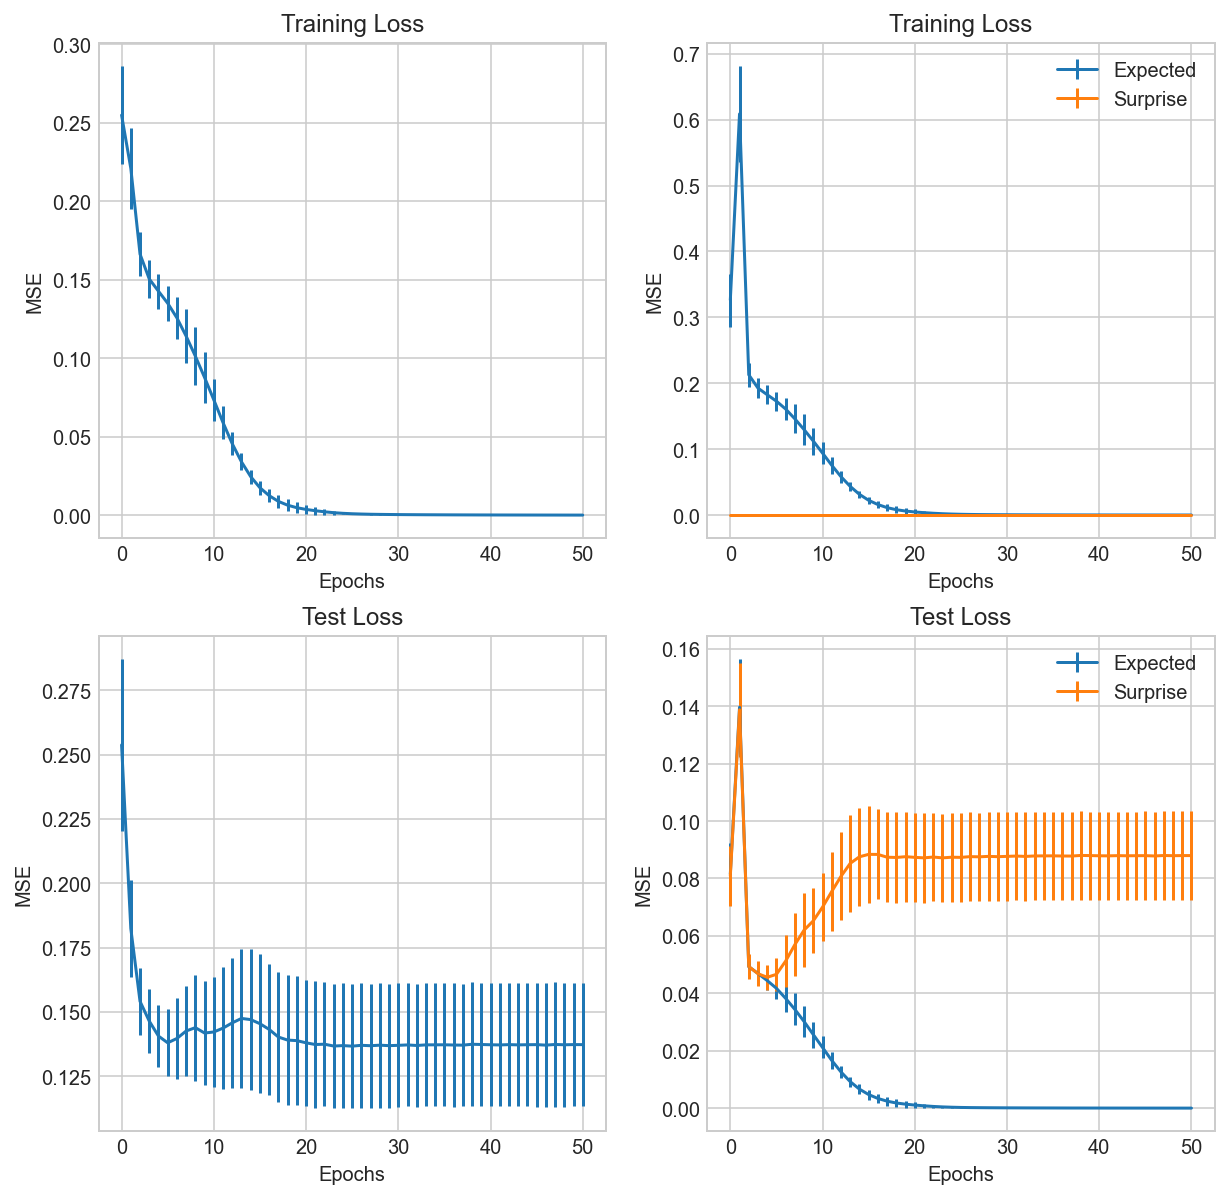

In [48]:
f = plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.errorbar(np.arange(n_epochs+1),train_losses_mean,yerr=train_losses_std)
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')

plt.subplot(2,2,2)
plt.errorbar(np.arange(n_epochs+1),train_expected_losses_mean,yerr=train_expected_losses_std,label='Expected')
plt.errorbar(np.arange(n_epochs+1),train_surprise_losses_mean,yerr=train_surprise_losses_std,label='Surprise')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

plt.subplot(2,2,3)
plt.errorbar(np.arange(n_epochs+1),test_losses_mean,yerr=test_losses_std)
plt.title('Test Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')

plt.subplot(2,2,4)
plt.errorbar(np.arange(n_epochs+1),test_expected_losses_mean,yerr=test_expected_losses_std,label='Expected')
plt.errorbar(np.arange(n_epochs+1),test_surprise_losses_mean,yerr=test_surprise_losses_std,label='Surprise')
plt.title('Test Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

plt.show()

In [49]:
f.savefig('training-testing-error-no-fb.png',dpi=300)

### Representational analyses

#### Load clean and surprise sequences

In [29]:
cleanSeqs = cleanSequences
surpSeqs = surpSequences

In [30]:
yCleanSeqs = yCleanSequences
ySurpSeqs = ySurpSequences

In [31]:
eClean = np.array([2,1,2,0,1,0])
pClean = np.ones(nStates_surp,dtype=int)*(-1)
surpClean = np.zeros(nStates_surp,dtype=int)

In [32]:
eSurp = np.array([1,2,0,2,0,1])
pSurp = np.ones(nStates_surp,dtype=int)*2
surpSurp = np.ones(nStates_surp,dtype=int)

#### RNN names

In [33]:
rnn_names = ['L4','L23','L56','H4','H23','H56']

#### Re-initialize models with new batch size

In [34]:
batch_size_analyses = nStates_surp

In [35]:
model = {}

for cntr in range(nRuns):
    model[cntr] = microcircuit(hidden_dim=n_latent,bsize=batch_size_analyses,manual_seed=seeds[cntr])
    model[cntr].to(device)

In [36]:
train_loader_analyses = {}
test_loader_analyses = {}

for cntr in range(nRuns):
    train_loader_analyses[cntr] = makeTensorLoaders((cleanSeqs[cntr],yCleanSeqs[cntr],
                                                     eClean,pClean,surpClean),batch_size_analyses,shuffle=False)
    test_loader_analyses[cntr] = makeTensorLoaders((surpSeqs[cntr],ySurpSeqs[cntr],
                                                    eSurp,pSurp,surpSurp),batch_size_analyses,shuffle=False)

#### Pass data through models and store activations

In [37]:
cleanMSE = {}
surpMSE = {}

cleanLosses_exp = {}
cleanLosses_surp = {}

surpLosses_exp = {}
surpLosses_surp = {}

In [38]:
activations_hidden_L23C_np = {}
activations_hidden_L4C_np = {}
activations_hidden_L56C_np = {}

activations_hidden_H23C_np = {}
activations_hidden_H4C_np = {}
activations_hidden_H56C_np = {}

activations_FFC_np = {}
# activations_FBaC_np = {}
# activations_FBbC_np = {}

activations_outC_np = {}

In [39]:
activations_hidden_L23S_np = {}
activations_hidden_L4S_np = {}
activations_hidden_L56S_np = {}

activations_hidden_H23S_np = {}
activations_hidden_H4S_np = {}
activations_hidden_H56S_np = {}

activations_FFS_np = {}
# activations_FBaS_np = {}
# activations_FBbS_np = {}

activations_outS_np = {}

In [40]:
for cntr in range(nRuns):
    cleanMSE[cntr] = np.zeros(n_epochs+1)
    surpMSE[cntr] = np.zeros(n_epochs+1)
    
    cleanLosses_exp[cntr] = np.zeros(n_epochs+1)
    cleanLosses_surp[cntr] = np.zeros(n_epochs+1)

    surpLosses_exp[cntr] = np.zeros(n_epochs+1)
    surpLosses_surp[cntr] = np.zeros(n_epochs+1)
    
    activations_hidden_L23C_np[cntr] = np.zeros((n_epochs+1,nStates_surp,nSteps,pop_list[1]*n_latent))
    activations_hidden_L4C_np[cntr] = np.zeros((n_epochs+1,nStates_surp,nSteps,pop_list[0]*n_latent))
    activations_hidden_L56C_np[cntr] = np.zeros((n_epochs+1,nStates_surp,nSteps,pop_list[2]*n_latent))

    activations_hidden_H23C_np[cntr] = np.zeros((n_epochs+1,nStates_surp,nSteps,pop_list[1]*n_latent))
    activations_hidden_H4C_np[cntr] = np.zeros((n_epochs+1,nStates_surp,nSteps,pop_list[0]*n_latent))
    activations_hidden_H56C_np[cntr] = np.zeros((n_epochs+1,nStates_surp,nSteps,pop_list[2]*n_latent))

    activations_FFC_np[cntr] = np.zeros((n_epochs+1,nStates_surp,nSteps,pop_list[0]*n_latent))
#     activations_FBaC_np[cntr] = np.zeros((n_epochs+1,nStates_surp,nSteps,pop_list[1]*n_latent))
#     activations_FBbC_np[cntr] = np.zeros((n_epochs+1,nStates_surp,nSteps,pop_list[2]*n_latent))

    activations_outC_np[cntr] = np.zeros((n_epochs+1,nStates_surp,nSteps,dim))
    
    activations_hidden_L23S_np[cntr] = np.zeros((n_epochs+1,nStates_surp,nSteps,pop_list[1]*n_latent))
    activations_hidden_L4S_np[cntr] = np.zeros((n_epochs+1,nStates_surp,nSteps,pop_list[0]*n_latent))
    activations_hidden_L56S_np[cntr] = np.zeros((n_epochs+1,nStates_surp,nSteps,pop_list[2]*n_latent))

    activations_hidden_H23S_np[cntr] = np.zeros((n_epochs+1,nStates_surp,nSteps,pop_list[1]*n_latent))
    activations_hidden_H4S_np[cntr] = np.zeros((n_epochs+1,nStates_surp,nSteps,pop_list[0]*n_latent))
    activations_hidden_H56S_np[cntr] = np.zeros((n_epochs+1,nStates_surp,nSteps,pop_list[2]*n_latent))

    activations_FFS_np[cntr] = np.zeros((n_epochs+1,nStates_surp,nSteps,pop_list[0]*n_latent))
#     activations_FBaS_np[cntr] = np.zeros((n_epochs+1,nStates_surp,nSteps,pop_list[1]*n_latent))
#     activations_FBbS_np[cntr] = np.zeros((n_epochs+1,nStates_surp,nSteps,pop_list[2]*n_latent))

    activations_outS_np[cntr] = np.zeros((n_epochs+1,nStates_surp,nSteps,dim))

In [41]:
for cntr in range(nRuns):
    
    for e in tqdm(range(n_epochs+1)):

        cntC = 0
        cntS = 0

        ## Load model
        model[cntr] = microcircuit(hidden_dim=n_latent,bsize=batch_size_analyses,manual_seed=seeds[cntr])
        model[cntr].to(device)
        model[cntr].load_state_dict(torch.load(pp_pts[cntr]+'predRNN_epoch_'+str(e)+'.pt'))
        model[cntr].eval()

        ## Pass clean samples
        for dataC, f_targetC, lastEventC, surprisePositionC, surpriseBinaryC in train_loader_analyses[cntr]:

            if train_on_gpu:
                dataC, f_targetC = dataC.float().cuda(), f_targetC.float().cuda()
            else: dataC, f_targetC = dataC.float(), f_targetC.float()

            targetC = f_targetC

            output_predC, RNN_outputsC, feedbackDiffsC, projInterAreaC = model[cntr](dataC)
            lossC = reconLoss(output_predC[:,2:],targetC[:,2:])

            cleanMSE[cntr][e] += lossC.item()*dataC.size(0) #update loss

            errC = torch.linalg.norm((output_predC[:,2:]-targetC[:,2:]),dim=2)
            errSqC = errC**2
            MSE_mat_samples_seqC = errSqC/np.prod(errSqC.shape)
            MSE_samplesC = torch.mean(MSE_mat_samples_seqC,1)
            cleanLosses_exp[cntr][e] += torch.mean(MSE_samplesC[torch.where(surpriseBinaryC==0)[0]])
            if (len(torch.where(surpriseBinaryC==1)[0])>0):
                cleanLosses_surp[cntr][e] += torch.mean(MSE_samplesC[torch.where(surpriseBinaryC==1)[0]])

            ## Collect activations  
            act_hidden_L23C = np.squeeze(RNN_outputsC[0].detach().cpu().numpy())
            act_hidden_L4C = np.squeeze(RNN_outputsC[1].detach().cpu().numpy())
            act_hidden_L56C = np.squeeze(RNN_outputsC[2].detach().cpu().numpy())

            act_hidden_H23C = np.squeeze(RNN_outputsC[3].detach().cpu().numpy())
            act_hidden_H4C = np.squeeze(RNN_outputsC[4].detach().cpu().numpy())
            act_hidden_H56C = np.squeeze(RNN_outputsC[5].detach().cpu().numpy())

            act_FFC = np.squeeze(projInterAreaC.detach().cpu().numpy())
#             act_FBaC = np.squeeze(projInterAreaC[1].detach().cpu().numpy()) 
#             act_FBbC = np.squeeze(projInterAreaC[2].detach().cpu().numpy())

            output_predC = np.squeeze(output_predC.detach().cpu().numpy())

            for i in range(batch_size_analyses):
                if i < len(dataC):
                    label = targetC.data[i]

                    activations_hidden_L23C_np[cntr][e,cntC] = act_hidden_L23C[i]
                    activations_hidden_L4C_np[cntr][e,cntC] = act_hidden_L4C[i]
                    activations_hidden_L56C_np[cntr][e,cntC] = act_hidden_L56C[i]

                    activations_hidden_H23C_np[cntr][e,cntC] = act_hidden_H23C[i]
                    activations_hidden_H4C_np[cntr][e,cntC] = act_hidden_H4C[i]
                    activations_hidden_H56C_np[cntr][e,cntC] = act_hidden_H56C[i]

                    activations_FFC_np[cntr][e,cntC] = act_FFC[i]
#                     activations_FBaC_np[cntr][e,cntC] = act_FBaC[i]
#                     activations_FBbC_np[cntr][e,cntC] = act_FBbC[i]

                    activations_outC_np[cntr][e,cntC] = output_predC[i]

                    cntC += 1

        #calculate average loss
        cleanMSE[cntr][e] = cleanMSE[cntr][e]/len(train_loader_analyses[cntr].dataset)

        ## Pass surprise samples
        for dataS, f_targetS, lastEventS, surprisePositionS, surpriseBinaryS in test_loader_analyses[cntr]:

            if train_on_gpu:
                dataS, f_targetS = dataS.float().cuda(), f_targetS.float().cuda()
            else: dataS, f_targetS = dataS.float(), f_targetS.float()

            targetS = f_targetS

            output_predS, RNN_outputsS, feedbackDiffsS, projInterAreaS = model[cntr](dataS)
            lossS = reconLoss(output_predS[:,2:],targetS[:,2:])

            surpMSE[cntr][e] += lossS.item()*dataS.size(0) #update loss

            errS = torch.linalg.norm((output_predS[:,2:]-targetS[:,2:]),dim=2)
            errSqS = errC**2
            MSE_mat_samples_seqS = errSqS/np.prod(errSqS.shape)
            MSE_samplesS = torch.mean(MSE_mat_samples_seqS,1)
            surpLosses_exp[cntr][e] += torch.mean(MSE_samplesS[torch.where(surpriseBinaryS==0)[0]])
            if (len(torch.where(surpriseBinaryS==1)[0])>0):
                surpLosses_surp[cntr][e] += torch.mean(MSE_samplesS[torch.where(surpriseBinaryS==1)[0]])

            ## Collect activations  
            act_hidden_L23S = np.squeeze(RNN_outputsS[0].detach().cpu().numpy())
            act_hidden_L4S = np.squeeze(RNN_outputsS[1].detach().cpu().numpy())
            act_hidden_L56S = np.squeeze(RNN_outputsS[2].detach().cpu().numpy())

            act_hidden_H23S = np.squeeze(RNN_outputsS[3].detach().cpu().numpy())
            act_hidden_H4S = np.squeeze(RNN_outputsS[4].detach().cpu().numpy())
            act_hidden_H56S = np.squeeze(RNN_outputsS[5].detach().cpu().numpy())

            act_FFS = np.squeeze(projInterAreaS.detach().cpu().numpy())
#             act_FBaS = np.squeeze(projInterAreaS[1].detach().cpu().numpy()) 
#             act_FBbS = np.squeeze(projInterAreaS[2].detach().cpu().numpy())

            output_predS = np.squeeze(output_predS.detach().cpu().numpy())

            for i in range(batch_size):
                if i < len(dataS):
                    labelS = targetS.data[i]

                    activations_hidden_L23S_np[cntr][e,cntS] = act_hidden_L23S[i]
                    activations_hidden_L4S_np[cntr][e,cntS] = act_hidden_L4S[i]
                    activations_hidden_L56S_np[cntr][e,cntS] = act_hidden_L56S[i]

                    activations_hidden_H23S_np[cntr][e,cntS] = act_hidden_H23S[i]
                    activations_hidden_H4S_np[cntr][e,cntS] = act_hidden_H4S[i]
                    activations_hidden_H56S_np[cntr][e,cntS] = act_hidden_H56S[i]

                    activations_FFS_np[cntr][e,cntS] = act_FFS[i]
#                     activations_FBaS_np[cntr][e,cntS] = act_FBaS[i]
#                     activations_FBbS_np[cntr][e,cntS] = act_FBbS[i]

                    activations_outS_np[cntr][e,cntS] = output_predS[i]

                    cntS += 1

        #calculate average loss
        surpMSE[cntr][e] = surpMSE[cntr][e]/len(test_loader_analyses[cntr].dataset)

100%|██████████| 51/51 [00:02<00:00, 18.94it/s]


#### Image ID matrices

In [63]:
imgID_mtxC = np.zeros((nStates_surp,lenSeq*nRepeats),dtype=int)
imgID_mtxS = np.zeros((nStates_surp,lenSeq*nRepeats),dtype=int)

all_perm_list = list(permutations(np.arange(nStates_reg)))

for jj in range(nStates_surp):
    imgID_mtxC[jj,:-2:2] = all_perm_list[jj]
    imgID_mtxC[jj,1:-2:2] = all_perm_list[jj]
    
    imgID_mtxS[jj,:-2:2] = all_perm_list[jj]
    imgID_mtxS[jj,1:-2:2] = all_perm_list[jj]
    
    imgID_mtxS[jj,-4:-2] = imgID_mtxS[jj,2:4]
    
    imgID_mtxC[jj,-2:] = jj+nStates_reg
    imgID_mtxS[jj,-2:] = jj+nStates_reg

#### Label Matrices

In [64]:
labelNames = ['inputID','outputID','seqID','inputSurpBinary', 'outputSurpBinary','seqPosition',
              ' inputSurpType', 'outputSurpType','timestep']

In [65]:
## Initialize appropriately sized label matrices

labelMtxC = np.zeros((nStates_surp*nSteps,len(labelNames)),dtype=int)
labelMtxS = np.zeros((nStates_surp*nSteps,len(labelNames)),dtype=int)

In [66]:
labelMtxC[:,0] = np.repeat(imgID_mtxC[:,0:-2:2].ravel(),nRepeats)
labelMtxS[:,0] = np.repeat(imgID_mtxS[:,0:-2:2].ravel(),nRepeats)

labelMtxC[:,1] = np.repeat(imgID_mtxC[:,2::2].ravel(),nRepeats)
labelMtxS[:,1] = np.repeat(imgID_mtxS[:,2::2].ravel(),nRepeats)

labelMtxC[:,2] = np.repeat(imgID_mtxC[:,-1],nSteps)
labelMtxS[:,2] = np.repeat(imgID_mtxS[:,-1],nSteps)

ii = np.zeros(nSteps,dtype=int)
ii[-nRepeats:]=1
ii = np.tile(ii,nStates_surp)

labelMtxS[:,3] = ii

oo = np.ones(nSteps,dtype=int)
oo[:nRepeats]=0
oo = np.tile(oo,nStates_surp)

labelMtxS[:,4] = oo

labelMtxC[:,5] = np.tile(np.repeat(np.array([0,1,2]),nRepeats),nStates_surp)
labelMtxS[:,5] = np.tile(np.repeat(np.array([0,1,2]),nRepeats),nStates_surp)

In [67]:
labelMtxS[:,6] = labelMtxS[:,3]
labelMtxS[:,7] = labelMtxS[:,5]

In [68]:
labelMtxC[:,8] = np.array([x%nSteps for x in range(nStates_surp*nSteps)])
labelMtxS[:,8] = np.array([x%nSteps for x in range(nStates_surp*nSteps)])

0 = inputID = image being fed as input <br>
1 = outputID = image to be predicted at output <br>
2 = seqID = last element of the sequence (sequence label) <br>
3 = inputSurpBinary = if image being fed is any kind of surprise <br>
4 = outputSurpBinary = if image being predicted is any kind of surprise <br>
5 = seqPosition = which element of the sequence is being processed <br>

#### PCA for RNNs

In [69]:
def repsPCA(rnnActs):
    nEpochs, nSeqs, nRolls, nNeurons = rnnActs.shape
    pca_dict = {}
    nSamps = nSeqs*nRolls
    dimPCA = min(nNeurons,nSamps)
    repsR_transformed = np.zeros((nEpochs,nSamps,dimPCA))
    
    for ep in tqdm(range(nEpochs)):
        
        reps = rnnActs[ep]
        
        ## reshape
        repsR = np.zeros((nSeqs*nRolls,nNeurons))
        cnt = 0
        for ii in range(nSeqs):
            for jj in range(nRolls):
                repsR[cnt] = reps[ii,jj]
                cnt += 1
        ## PCA
        rnnPCA = PCA()
        repsR_transformed[ep] = rnnPCA.fit_transform(repsR)
        pca_dict[str(ep)] = rnnPCA
        
    return repsR_transformed, pca_dict

In [70]:
L23pcaC = {}
L4pcaC = {}
L56pcaC = {}

H23pcaC = {}
H4pcaC = {}
H56pcaC = {}

L23pcaS = {}
L4pcaS = {}
L56pcaS = {}

H23pcaS = {}
H4pcaS = {}
H56pcaS = {}

In [71]:
for cntr in range(nRuns):
    L23pcaC[cntr], _ = repsPCA(activations_hidden_L23C_np[cntr])
    L4pcaC[cntr], _ = repsPCA(activations_hidden_L4C_np[cntr])
    L56pcaC[cntr], _ = repsPCA(activations_hidden_L56C_np[cntr])

    H23pcaC[cntr], _ = repsPCA(activations_hidden_H23C_np[cntr])
    H4pcaC[cntr], _ = repsPCA(activations_hidden_H4C_np[cntr])
    H56pcaC[cntr], _ = repsPCA(activations_hidden_H56C_np[cntr])

100%|██████████| 51/51 [00:00<00:00, 1019.99it/s]


In [72]:
for cntr in range(nRuns):
    L23pcaS[cntr], _ = repsPCA(activations_hidden_L23S_np[cntr])
    L4pcaS[cntr], _ = repsPCA(activations_hidden_L4S_np[cntr])
    L56pcaS[cntr], _ = repsPCA(activations_hidden_L56S_np[cntr])

    H23pcaS[cntr], _ = repsPCA(activations_hidden_H23S_np[cntr])
    H4pcaS[cntr], _ = repsPCA(activations_hidden_H4S_np[cntr])
    H56pcaS[cntr], _ = repsPCA(activations_hidden_H56S_np[cntr])

100%|██████████| 51/51 [00:00<00:00, 944.30it/s]


#### Subset indices, etc.

In [73]:
idxs2 = np.array([4,5,10,11,16,17,22,23,28,29,34,35])
idxs0 = idxs2 - 4
idxs1 = idxs2 - 2

In [74]:
exp0s = np.array([22,23,34,35])
exp1s = np.array([10,11,28,29])
exp2s = np.array([4,5,16,17])

In [75]:
surp0s = np.array([16,17,28,29])
surp1s = np.array([4,5,34,35])
surp2s = np.array([10,11,22,23])

In [76]:
cleanPCs = {}
surpPCs = {}

contextPCs_sub = {}

In [77]:
for cntr in range(nRuns):
    cleanPCs[cntr] = (L4pcaC[cntr],L23pcaC[cntr],L56pcaC[cntr],H4pcaC[cntr],H23pcaC[cntr],H56pcaC[cntr])
    surpPCs[cntr] = (L4pcaS[cntr],L23pcaS[cntr],L56pcaS[cntr],H4pcaS[cntr],H23pcaS[cntr],H56pcaS[cntr])
    
    for rnnNo in range(len(rnn_names)):
        contextPCs_sub[cntr,rnnNo] = np.hstack((cleanPCs[cntr][rnnNo][:,idxs2,:],surpPCs[cntr][rnnNo][:,idxs2,:]))

In [78]:
context_sub_imgIDs = np.array([2,2,1,1,2,2,0,0,1,1,0,0,1,1,2,2,0,0,2,2,0,0,1,1])
context_sub_surp = np.array([0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1])

#### Context plots

In [79]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [80]:
legend_elements = [Line2D([0], [0], marker='o', color='r', label='Expected As'),
                   Line2D([0], [0], marker='o', color='g', label='Expected Bs'),
                   Line2D([0], [0], marker='o', color='b', label='Expected Cs'),
                   Line2D([0], [0], marker='x', color='r', label='Surprise As'),
                   Line2D([0], [0], marker='x', color='g', label='Surprise Bs'),
                   Line2D([0], [0], marker='x', color='b', label='Surprise Cs')]
# Create the figure
# fig, ax = plt.subplots()
# plt.legend(handles=legend_elements, loc='best')
# plt.show()

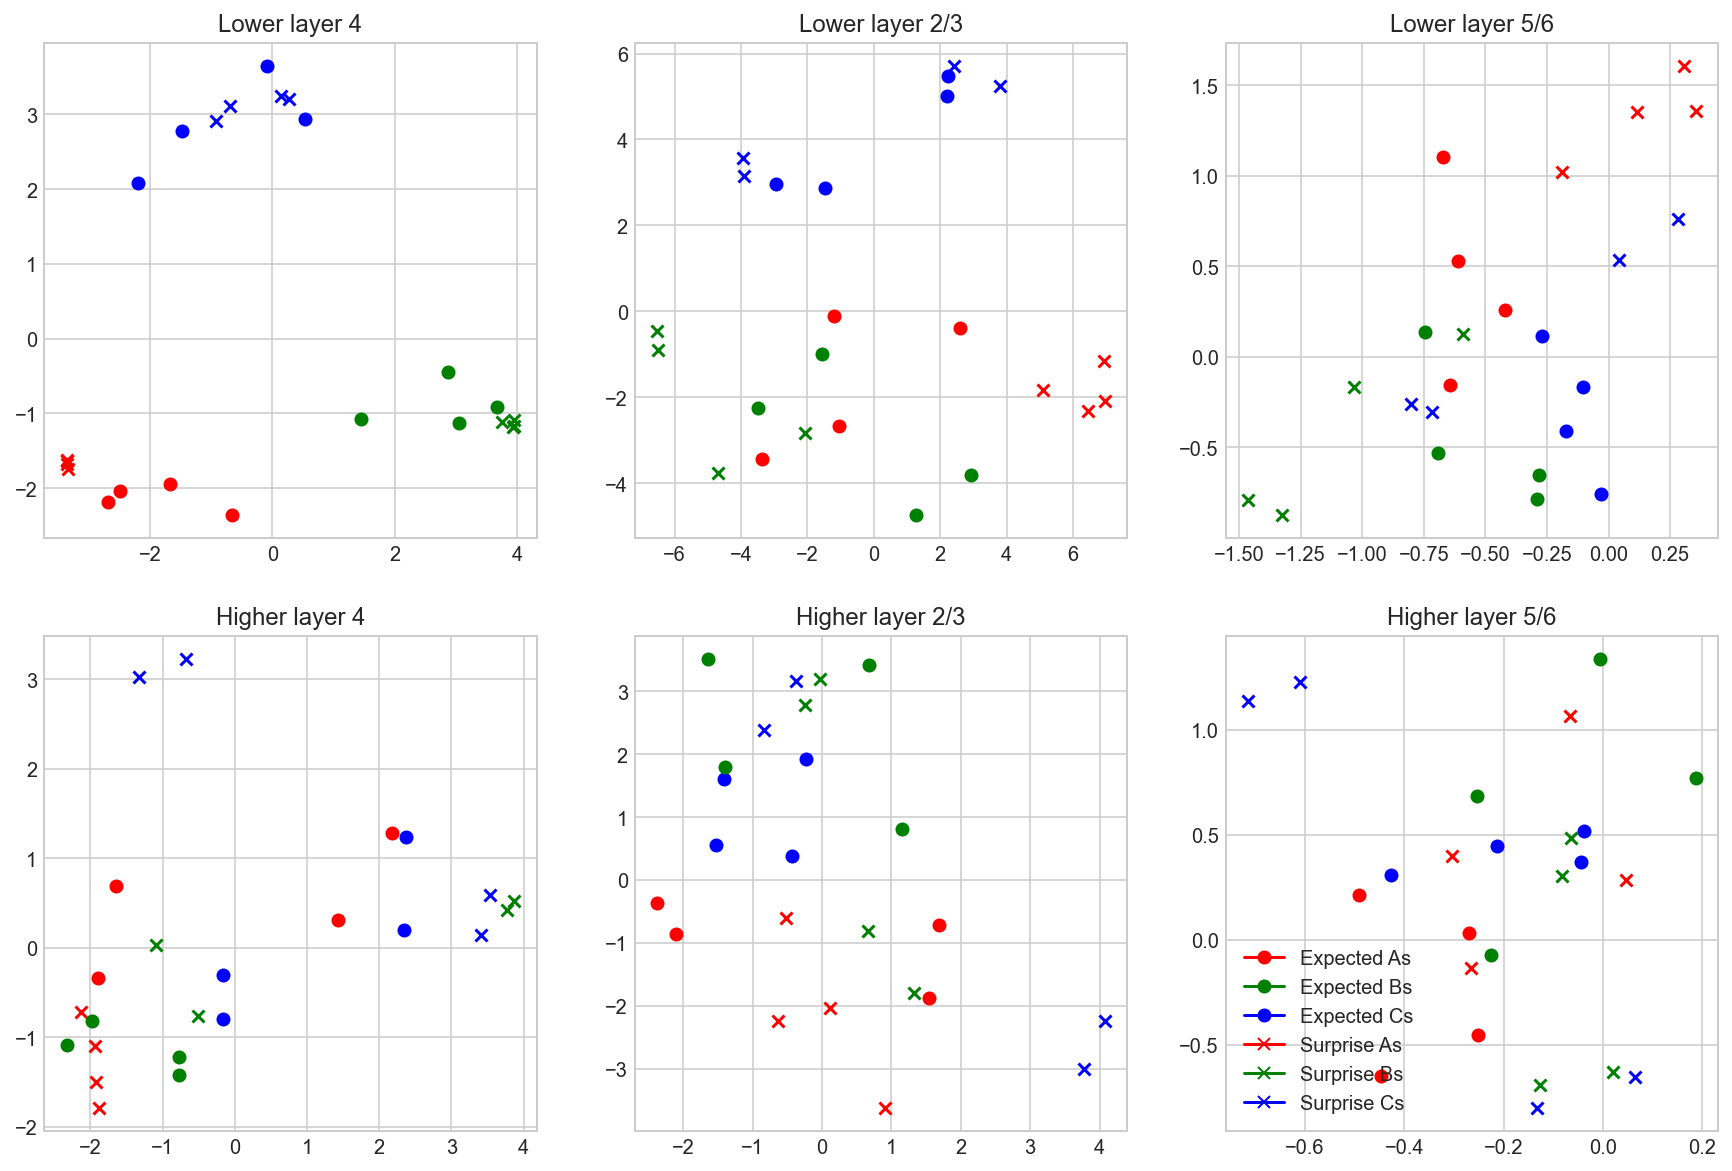

In [81]:
kkk = 4
e = -1

ff, axs = plt.subplots(2,3,figsize=(15,10))

for ii in range(len(exp0s)):
    axs[0,0].scatter(cleanPCs[kkk][0][e,exp0s[ii],0],cleanPCs[kkk][0][e,exp0s[ii],1],c='r',marker='o')
    axs[0,0].scatter(cleanPCs[kkk][0][e,exp1s[ii],0],cleanPCs[kkk][0][e,exp1s[ii],1],c='g',marker='o')
    axs[0,0].scatter(cleanPCs[kkk][0][e,exp2s[ii],0],cleanPCs[kkk][0][e,exp2s[ii],1],c='b',marker='o')
    
    axs[0,0].scatter(surpPCs[kkk][0][e,surp0s[ii],0],surpPCs[kkk][0][e,surp0s[ii],1],c='r',marker='x')
    axs[0,0].scatter(surpPCs[kkk][0][e,surp1s[ii],0],surpPCs[kkk][0][e,surp1s[ii],1],c='g',marker='x')
    axs[0,0].scatter(surpPCs[kkk][0][e,surp2s[ii],0],surpPCs[kkk][0][e,surp2s[ii],1],c='b',marker='x')
    axs[0,0].set_title('Lower layer 4')
    
for ii in range(len(exp0s)):
    axs[0,1].scatter(cleanPCs[kkk][1][e,exp0s[ii],0],cleanPCs[kkk][1][e,exp0s[ii],1],c='r',marker='o')
    axs[0,1].scatter(cleanPCs[kkk][1][e,exp1s[ii],0],cleanPCs[kkk][1][e,exp1s[ii],1],c='g',marker='o')
    axs[0,1].scatter(cleanPCs[kkk][1][e,exp2s[ii],0],cleanPCs[kkk][1][e,exp2s[ii],1],c='b',marker='o')
    
    axs[0,1].scatter(surpPCs[kkk][1][e,surp0s[ii],0],surpPCs[kkk][1][e,surp0s[ii],1],c='r',marker='x')
    axs[0,1].scatter(surpPCs[kkk][1][e,surp1s[ii],0],surpPCs[kkk][1][e,surp1s[ii],1],c='g',marker='x')
    axs[0,1].scatter(surpPCs[kkk][1][e,surp2s[ii],0],surpPCs[kkk][1][e,surp2s[ii],1],c='b',marker='x')
    axs[0,1].set_title('Lower layer 2/3')
    
for ii in range(len(exp0s)):
    axs[0,2].scatter(cleanPCs[kkk][2][e,exp0s[ii],0],cleanPCs[kkk][2][e,exp0s[ii],1],c='r',marker='o')
    axs[0,2].scatter(cleanPCs[kkk][2][e,exp1s[ii],0],cleanPCs[kkk][2][e,exp1s[ii],1],c='g',marker='o')
    axs[0,2].scatter(cleanPCs[kkk][2][e,exp2s[ii],0],cleanPCs[kkk][2][e,exp2s[ii],1],c='b',marker='o')
    
    axs[0,2].scatter(surpPCs[kkk][2][e,surp0s[ii],0],surpPCs[kkk][2][e,surp0s[ii],1],c='r',marker='x')
    axs[0,2].scatter(surpPCs[kkk][2][e,surp1s[ii],0],surpPCs[kkk][2][e,surp1s[ii],1],c='g',marker='x')
    axs[0,2].scatter(surpPCs[kkk][2][e,surp2s[ii],0],surpPCs[kkk][2][e,surp2s[ii],1],c='b',marker='x')
    axs[0,2].set_title('Lower layer 5/6')
    
for ii in range(len(exp0s)):
    axs[1,0].scatter(cleanPCs[kkk][3][e,exp0s[ii],0],cleanPCs[kkk][3][e,exp0s[ii],1],c='r',marker='o')
    axs[1,0].scatter(cleanPCs[kkk][3][e,exp1s[ii],0],cleanPCs[kkk][3][e,exp1s[ii],1],c='g',marker='o')
    axs[1,0].scatter(cleanPCs[kkk][3][e,exp2s[ii],0],cleanPCs[kkk][3][e,exp2s[ii],1],c='b',marker='o')
    
    axs[1,0].scatter(surpPCs[kkk][3][e,surp0s[ii],0],surpPCs[kkk][3][e,surp0s[ii],1],c='r',marker='x')
    axs[1,0].scatter(surpPCs[kkk][3][e,surp1s[ii],0],surpPCs[kkk][3][e,surp1s[ii],1],c='g',marker='x')
    axs[1,0].scatter(surpPCs[kkk][3][e,surp2s[ii],0],surpPCs[kkk][3][e,surp2s[ii],1],c='b',marker='x')
    axs[1,0].set_title('Higher layer 4')
    
for ii in range(len(exp0s)):
    axs[1,1].scatter(cleanPCs[kkk][4][e,exp0s[ii],0],cleanPCs[kkk][4][e,exp0s[ii],1],c='r',marker='o')
    axs[1,1].scatter(cleanPCs[kkk][4][e,exp1s[ii],0],cleanPCs[kkk][4][e,exp1s[ii],1],c='g',marker='o')
    axs[1,1].scatter(cleanPCs[kkk][4][e,exp2s[ii],0],cleanPCs[kkk][4][e,exp2s[ii],1],c='b',marker='o')
    
    axs[1,1].scatter(surpPCs[kkk][4][e,surp0s[ii],0],surpPCs[kkk][4][e,surp0s[ii],1],c='r',marker='x')
    axs[1,1].scatter(surpPCs[kkk][4][e,surp1s[ii],0],surpPCs[kkk][4][e,surp1s[ii],1],c='g',marker='x')
    axs[1,1].scatter(surpPCs[kkk][4][e,surp2s[ii],0],surpPCs[kkk][4][e,surp2s[ii],1],c='b',marker='x')
    axs[1,1].set_title('Higher layer 2/3')
    
for ii in range(len(exp0s)):
    axs[1,2].scatter(cleanPCs[kkk][5][e,exp0s[ii],0],cleanPCs[kkk][5][e,exp0s[ii],1],c='r',marker='o')
    axs[1,2].scatter(cleanPCs[kkk][5][e,exp1s[ii],0],cleanPCs[kkk][5][e,exp1s[ii],1],c='g',marker='o')
    axs[1,2].scatter(cleanPCs[kkk][5][e,exp2s[ii],0],cleanPCs[kkk][5][e,exp2s[ii],1],c='b',marker='o')
    
    axs[1,2].scatter(surpPCs[kkk][5][e,surp0s[ii],0],surpPCs[kkk][5][e,surp0s[ii],1],c='r',marker='x')
    axs[1,2].scatter(surpPCs[kkk][5][e,surp1s[ii],0],surpPCs[kkk][5][e,surp1s[ii],1],c='g',marker='x')
    axs[1,2].scatter(surpPCs[kkk][5][e,surp2s[ii],0],surpPCs[kkk][5][e,surp2s[ii],1],c='b',marker='x')
    axs[1,2].set_title('Higher layer 5/6')
plt.legend(handles=legend_elements, loc='best')
plt.show()

In [82]:
ff.savefig('example-no-fb-pc-plots.png',dpi=300)

In [83]:
# kkk = 4
# e = 0

# ff, axs = plt.subplots(2,3,figsize=(15,10))

# for ii in range(len(exp0s)):
#     axs[0,0].scatter(cleanPCs[kkk][0][e,exp0s[ii],0],cleanPCs[kkk][0][e,exp0s[ii],0],c='r',marker='o')
#     axs[0,0].scatter(cleanPCs[kkk][0][e,exp1s[ii],0],cleanPCs[kkk][0][e,exp1s[ii],0],c='g',marker='o')
#     axs[0,0].scatter(cleanPCs[kkk][0][e,exp2s[ii],0],cleanPCs[kkk][0][e,exp2s[ii],0],c='b',marker='o')
    
#     axs[0,0].scatter(surpPCs[kkk][0][e,surp0s[ii],0],surpPCs[kkk][0][e,surp0s[ii],0],c='r',marker='x')
#     axs[0,0].scatter(surpPCs[kkk][0][e,surp1s[ii],0],surpPCs[kkk][0][e,surp1s[ii],0],c='g',marker='x')
#     axs[0,0].scatter(surpPCs[kkk][0][e,surp2s[ii],0],surpPCs[kkk][0][e,surp2s[ii],0],c='b',marker='x')
#     axs[0,0].set_title('L4')
    
# for ii in range(len(exp0s)):
#     axs[0,1].scatter(cleanPCs[kkk][1][e,exp0s[ii],0],cleanPCs[kkk][1][e,exp0s[ii],0],c='r',marker='o')
#     axs[0,1].scatter(cleanPCs[kkk][1][e,exp1s[ii],0],cleanPCs[kkk][1][e,exp1s[ii],0],c='g',marker='o')
#     axs[0,1].scatter(cleanPCs[kkk][1][e,exp2s[ii],0],cleanPCs[kkk][1][e,exp2s[ii],0],c='b',marker='o')
    
#     axs[0,1].scatter(surpPCs[kkk][1][e,surp0s[ii],0],surpPCs[kkk][1][e,surp0s[ii],0],c='r',marker='x')
#     axs[0,1].scatter(surpPCs[kkk][1][e,surp1s[ii],0],surpPCs[kkk][1][e,surp1s[ii],0],c='g',marker='x')
#     axs[0,1].scatter(surpPCs[kkk][1][e,surp2s[ii],0],surpPCs[kkk][1][e,surp2s[ii],0],c='b',marker='x')
#     axs[0,1].set_title('L2/3')
    
# for ii in range(len(exp0s)):
#     axs[0,2].scatter(cleanPCs[kkk][2][e,exp0s[ii],0],cleanPCs[kkk][2][e,exp0s[ii],0],c='r',marker='o')
#     axs[0,2].scatter(cleanPCs[kkk][2][e,exp1s[ii],0],cleanPCs[kkk][2][e,exp1s[ii],0],c='g',marker='o')
#     axs[0,2].scatter(cleanPCs[kkk][2][e,exp2s[ii],0],cleanPCs[kkk][2][e,exp2s[ii],0],c='b',marker='o')
    
#     axs[0,2].scatter(surpPCs[kkk][2][e,surp0s[ii],0],surpPCs[kkk][2][e,surp0s[ii],0],c='r',marker='x')
#     axs[0,2].scatter(surpPCs[kkk][2][e,surp1s[ii],0],surpPCs[kkk][2][e,surp1s[ii],0],c='g',marker='x')
#     axs[0,2].scatter(surpPCs[kkk][2][e,surp2s[ii],0],surpPCs[kkk][2][e,surp2s[ii],0],c='b',marker='x')
#     axs[0,2].set_title('L5/6')
    
# for ii in range(len(exp0s)):
#     axs[1,0].scatter(cleanPCs[kkk][3][e,exp0s[ii],0],cleanPCs[kkk][3][e,exp0s[ii],0],c='r',marker='o')
#     axs[1,0].scatter(cleanPCs[kkk][3][e,exp1s[ii],0],cleanPCs[kkk][3][e,exp1s[ii],0],c='g',marker='o')
#     axs[1,0].scatter(cleanPCs[kkk][3][e,exp2s[ii],0],cleanPCs[kkk][3][e,exp2s[ii],0],c='b',marker='o')
    
#     axs[1,0].scatter(surpPCs[kkk][3][e,surp0s[ii],0],surpPCs[kkk][3][e,surp0s[ii],0],c='r',marker='x')
#     axs[1,0].scatter(surpPCs[kkk][3][e,surp1s[ii],0],surpPCs[kkk][3][e,surp1s[ii],0],c='g',marker='x')
#     axs[1,0].scatter(surpPCs[kkk][3][e,surp2s[ii],0],surpPCs[kkk][3][e,surp2s[ii],0],c='b',marker='x')
#     axs[1,0].set_title('H4')
    
# for ii in range(len(exp0s)):
#     axs[1,1].scatter(cleanPCs[kkk][4][e,exp0s[ii],0],cleanPCs[kkk][4][e,exp0s[ii],0],c='r',marker='o')
#     axs[1,1].scatter(cleanPCs[kkk][4][e,exp1s[ii],0],cleanPCs[kkk][4][e,exp1s[ii],0],c='g',marker='o')
#     axs[1,1].scatter(cleanPCs[kkk][4][e,exp2s[ii],0],cleanPCs[kkk][4][e,exp2s[ii],0],c='b',marker='o')
    
#     axs[1,1].scatter(surpPCs[kkk][4][e,surp0s[ii],0],surpPCs[kkk][4][e,surp0s[ii],0],c='r',marker='x')
#     axs[1,1].scatter(surpPCs[kkk][4][e,surp1s[ii],0],surpPCs[kkk][4][e,surp1s[ii],0],c='g',marker='x')
#     axs[1,1].scatter(surpPCs[kkk][4][e,surp2s[ii],0],surpPCs[kkk][4][e,surp2s[ii],0],c='b',marker='x')
#     axs[1,1].set_title('H2/3')
    
# for ii in range(len(exp0s)):
#     axs[1,2].scatter(cleanPCs[kkk][5][e,exp0s[ii],0],cleanPCs[kkk][5][e,exp0s[ii],0],c='r',marker='o')
#     axs[1,2].scatter(cleanPCs[kkk][5][e,exp1s[ii],0],cleanPCs[kkk][5][e,exp1s[ii],0],c='g',marker='o')
#     axs[1,2].scatter(cleanPCs[kkk][5][e,exp2s[ii],0],cleanPCs[kkk][5][e,exp2s[ii],0],c='b',marker='o')
    
#     axs[1,2].scatter(surpPCs[kkk][5][e,surp0s[ii],0],surpPCs[kkk][5][e,surp0s[ii],0],c='r',marker='x')
#     axs[1,2].scatter(surpPCs[kkk][5][e,surp1s[ii],0],surpPCs[kkk][5][e,surp1s[ii],0],c='g',marker='x')
#     axs[1,2].scatter(surpPCs[kkk][5][e,surp2s[ii],0],surpPCs[kkk][5][e,surp2s[ii],0],c='b',marker='x')
#     axs[1,2].set_title('H5/6')

#### Supervised Decoding - Original Representations (Only for Timestep)

In [81]:
# def repsDecodeSupervised(rnnActs,labels,decodeType='surprise',clf='svm'):
#     nEpochs, nSeqs, nRolls, nNeurons = rnnActs.shape
#     decode_dict = {}
#     nSamps = nSeqs*nRolls
    
#     if decodeType == 'surprise':
#         nClasses = 2
#     elif decodeType == 'imageID':
#         nClasses = nStates_reg
#     elif decodeType == 'timestep':
#         nClasses = nSteps
    
#     reps_preds_probs = np.zeros((nEpochs,nSamps,nClasses))
    
#     for ep in tqdm(range(nEpochs)):
        
#         reps = rnnActs[ep]
        
#         ## reshape
#         repsR = np.zeros((nSeqs*nRolls,nNeurons))
#         cnt = 0
#         for ii in range(nSeqs):
#             for jj in range(nRolls):
#                 repsR[cnt] = reps[ii,jj]
#                 cnt += 1
        
#         ## Decoding
#         if clf=='svm':
#             clfR = SVC(kernel='linear',probability=True).fit(repsR,labels)
#         elif clf=='logistic':
#             clfR = LogisticRegression().fit(repsR,labels)
#         elif clf=='perceptron':
#             clfR = Perceptron().fit(repsR,labels)
        
#         reps_preds_probs[ep] = clfR.predict_proba(repsR)
#         decode_dict[str(ep)] = clfR
        
#     return reps_preds_probs, decode_dict

In [82]:
# L23sdC = {}
# L4sdC = {}
# L56sdC = {}

# H23sdC = {}
# H4sdC = {}
# H56sdC = {}

# L23sdS = {}
# L4sdS = {}
# L56sdS = {}

# H23sdS = {}
# H4sdS = {}
# H56sdS = {}

In [83]:
# L23sd1C = {}
# L4sd1C = {}
# L56sd1C = {}

# H23sd1C = {}
# H4sd1C = {}
# H56sd1C = {}

# L23sd1S = {}
# L4sd1S = {}
# L56sd1S = {}

# H23sd1S = {}
# H4sd1S = {}
# H56sd1S = {}

In [84]:
# L23sd2C = {}
# L4sd2C = {}
# L56sd2C = {}

# H23sd2C = {}
# H4sd2C = {}
# H56sd2C = {}

# L23sd2S = {}
# L4sd2S = {}
# L56sd2S = {}

# H23sd2S = {}
# H4sd2S = {}
# H56sd2S = {}

In [85]:
# L23sd3S = {}
# L4sd3S = {}
# L56sd3S = {}

# H23sd3S = {}
# H4sd3S = {}
# H56sd3S = {}

In [86]:
# for cntr in range(nRuns):
#     ## Clean, ImageID
#     L23sdC[cntr], _ = repsDecodeSupervised(activations_hidden_L23C_np[cntr],labelMtxC[:,0],decodeType='imageID')
#     L4sdC[cntr], _ = repsDecodeSupervised(activations_hidden_L4C_np[cntr],labelMtxC[:,0],decodeType='imageID')
#     L56sdC[cntr], _ = repsDecodeSupervised(activations_hidden_L56C_np[cntr],labelMtxC[:,0],decodeType='imageID')

#     H23sdC[cntr], _ = repsDecodeSupervised(activations_hidden_H23C_np[cntr],labelMtxC[:,0],decodeType='imageID')
#     H4sdC[cntr], _ = repsDecodeSupervised(activations_hidden_H4C_np[cntr],labelMtxC[:,0],decodeType='imageID')
#     H56sdC[cntr], _ = repsDecodeSupervised(activations_hidden_H56C_np[cntr],labelMtxC[:,0],decodeType='imageID')
    
#     ## Surprise, ImageID
#     L23sdS[cntr], _ = repsDecodeSupervised(activations_hidden_L23S_np[cntr],labelMtxS[:,0],decodeType='imageID')
#     L4sdS[cntr], _ = repsDecodeSupervised(activations_hidden_L4S_np[cntr],labelMtxS[:,0],decodeType='imageID')
#     L56sdS[cntr], _ = repsDecodeSupervised(activations_hidden_L56S_np[cntr],labelMtxS[:,0],decodeType='imageID')

#     H23sdS[cntr], _ = repsDecodeSupervised(activations_hidden_H23S_np[cntr],labelMtxS[:,0],decodeType='imageID')
#     H4sdS[cntr], _ = repsDecodeSupervised(activations_hidden_H4S_np[cntr],labelMtxS[:,0],decodeType='imageID')
#     H56sdS[cntr], _ = repsDecodeSupervised(activations_hidden_H56S_np[cntr],labelMtxS[:,0],decodeType='imageID')
    
#     ## Clean, Timestep
#     L23sd2C[cntr], _ = repsDecodeSupervised(activations_hidden_L23C_np[cntr],labelMtxC[:,-1],decodeType='timestep')
#     L4sd2C[cntr], _ = repsDecodeSupervised(activations_hidden_L4C_np[cntr],labelMtxC[:,-1],decodeType='timestep')
#     L56sd2C[cntr], _ = repsDecodeSupervised(activations_hidden_L56C_np[cntr],labelMtxC[:,-1],decodeType='timestep')

#     H23sd2C[cntr], _ = repsDecodeSupervised(activations_hidden_H23C_np[cntr],labelMtxC[:,-1],decodeType='timestep')
#     H4sd2C[cntr], _ = repsDecodeSupervised(activations_hidden_H4C_np[cntr],labelMtxC[:,-1],decodeType='timestep')
#     H56sd2C[cntr], _ = repsDecodeSupervised(activations_hidden_H56C_np[cntr],labelMtxC[:,-1],decodeType='timestep')
    
#     ## Surprise, Timestep
#     L23sd2S[cntr], _ = repsDecodeSupervised(activations_hidden_L23S_np[cntr],labelMtxS[:,-1],decodeType='timestep')
#     L4sd2S[cntr], _ = repsDecodeSupervised(activations_hidden_L4S_np[cntr],labelMtxS[:,-1],decodeType='timestep')
#     L56sd2S[cntr], _ = repsDecodeSupervised(activations_hidden_L56S_np[cntr],labelMtxS[:,-1],decodeType='timestep')

#     H23sd2S[cntr], _ = repsDecodeSupervised(activations_hidden_H23S_np[cntr],labelMtxS[:,-1],decodeType='timestep')
#     H4sd2S[cntr], _ = repsDecodeSupervised(activations_hidden_H4S_np[cntr],labelMtxS[:,-1],decodeType='timestep')
#     H56sd2S[cntr], _ = repsDecodeSupervised(activations_hidden_H56S_np[cntr],labelMtxS[:,-1],decodeType='timestep')
    
#     ## Surprise, Surprise
#     L23sd3S[cntr], _ = repsDecodeSupervised(activations_hidden_L23S_np[cntr],labelMtxS[:,4],decodeType='surprise')
#     L4sd3S[cntr], _ = repsDecodeSupervised(activations_hidden_L4S_np[cntr],labelMtxS[:,4],decodeType='surprise')
#     L56sd3S[cntr], _ = repsDecodeSupervised(activations_hidden_L56S_np[cntr],labelMtxS[:,4],decodeType='surprise')

#     H23sd3S[cntr], _ = repsDecodeSupervised(activations_hidden_H23S_np[cntr],labelMtxS[:,4],decodeType='surprise')
#     H4sd3S[cntr], _ = repsDecodeSupervised(activations_hidden_H4S_np[cntr],labelMtxS[:,4],decodeType='surprise')
#     H56sd3S[cntr], _ = repsDecodeSupervised(activations_hidden_H56S_np[cntr],labelMtxS[:,4],decodeType='surprise')

#### Supervised Decoding - sub PCs

In [84]:
L23imgPC = {}
L4imgPC = {}
L56imgPC = {}

H23imgPC = {}
H4imgPC = {}
H56imgPC = {}

L23surpPC = {}
L4surpPC = {}
L56surpPC = {}

H23surpPC = {}
H4surpPC = {}
H56surpPC = {}

In [85]:
def repsDecodeSupervisedContext(rnnActs,labels,decodeType='surprise',clf='svm'):
    nEpochs, nSamps, nNeurons = rnnActs.shape
    decode_dict = {}
    
    if decodeType == 'surprise':
        nClasses = 2
    elif decodeType == 'imageID':
        nClasses = nStates_reg
    
    reps_preds_probs = np.zeros((nEpochs,nSamps,nClasses))
    
    for ep in (range(nEpochs)):
        repsR = rnnActs[ep]
        
        ## Decoding
        if clf=='svm':
            clfR = SVC(kernel='linear',probability=True).fit(repsR,labels)
        elif clf=='logistic':
            clfR = LogisticRegression().fit(repsR,labels)
        elif clf=='perceptron':
            clfR = Perceptron().fit(repsR,labels)
        
        reps_preds_probs[ep] = clfR.predict_proba(repsR)
        decode_dict[str(ep)] = clfR
        
    return reps_preds_probs, decode_dict

In [86]:
# dims23 = np.array([1,2,4,8,16,32,64,80])
# dims4 = np.array([1,2,4,8,16,32])
# dims56 = np.array([1,2,4,8,16,32,64])

In [303]:
dims23 = np.array([1,2,4,8,16,32,36])
dims4 = np.array([1,2,4,8,16,32])
dims56 = np.array([1,2,4,8,16,32,36])

In [304]:
for cntr in tqdm(range(nRuns)):
    for d in dims23:
        L23imgPC[cntr,d], _ = repsDecodeSupervisedContext(contextPCs_sub[cntr,1][:,:,:d],context_sub_imgIDs,decodeType='imageID')
        H23imgPC[cntr,d], _ = repsDecodeSupervisedContext(contextPCs_sub[cntr,4][:,:,:d],context_sub_imgIDs,decodeType='imageID')
        
        L23surpPC[cntr,d], _ = repsDecodeSupervisedContext(contextPCs_sub[cntr,1][:,:,:d],context_sub_surp,decodeType='surprise')
        H23surpPC[cntr,d], _ = repsDecodeSupervisedContext(contextPCs_sub[cntr,4][:,:,:d],context_sub_surp,decodeType='surprise')
        
    for d in dims4:
        L4imgPC[cntr,d], _ = repsDecodeSupervisedContext(contextPCs_sub[cntr,0][:,:,:d],context_sub_imgIDs,decodeType='imageID')
        H4imgPC[cntr,d], _ = repsDecodeSupervisedContext(contextPCs_sub[cntr,3][:,:,:d],context_sub_imgIDs,decodeType='imageID')
        
        L4surpPC[cntr,d], _ = repsDecodeSupervisedContext(contextPCs_sub[cntr,0][:,:,:d],context_sub_surp,decodeType='surprise')
        H4surpPC[cntr,d], _ = repsDecodeSupervisedContext(contextPCs_sub[cntr,3][:,:,:d],context_sub_surp,decodeType='surprise')
    for d in dims56:

        ## Context Sub, ImageID
        L56imgPC[cntr,d], _ = repsDecodeSupervisedContext(contextPCs_sub[cntr,2][:,:,:d],context_sub_imgIDs,decodeType='imageID')
        H56imgPC[cntr,d], _ = repsDecodeSupervisedContext(contextPCs_sub[cntr,5][:,:,:d],context_sub_imgIDs,decodeType='imageID')

        ## Context Sub, Surprise
        L56surpPC[cntr,d], _ = repsDecodeSupervisedContext(contextPCs_sub[cntr,2][:,:,:d],context_sub_surp,decodeType='surprise')
        H56surpPC[cntr,d], _ = repsDecodeSupervisedContext(contextPCs_sub[cntr,5][:,:,:d],context_sub_surp,decodeType='surprise')

100%|██████████| 5/5 [00:17<00:00,  3.55s/it]


In [305]:
preds_L23imgPC = {}
preds_L4imgPC = {}
preds_L56imgPC = {}

preds_H23imgPC = {}
preds_H4imgPC = {}
preds_H56imgPC = {}

preds_L23surpPC = {}
preds_L4surpPC = {}
preds_L56surpPC = {}

preds_H23surpPC = {}
preds_H4surpPC = {}
preds_H56surpPC = {}

In [306]:
accs_L23imgPC = {}
accs_L4imgPC = {}
accs_L56imgPC = {}

accs_H23imgPC = {}
accs_H4imgPC = {}
accs_H56imgPC = {}

accs_L23surpPC = {}
accs_L4surpPC = {}
accs_L56surpPC = {}

accs_H23surpPC = {}
accs_H4surpPC = {}
accs_H56surpPC = {}

In [307]:
for cntr in range(nRuns):
    for ep in range(n_epochs+1):
        
        for d in dims23:
            preds_L23imgPC[cntr,d,ep] = np.argmax(L23imgPC[cntr,d][ep],axis=-1)
            preds_H23imgPC[cntr,d,ep] = np.argmax(H23imgPC[cntr,d][ep],axis=-1)
            
            preds_L23surpPC[cntr,d,ep] = np.argmax(L23surpPC[cntr,d][ep],axis=-1)
            preds_H23surpPC[cntr,d,ep] = np.argmax(H23surpPC[cntr,d][ep],axis=-1)
            
            accs_L23imgPC[cntr,d,ep] = accuracy_score(context_sub_imgIDs,preds_L23imgPC[cntr,d,ep])
            accs_H23imgPC[cntr,d,ep] = accuracy_score(context_sub_imgIDs,preds_H23imgPC[cntr,d,ep])
            
            accs_L23surpPC[cntr,d,ep] = accuracy_score(context_sub_surp,preds_L23surpPC[cntr,d,ep])
            accs_H23surpPC[cntr,d,ep] = accuracy_score(context_sub_surp,preds_H23surpPC[cntr,d,ep])
            
        for d in dims4:
            preds_L4imgPC[cntr,d,ep] = np.argmax(L4imgPC[cntr,d][ep],axis=-1)
            preds_H4imgPC[cntr,d,ep] = np.argmax(H4imgPC[cntr,d][ep],axis=-1)
            
            preds_L4surpPC[cntr,d,ep] = np.argmax(L4surpPC[cntr,d][ep],axis=-1)
            preds_H4surpPC[cntr,d,ep] = np.argmax(H4surpPC[cntr,d][ep],axis=-1)
            
            accs_L4imgPC[cntr,d,ep] = accuracy_score(context_sub_imgIDs,preds_L4imgPC[cntr,d,ep])
            accs_H4imgPC[cntr,d,ep] = accuracy_score(context_sub_imgIDs,preds_H4imgPC[cntr,d,ep])
            
            accs_L4surpPC[cntr,d,ep] = accuracy_score(context_sub_surp,preds_L4surpPC[cntr,d,ep])
            accs_H4surpPC[cntr,d,ep] = accuracy_score(context_sub_surp,preds_H4surpPC[cntr,d,ep])
                
        for d in dims56:        
            preds_L56imgPC[cntr,d,ep] = np.argmax(L56imgPC[cntr,d][ep],axis=-1)
            preds_H56imgPC[cntr,d,ep] = np.argmax(H56imgPC[cntr,d][ep],axis=-1)
            
            preds_L56surpPC[cntr,d,ep] = np.argmax(L56surpPC[cntr,d][ep],axis=-1)
            preds_H56surpPC[cntr,d,ep] = np.argmax(H56surpPC[cntr,d][ep],axis=-1)
            
            accs_L56imgPC[cntr,d,ep] = accuracy_score(context_sub_imgIDs,preds_L56imgPC[cntr,d,ep])
            accs_H56imgPC[cntr,d,ep] = accuracy_score(context_sub_imgIDs,preds_H56imgPC[cntr,d,ep])
            
            accs_L56surpPC[cntr,d,ep] = accuracy_score(context_sub_surp,preds_L56surpPC[cntr,d,ep])
            accs_H56surpPC[cntr,d,ep] = accuracy_score(context_sub_surp,preds_H56surpPC[cntr,d,ep])

In [308]:
tensor_accs_L23imgPC = np.zeros((nRuns,len(dims23),n_epochs+1))
tensor_accs_L4imgPC = np.zeros((nRuns,len(dims4),n_epochs+1))
tensor_accs_L56imgPC = np.zeros((nRuns,len(dims56),n_epochs+1))

tensor_accs_H23imgPC = np.zeros((nRuns,len(dims23),n_epochs+1))
tensor_accs_H4imgPC = np.zeros((nRuns,len(dims4),n_epochs+1))
tensor_accs_H56imgPC = np.zeros((nRuns,len(dims56),n_epochs+1))

tensor_accs_L23surpPC = np.zeros((nRuns,len(dims23),n_epochs+1))
tensor_accs_L4surpPC = np.zeros((nRuns,len(dims4),n_epochs+1))
tensor_accs_L56surpPC = np.zeros((nRuns,len(dims56),n_epochs+1))

tensor_accs_H23surpPC = np.zeros((nRuns,len(dims23),n_epochs+1))
tensor_accs_H4surpPC = np.zeros((nRuns,len(dims4),n_epochs+1))
tensor_accs_H56surpPC = np.zeros((nRuns,len(dims56),n_epochs+1))

In [309]:
for ii in range(nRuns):
    for kk in range(n_epochs+1):
        
        for jj,d in enumerate(dims23):
            tensor_accs_L23imgPC[ii,jj,kk] = accs_L23imgPC[ii,d,kk]
            tensor_accs_H23imgPC[ii,jj,kk] = accs_H23imgPC[ii,d,kk]
            
            tensor_accs_L23surpPC[ii,jj,kk] = accs_L23surpPC[ii,d,kk]
            tensor_accs_H23surpPC[ii,jj,kk] = accs_H23surpPC[ii,d,kk]
            
        
        for jj,d in enumerate(dims4):
            tensor_accs_L4imgPC[ii,jj,kk] = accs_L4imgPC[ii,d,kk]
            tensor_accs_H4imgPC[ii,jj,kk] = accs_H4imgPC[ii,d,kk]
            
            tensor_accs_L4surpPC[ii,jj,kk] = accs_L4surpPC[ii,d,kk]
            tensor_accs_H4surpPC[ii,jj,kk] = accs_H4surpPC[ii,d,kk]
            
        for jj,d in enumerate(dims56):            
            tensor_accs_L56imgPC[ii,jj,kk] = accs_L56imgPC[ii,d,kk]
            tensor_accs_H56imgPC[ii,jj,kk] = accs_H56imgPC[ii,d,kk]

            tensor_accs_L56surpPC[ii,jj,kk] = accs_L56surpPC[ii,d,kk]
            tensor_accs_H56surpPC[ii,jj,kk] = accs_H56surpPC[ii,d,kk]

In [310]:
mean_accs_L4imgPC = np.zeros((len(dims4),n_epochs+1))
mean_accs_L23imgPC = np.zeros((len(dims23),n_epochs+1))
mean_accs_L56imgPC = np.zeros((len(dims56),n_epochs+1))

mean_accs_H4imgPC = np.zeros((len(dims4),n_epochs+1))
mean_accs_H23imgPC = np.zeros((len(dims23),n_epochs+1))
mean_accs_H56imgPC = np.zeros((len(dims56),n_epochs+1))

mean_accs_L4surpPC = np.zeros((len(dims4),n_epochs+1))
mean_accs_L23surpPC = np.zeros((len(dims23),n_epochs+1))
mean_accs_L56surpPC = np.zeros((len(dims56),n_epochs+1))

mean_accs_H4surpPC = np.zeros((len(dims4),n_epochs+1))
mean_accs_H23surpPC = np.zeros((len(dims23),n_epochs+1))
mean_accs_H56surpPC = np.zeros((len(dims56),n_epochs+1))

std_accs_L4imgPC = np.zeros((len(dims4),n_epochs+1))
std_accs_L23imgPC = np.zeros((len(dims23),n_epochs+1))
std_accs_L56imgPC = np.zeros((len(dims56),n_epochs+1))

std_accs_H4imgPC = np.zeros((len(dims4),n_epochs+1))
std_accs_H23imgPC = np.zeros((len(dims23),n_epochs+1))
std_accs_H56imgPC = np.zeros((len(dims56),n_epochs+1))

std_accs_L4surpPC = np.zeros((len(dims4),n_epochs+1))
std_accs_L23surpPC = np.zeros((len(dims23),n_epochs+1))
std_accs_L56surpPC = np.zeros((len(dims56),n_epochs+1))

std_accs_H4surpPC = np.zeros((len(dims4),n_epochs+1))
std_accs_H23surpPC = np.zeros((len(dims23),n_epochs+1))
std_accs_H56surpPC = np.zeros((len(dims56),n_epochs+1))

In [311]:
for ep in range(n_epochs+1):
    
    for dd, dims in enumerate(dims23):
        mean_accs_L23imgPC[dd,ep] = np.mean(tensor_accs_L23imgPC[:,dd,ep])
        mean_accs_H23imgPC[dd,ep] = np.mean(tensor_accs_H23imgPC[:,dd,ep])
        
        std_accs_L23imgPC[dd,ep] = np.var(tensor_accs_L23imgPC[:,dd,ep])
        std_accs_H23imgPC[dd,ep] = np.var(tensor_accs_H23imgPC[:,dd,ep])
        
        mean_accs_L23surpPC[dd,ep] = np.mean(tensor_accs_L23surpPC[:,dd,ep])
        mean_accs_H23surpPC[dd,ep] = np.mean(tensor_accs_H23surpPC[:,dd,ep])
        
        std_accs_L23surpPC[dd,ep] = np.var(tensor_accs_L23surpPC[:,dd,ep])
        std_accs_H23surpPC[dd,ep] = np.var(tensor_accs_H23surpPC[:,dd,ep])
        
    for dd, dims in enumerate(dims4):
        mean_accs_L4imgPC[dd,ep] = np.mean(tensor_accs_L4imgPC[:,dd,ep])
        mean_accs_H4imgPC[dd,ep] = np.mean(tensor_accs_H4imgPC[:,dd,ep])
        
        std_accs_L4imgPC[dd,ep] = np.var(tensor_accs_L4imgPC[:,dd,ep])
        std_accs_H4imgPC[dd,ep] = np.var(tensor_accs_H4imgPC[:,dd,ep])
        
        mean_accs_L4surpPC[dd,ep] = np.mean(tensor_accs_L4surpPC[:,dd,ep])
        mean_accs_H4surpPC[dd,ep] = np.mean(tensor_accs_H4surpPC[:,dd,ep])
        
        std_accs_L4surpPC[dd,ep] = np.var(tensor_accs_L4surpPC[:,dd,ep])
        std_accs_H4surpPC[dd,ep] = np.var(tensor_accs_H4surpPC[:,dd,ep])
        
    for dd, dims in enumerate(dims56):
        mean_accs_L56imgPC[dd,ep] = np.mean(tensor_accs_L56imgPC[:,dd,ep])        
        mean_accs_H56imgPC[dd,ep] = np.mean(tensor_accs_H56imgPC[:,dd,ep])
        
        std_accs_L56imgPC[dd,ep] = np.var(tensor_accs_L56imgPC[:,dd,ep])
        std_accs_H56imgPC[dd,ep] = np.var(tensor_accs_H56imgPC[:,dd,ep])
        
        mean_accs_L56surpPC[dd,ep] = np.mean(tensor_accs_L56surpPC[:,dd,ep])
        mean_accs_H56surpPC[dd,ep] = np.mean(tensor_accs_H56surpPC[:,dd,ep])
        
        std_accs_L56surpPC[dd,ep] = np.var(tensor_accs_L56surpPC[:,dd,ep])        
        std_accs_H56surpPC[dd,ep] = np.var(tensor_accs_H56surpPC[:,dd,ep])

In [312]:
# ffdim = plt.figure(figsize=(15,11))

# plt.subplot(231)
# plt.title('Image ID Decoding - Initialization')
# plt.errorbar(np.arange(len(dims)),mean_accs_L4imgPC[:,0],yerr=std_accs_L4imgPC[:,1],label='L4',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_L23imgPC[:,0],yerr=std_accs_L23imgPC[:,1],label='L23',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_L56imgPC[:,0],yerr=std_accs_L56imgPC[:,1],label='L56',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_H4imgPC[:,0],yerr=std_accs_H4imgPC[:,1],label='H4',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_H23imgPC[:,0],yerr=std_accs_H23imgPC[:,1],label='H23',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_H56imgPC[:,0],yerr=std_accs_H56imgPC[:,1],label='H56',fmt='.')
# plt.xlabel('PC Dimensionality')
# plt.ylim(0,1.1)
# plt.xticks(np.arange(len(dims)),dims)
# plt.legend()

# plt.subplot(232)
# plt.title('Image ID Decoding - First Epoch')
# plt.errorbar(np.arange(len(dims)),mean_accs_L4imgPC[:,1],yerr=std_accs_L4imgPC[:,1],label='L4',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_L23imgPC[:,1],yerr=std_accs_L23imgPC[:,1],label='L23',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_L56imgPC[:,1],yerr=std_accs_L56imgPC[:,1],label='L56',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_H4imgPC[:,1],yerr=std_accs_H4imgPC[:,1],label='H4',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_H23imgPC[:,1],yerr=std_accs_H23imgPC[:,1],label='H23',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_H56imgPC[:,1],yerr=std_accs_H56imgPC[:,1],label='H56',fmt='.')
# plt.xlabel('PC Dimensionality')
# plt.ylim(0,1.1)
# plt.xticks(np.arange(len(dims)),dims)
# plt.legend()

# plt.subplot(233)
# plt.title('Image ID Decoding - Last Epoch')
# plt.errorbar(np.arange(len(dims)),mean_accs_L4imgPC[:,-1],yerr=std_accs_L4imgPC[:,-1],label='L4',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_L23imgPC[:,-1],yerr=std_accs_L23imgPC[:,-1],label='L23',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_L56imgPC[:,-1],yerr=std_accs_L56imgPC[:,-1],label='L56',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_H4imgPC[:,-1],yerr=std_accs_H4imgPC[:,-1],label='H4',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_H23imgPC[:,-1],yerr=std_accs_H23imgPC[:,-1],label='H23',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_H56imgPC[:,-1],yerr=std_accs_H56imgPC[:,-1],label='H56',fmt='.')
# plt.xlabel('PC Dimensionality')
# plt.ylim(0,1.1)
# plt.xticks(np.arange(len(dims)),dims)
# plt.legend()

# plt.subplot(234)
# plt.title('Surprise Decoding - Initialization')
# plt.errorbar(np.arange(len(dims)),mean_accs_L4surpPC[:,0],yerr=std_accs_L4surpPC[:,1],label='L4',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_L23surpPC[:,0],yerr=std_accs_L23surpPC[:,1],label='L23',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_L56surpPC[:,0],yerr=std_accs_L56surpPC[:,1],label='L56',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_H4surpPC[:,0],yerr=std_accs_H4surpPC[:,1],label='H4',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_H23surpPC[:,0],yerr=std_accs_H23surpPC[:,1],label='H23',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_H56surpPC[:,0],yerr=std_accs_H56surpPC[:,1],label='H56',fmt='.')
# plt.xlabel('PC Dimensionality')
# plt.ylim(0,1.1)
# plt.xticks(np.arange(len(dims)),dims)
# plt.legend()

# plt.subplot(235)
# plt.title('Surprise Decoding - First Epoch')
# plt.errorbar(np.arange(len(dims)),mean_accs_L4surpPC[:,1],yerr=std_accs_L4surpPC[:,1],label='L4',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_L23surpPC[:,1],yerr=std_accs_L23surpPC[:,1],label='L23',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_L56surpPC[:,1],yerr=std_accs_L56surpPC[:,1],label='L56',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_H4surpPC[:,1],yerr=std_accs_H4surpPC[:,1],label='H4',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_H23surpPC[:,1],yerr=std_accs_H23surpPC[:,1],label='H23',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_H56surpPC[:,1],yerr=std_accs_H56surpPC[:,1],label='H56',fmt='.')
# plt.xlabel('PC Dimensionality')
# plt.ylim(0,1.1)
# plt.xticks(np.arange(len(dims)),dims)
# plt.legend()

# plt.subplot(236)
# plt.title('Surprise Decoding - Last Epoch')
# plt.errorbar(np.arange(len(dims)),mean_accs_L4surpPC[:,-1],yerr=std_accs_L4surpPC[:,-1],label='L4',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_L23surpPC[:,-1],yerr=std_accs_L23surpPC[:,-1],label='L23',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_L56surpPC[:,-1],yerr=std_accs_L56surpPC[:,-1],label='L56',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_H4surpPC[:,-1],yerr=std_accs_H4surpPC[:,-1],label='H4',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_H23surpPC[:,-1],yerr=std_accs_H23surpPC[:,-1],label='H23',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_H56surpPC[:,-1],yerr=std_accs_H56surpPC[:,-1],label='H56',fmt='.')
# plt.xlabel('PC Dimensionality')
# plt.ylim(0,1.1)
# plt.xticks(np.arange(len(dims)),dims)

# plt.legend()
# plt.show()

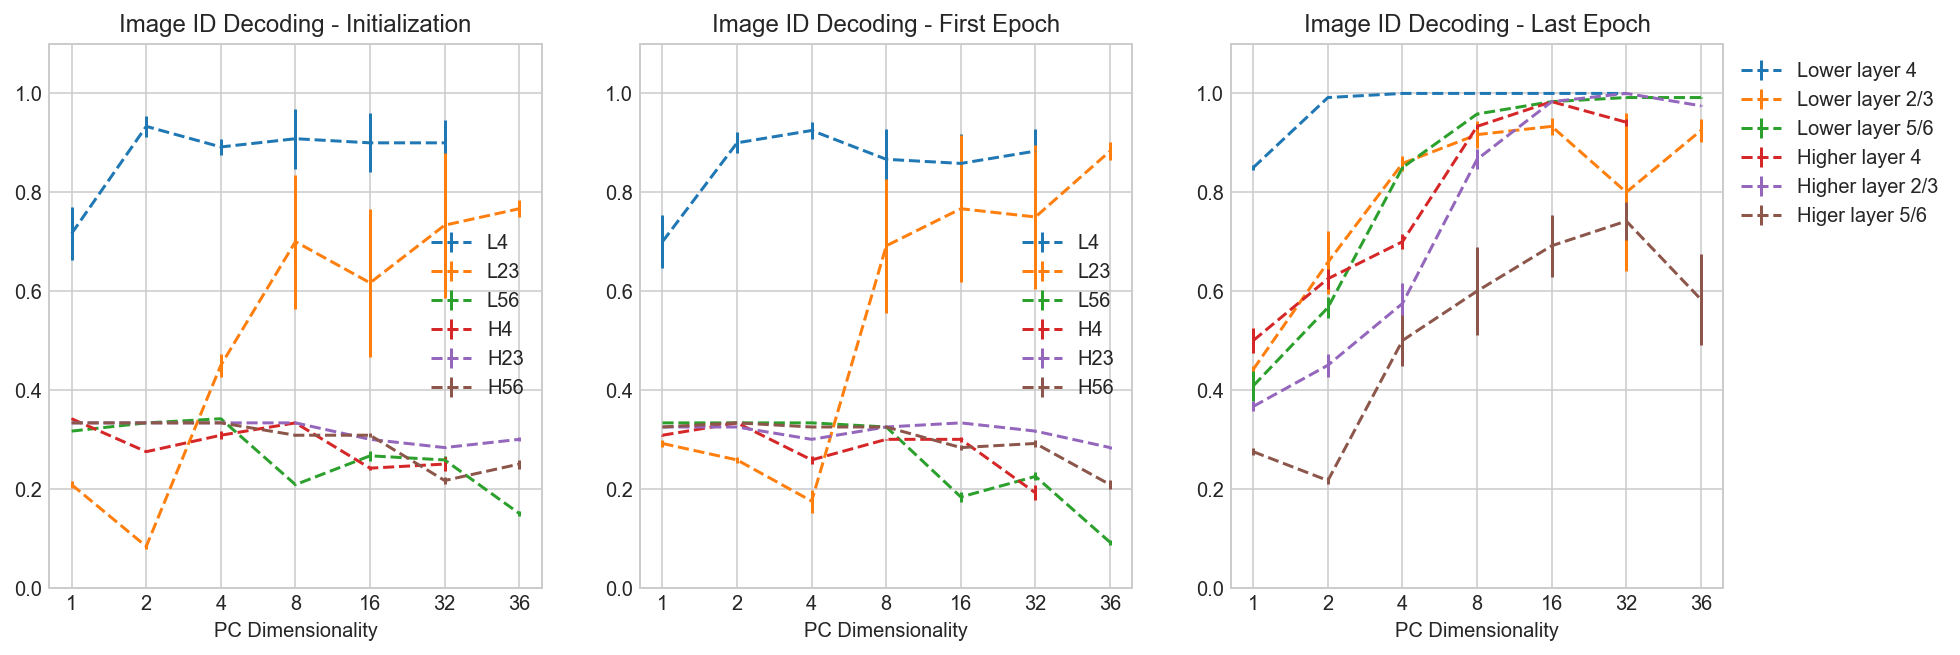

In [313]:
ffdim = plt.figure(figsize=(15,5))

plt.subplot(131)
plt.title('Image ID Decoding - Initialization')
plt.errorbar(np.arange(len(dims4)),mean_accs_L4imgPC[:,0],yerr=std_accs_L4imgPC[:,1],label='L4',fmt='--')
plt.errorbar(np.arange(len(dims23)),mean_accs_L23imgPC[:,0],yerr=std_accs_L23imgPC[:,1],label='L23',fmt='--')
plt.errorbar(np.arange(len(dims56)),mean_accs_L56imgPC[:,0],yerr=std_accs_L56imgPC[:,1],label='L56',fmt='--')
plt.errorbar(np.arange(len(dims4)),mean_accs_H4imgPC[:,0],yerr=std_accs_H4imgPC[:,1],label='H4',fmt='--')
plt.errorbar(np.arange(len(dims23)),mean_accs_H23imgPC[:,0],yerr=std_accs_H23imgPC[:,1],label='H23',fmt='--')
plt.errorbar(np.arange(len(dims56)),mean_accs_H56imgPC[:,0],yerr=std_accs_H56imgPC[:,1],label='H56',fmt='--')
plt.xlabel('PC Dimensionality')
plt.ylim(0,1.1)
plt.xticks(np.arange(len(dims23)),dims23)
plt.legend()

plt.subplot(132)
plt.title('Image ID Decoding - First Epoch')
plt.errorbar(np.arange(len(dims4)),mean_accs_L4imgPC[:,1],yerr=std_accs_L4imgPC[:,1],label='L4',fmt='--')
plt.errorbar(np.arange(len(dims23)),mean_accs_L23imgPC[:,1],yerr=std_accs_L23imgPC[:,1],label='L23',fmt='--')
plt.errorbar(np.arange(len(dims56)),mean_accs_L56imgPC[:,1],yerr=std_accs_L56imgPC[:,1],label='L56',fmt='--')
plt.errorbar(np.arange(len(dims4)),mean_accs_H4imgPC[:,1],yerr=std_accs_H4imgPC[:,1],label='H4',fmt='--')
plt.errorbar(np.arange(len(dims23)),mean_accs_H23imgPC[:,1],yerr=std_accs_H23imgPC[:,1],label='H23',fmt='--')
plt.errorbar(np.arange(len(dims56)),mean_accs_H56imgPC[:,1],yerr=std_accs_H56imgPC[:,1],label='H56',fmt='--')
plt.xlabel('PC Dimensionality')
plt.ylim(0,1.1)
plt.xticks(np.arange(len(dims23)),dims23)
plt.legend()

plt.subplot(133)
plt.title('Image ID Decoding - Last Epoch')
plt.errorbar(np.arange(len(dims4)),mean_accs_L4imgPC[:,-1],yerr=std_accs_L4imgPC[:,-1],label='Lower layer 4',fmt='--')
plt.errorbar(np.arange(len(dims23)),mean_accs_L23imgPC[:,-1],yerr=std_accs_L23imgPC[:,-1],label='Lower layer 2/3',fmt='--')
plt.errorbar(np.arange(len(dims56)),mean_accs_L56imgPC[:,-1],yerr=std_accs_L56imgPC[:,-1],label='Lower layer 5/6',fmt='--')
plt.errorbar(np.arange(len(dims4)),mean_accs_H4imgPC[:,-1],yerr=std_accs_H4imgPC[:,-1],label='Higher layer 4',fmt='--')
plt.errorbar(np.arange(len(dims23)),mean_accs_H23imgPC[:,-1],yerr=std_accs_H23imgPC[:,-1],label='Higher layer 2/3',fmt='--')
plt.errorbar(np.arange(len(dims56)),mean_accs_H56imgPC[:,-1],yerr=std_accs_H56imgPC[:,-1],label='Higer layer 5/6',fmt='--')
plt.xlabel('PC Dimensionality')
plt.ylim(0,1.1)
plt.xticks(np.arange(len(dims23)),dims23)
plt.legend(bbox_to_anchor=(1,1))

In [314]:
ffdim.savefig('repeated-runs-no-fb-imageID-decoding-across-pcs.png',dpi=300)

Text(0, 0.5, 'Accuracy')

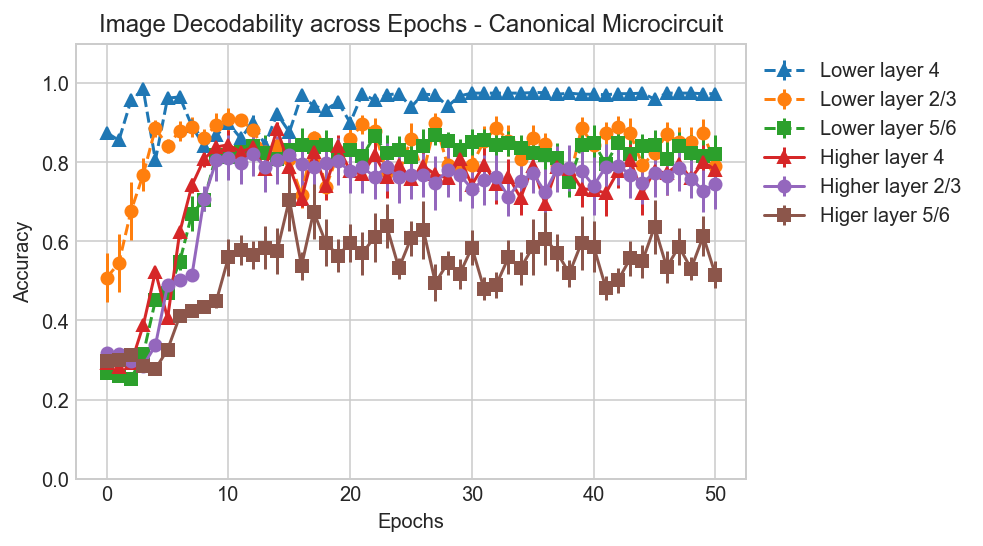

In [412]:
fimg_pcs = plt.figure()
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_L4imgPC,0),yerr=np.var(mean_accs_L4imgPC,0),label='Lower layer 4',fmt='--^')
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_L23imgPC,0),yerr=np.var(mean_accs_L23imgPC,0),label='Lower layer 2/3',fmt='--o')
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_L56imgPC,0),yerr=np.var(mean_accs_L56imgPC,0),label='Lower layer 5/6',fmt='--s')
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_H4imgPC,0),yerr=np.var(mean_accs_H4imgPC,0),label='Higher layer 4',fmt='-^')
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_H23imgPC,0),yerr=np.var(mean_accs_H23imgPC,0),label='Higher layer 2/3',fmt='-o')
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_H56imgPC,0),yerr=np.var(mean_accs_H56imgPC,0),label='Higer layer 5/6',fmt='-s')
plt.xlabel('Epochs')
plt.ylim(0,1.1)
plt.legend(bbox_to_anchor=(1,1))
plt.title('Image Decodability across Epochs - Canonical Microcircuit')
plt.ylabel('Accuracy')

In [315]:
# ffepoch = plt.figure(figsize=(15,11))

# plt.subplot(231)
# plt.title('Image ID Decoding - 1D')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_L4imgPC[0],yerr=std_accs_L4imgPC[0],label='L4',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_L23imgPC[0],yerr=std_accs_L23imgPC[0],label='L23',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_L56imgPC[0],yerr=std_accs_L56imgPC[0],label='L56',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_H4imgPC[0],yerr=std_accs_H4imgPC[0],label='H4',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_H23imgPC[0],yerr=std_accs_H23imgPC[0],label='H23',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_H56imgPC[0],yerr=std_accs_H56imgPC[0],label='H56',fmt='.')
# plt.xlabel('Epochs')
# plt.ylim(0,1.1)
# plt.legend()

# plt.subplot(232)
# plt.title('Image ID Decoding - 2D')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_L4imgPC[1],yerr=std_accs_L4imgPC[1],label='L4',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_L23imgPC[1],yerr=std_accs_L23imgPC[1],label='L23',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_L56imgPC[1],yerr=std_accs_L56imgPC[1],label='L56',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_H4imgPC[1],yerr=std_accs_H4imgPC[1],label='H4',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_H23imgPC[1],yerr=std_accs_H23imgPC[1],label='H23',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_H56imgPC[1],yerr=std_accs_H56imgPC[1],label='H56',fmt='.')
# plt.xlabel('Epochs')
# plt.ylim(0,1.1)
# plt.legend()

# plt.subplot(233)
# plt.title('Image ID Decoding - 32D')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_L4imgPC[-1],yerr=std_accs_L4imgPC[-1],label='L4',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_L23imgPC[-1],yerr=std_accs_L23imgPC[-1],label='L23',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_L56imgPC[-1],yerr=std_accs_L56imgPC[-1],label='L56',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_H4imgPC[-1],yerr=std_accs_H4imgPC[-1],label='H4',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_H23imgPC[-1],yerr=std_accs_H23imgPC[-1],label='H23',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_H56imgPC[-1],yerr=std_accs_H56imgPC[-1],label='H56',fmt='.')
# plt.xlabel('Epochs')
# plt.ylim(0,1.1)
# plt.legend()

# plt.subplot(234)
# plt.title('Surprise Decoding - 1D')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_L4surpPC[0],yerr=std_accs_L4surpPC[0],label='L4',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_L23surpPC[0],yerr=std_accs_L23surpPC[0],label='L23',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_L56surpPC[0],yerr=std_accs_L56surpPC[0],label='L56',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_H4surpPC[0],yerr=std_accs_H4surpPC[0],label='H4',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_H23surpPC[0],yerr=std_accs_H23surpPC[0],label='H23',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_H56surpPC[0],yerr=std_accs_H56surpPC[0],label='H56',fmt='.')
# plt.xlabel('Epochs')
# plt.ylim(0,1.1)
# plt.legend()

# plt.subplot(235)
# plt.title('Surprise Decoding - 2D')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_L4surpPC[1],yerr=std_accs_L4surpPC[1],label='L4',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_L23surpPC[1],yerr=std_accs_L23surpPC[1],label='L23',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_L56surpPC[1],yerr=std_accs_L56surpPC[1],label='L56',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_H4surpPC[1],yerr=std_accs_H4surpPC[1],label='H4',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_H23surpPC[1],yerr=std_accs_H23surpPC[1],label='H23',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_H56surpPC[1],yerr=std_accs_H56surpPC[1],label='H56',fmt='.')
# plt.xlabel('Epochs')
# plt.ylim(0,1.1)
# plt.legend()

# plt.subplot(236)
# plt.title('Surprise Decoding - 32D')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_L4surpPC[-1],yerr=std_accs_L4surpPC[-1],label='L4',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_L23surpPC[-1],yerr=std_accs_L23surpPC[-1],label='L23',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_L56surpPC[-1],yerr=std_accs_L56surpPC[-1],label='L56',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_H4surpPC[-1],yerr=std_accs_H4surpPC[-1],label='H4',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_H23surpPC[-1],yerr=std_accs_H23surpPC[-1],label='H23',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_H56surpPC[-1],yerr=std_accs_H56surpPC[-1],label='H56',fmt='.')
# plt.xlabel('Epochs')
# plt.ylim(0,1.1)

# plt.legend()
# plt.show()

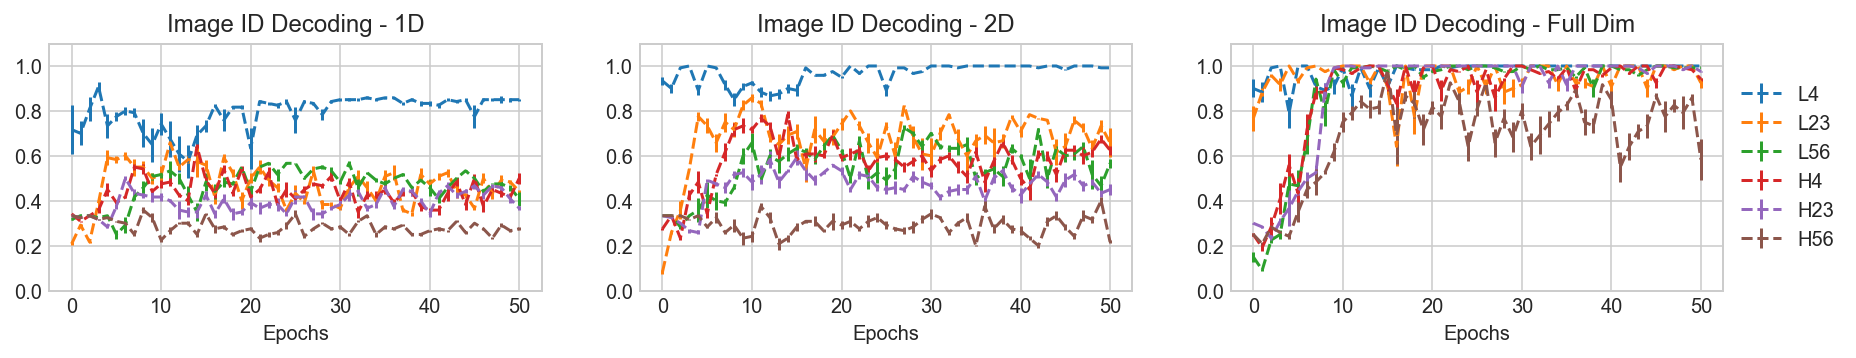

In [316]:
ffepoch = plt.figure(figsize=(15,5))

plt.subplot(231)
plt.title('Image ID Decoding - 1D')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L4imgPC[0],yerr=std_accs_L4imgPC[0],label='L4',fmt='--')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L23imgPC[0],yerr=std_accs_L23imgPC[0],label='L23',fmt='--')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L56imgPC[0],yerr=std_accs_L56imgPC[0],label='L56',fmt='--')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H4imgPC[0],yerr=std_accs_H4imgPC[0],label='H4',fmt='--')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H23imgPC[0],yerr=std_accs_H23imgPC[0],label='H23',fmt='--')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H56imgPC[0],yerr=std_accs_H56imgPC[0],label='H56',fmt='--')
plt.xlabel('Epochs')
plt.ylim(0,1.1)
# plt.legend()

plt.subplot(232)
plt.title('Image ID Decoding - 2D')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L4imgPC[1],yerr=std_accs_L4imgPC[1],label='L4',fmt='--')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L23imgPC[1],yerr=std_accs_L23imgPC[1],label='L23',fmt='--')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L56imgPC[1],yerr=std_accs_L56imgPC[1],label='L56',fmt='--')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H4imgPC[1],yerr=std_accs_H4imgPC[1],label='H4',fmt='--')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H23imgPC[1],yerr=std_accs_H23imgPC[1],label='H23',fmt='--')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H56imgPC[1],yerr=std_accs_H56imgPC[1],label='H56',fmt='--')
plt.xlabel('Epochs')
plt.ylim(0,1.1)
# plt.legend()

plt.subplot(233)
plt.title('Image ID Decoding - Full Dim')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L4imgPC[-1],yerr=std_accs_L4imgPC[-1],label='L4',fmt='--')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L23imgPC[-1],yerr=std_accs_L23imgPC[-1],label='L23',fmt='--')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L56imgPC[-1],yerr=std_accs_L56imgPC[-1],label='L56',fmt='--')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H4imgPC[-1],yerr=std_accs_H4imgPC[-1],label='H4',fmt='--')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H23imgPC[-1],yerr=std_accs_H23imgPC[-1],label='H23',fmt='--')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H56imgPC[-1],yerr=std_accs_H56imgPC[-1],label='H56',fmt='--')
plt.xlabel('Epochs')
plt.ylim(0,1.1)
# plt.legend()

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [317]:
ffepoch.savefig('repeated-runs-no-fb-imageID-decoding-across-epochs.png',dpi=300)

#### Position decoding

In [318]:
def repsDecodeSupervisedPosition(rnnActs,labels,clf='svm'):
    nEpochs, nSamps, nNeurons = rnnActs.shape
    decode_dict = {}
    
    nClasses = 6
    
    reps_preds_probs = np.zeros((nEpochs,nSamps,nClasses))
    
    for ep in (range(nEpochs)):
        repsR = rnnActs[ep]
        
        ## Decoding
        if clf=='svm':
            clfR = SVC(kernel='linear',probability=True).fit(repsR,labels)
        elif clf=='logistic':
            clfR = LogisticRegression().fit(repsR,labels)
        elif clf=='perceptron':
            clfR = Perceptron().fit(repsR,labels)
        
        reps_preds_probs[ep] = clfR.predict_proba(repsR)
        decode_dict[str(ep)] = clfR
        
    return reps_preds_probs, decode_dict

In [319]:
L4posPC = {}
L23posPC = {}
L56posPC = {}
H4posPC = {}
H23posPC = {}
H56posPC = {}

In [320]:
for cntr in tqdm(range(nRuns)):
    
    for d in dims23:
        L23posPC[cntr,d], _ = repsDecodeSupervisedPosition(cleanPCs[cntr][1][:,:,:d],labelMtxC[:,-1])
        H23posPC[cntr,d], _ = repsDecodeSupervisedPosition(cleanPCs[cntr][4][:,:,:d],labelMtxC[:,-1])
    
    for d in dims4:
        L4posPC[cntr,d], _ = repsDecodeSupervisedPosition(cleanPCs[cntr][0][:,:,:d],labelMtxC[:,-1])
        H4posPC[cntr,d], _ = repsDecodeSupervisedPosition(cleanPCs[cntr][3][:,:,:d],labelMtxC[:,-1])
        
    for d in dims56:
        ## Position
        L56posPC[cntr,d], _ = repsDecodeSupervisedPosition(cleanPCs[cntr][2][:,:,:d],labelMtxC[:,-1])      
        H56posPC[cntr,d], _ = repsDecodeSupervisedPosition(cleanPCs[cntr][5][:,:,:d],labelMtxC[:,-1])

100%|██████████| 5/5 [00:21<00:00,  4.30s/it]


In [321]:
preds_L23posPC = {}
preds_L4posPC = {}
preds_L56posPC = {}

preds_H23posPC = {}
preds_H4posPC = {}
preds_H56posPC = {}

In [322]:
accs_L23posPC = {}
accs_L4posPC = {}
accs_L56posPC = {}

accs_H23posPC = {}
accs_H4posPC = {}
accs_H56posPC = {}

In [323]:
for cntr in range(nRuns):
    
    for ep in range(n_epochs+1):
        
        for d in dims23:
            preds_L23posPC[cntr,d,ep] = np.argmax(L23posPC[cntr,d][ep],axis=-1)
            preds_H23posPC[cntr,d,ep] = np.argmax(H23posPC[cntr,d][ep],axis=-1)
            
            accs_L23posPC[cntr,d,ep] = accuracy_score(labelMtxC[:,-1],preds_L23posPC[cntr,d,ep])
            accs_H23posPC[cntr,d,ep] = accuracy_score(labelMtxC[:,-1],preds_H23posPC[cntr,d,ep])
            
        for d in dims4:
            preds_L4posPC[cntr,d,ep] = np.argmax(L4posPC[cntr,d][ep],axis=-1)
            preds_H4posPC[cntr,d,ep] = np.argmax(H4posPC[cntr,d][ep],axis=-1)
            
            accs_L4posPC[cntr,d,ep] = accuracy_score(labelMtxC[:,-1],preds_L4posPC[cntr,d,ep])
            accs_H4posPC[cntr,d,ep] = accuracy_score(labelMtxC[:,-1],preds_H4posPC[cntr,d,ep])
            
        for d in dims56:
            preds_L56posPC[cntr,d,ep] = np.argmax(L56posPC[cntr,d][ep],axis=-1)
            preds_H56posPC[cntr,d,ep] = np.argmax(H56posPC[cntr,d][ep],axis=-1)
            
            accs_L56posPC[cntr,d,ep] = accuracy_score(labelMtxC[:,-1],preds_L56posPC[cntr,d,ep])
            accs_H56posPC[cntr,d,ep] = accuracy_score(labelMtxC[:,-1],preds_H56posPC[cntr,d,ep])

In [324]:
tensor_accs_L23posPC = np.zeros((nRuns,len(dims23),n_epochs+1))
tensor_accs_L4posPC = np.zeros((nRuns,len(dims4),n_epochs+1))
tensor_accs_L56posPC = np.zeros((nRuns,len(dims56),n_epochs+1))

tensor_accs_H23posPC = np.zeros((nRuns,len(dims23),n_epochs+1))
tensor_accs_H4posPC = np.zeros((nRuns,len(dims4),n_epochs+1))
tensor_accs_H56posPC = np.zeros((nRuns,len(dims56),n_epochs+1))

In [325]:
for ii in range(nRuns):
    
    for kk in range(n_epochs+1):
        
        for jj,d in enumerate(dims23):
            tensor_accs_L23posPC[ii,jj,kk] = accs_L23posPC[ii,d,kk]
            tensor_accs_H23posPC[ii,jj,kk] = accs_H23posPC[ii,d,kk]
            
        for jj,d in enumerate(dims4):
            tensor_accs_L4posPC[ii,jj,kk] = accs_L4posPC[ii,d,kk]
            tensor_accs_H4posPC[ii,jj,kk] = accs_H4posPC[ii,d,kk]
            
        for jj,d in enumerate(dims56):            
            tensor_accs_L56posPC[ii,jj,kk] = accs_L56posPC[ii,d,kk]            
            tensor_accs_H56posPC[ii,jj,kk] = accs_H56posPC[ii,d,kk]

In [326]:
mean_accs_L4posPC = np.zeros((len(dims4),n_epochs+1))
mean_accs_L23posPC = np.zeros((len(dims23),n_epochs+1))
mean_accs_L56posPC = np.zeros((len(dims56),n_epochs+1))

mean_accs_H4posPC = np.zeros((len(dims4),n_epochs+1))
mean_accs_H23posPC = np.zeros((len(dims23),n_epochs+1))
mean_accs_H56posPC = np.zeros((len(dims56),n_epochs+1))

std_accs_L4posPC = np.zeros((len(dims4),n_epochs+1))
std_accs_L23posPC = np.zeros((len(dims23),n_epochs+1))
std_accs_L56posPC = np.zeros((len(dims56),n_epochs+1))

std_accs_H4posPC = np.zeros((len(dims4),n_epochs+1))
std_accs_H23posPC = np.zeros((len(dims23),n_epochs+1))
std_accs_H56posPC = np.zeros((len(dims56),n_epochs+1))

In [327]:
for ep in range(n_epochs+1):
    
    for dd, dim in enumerate(dims23):
        mean_accs_L23posPC[dd,ep] = np.mean(tensor_accs_L23posPC[:,dd,ep])
        mean_accs_H23posPC[dd,ep] = np.mean(tensor_accs_H23posPC[:,dd,ep])
        
        std_accs_L23posPC[dd,ep] = np.var(tensor_accs_L23posPC[:,dd,ep])
        std_accs_H23posPC[dd,ep] = np.var(tensor_accs_H23posPC[:,dd,ep])
        
    for dd, dim in enumerate(dims4):
        mean_accs_L4posPC[dd,ep] = np.mean(tensor_accs_L4posPC[:,dd,ep])
        mean_accs_H4posPC[dd,ep] = np.mean(tensor_accs_H4posPC[:,dd,ep])
        
        std_accs_L4posPC[dd,ep] = np.var(tensor_accs_L4posPC[:,dd,ep])
        std_accs_H4posPC[dd,ep] = np.var(tensor_accs_H4posPC[:,dd,ep])
        
    for dd, dim in enumerate(dims56):
        mean_accs_L56posPC[dd,ep] = np.mean(tensor_accs_L56posPC[:,dd,ep])
        mean_accs_H56posPC[dd,ep] = np.mean(tensor_accs_H56posPC[:,dd,ep])
        
        std_accs_L56posPC[dd,ep] = np.var(tensor_accs_L56posPC[:,dd,ep])
        std_accs_H56posPC[dd,ep] = np.var(tensor_accs_H56posPC[:,dd,ep])

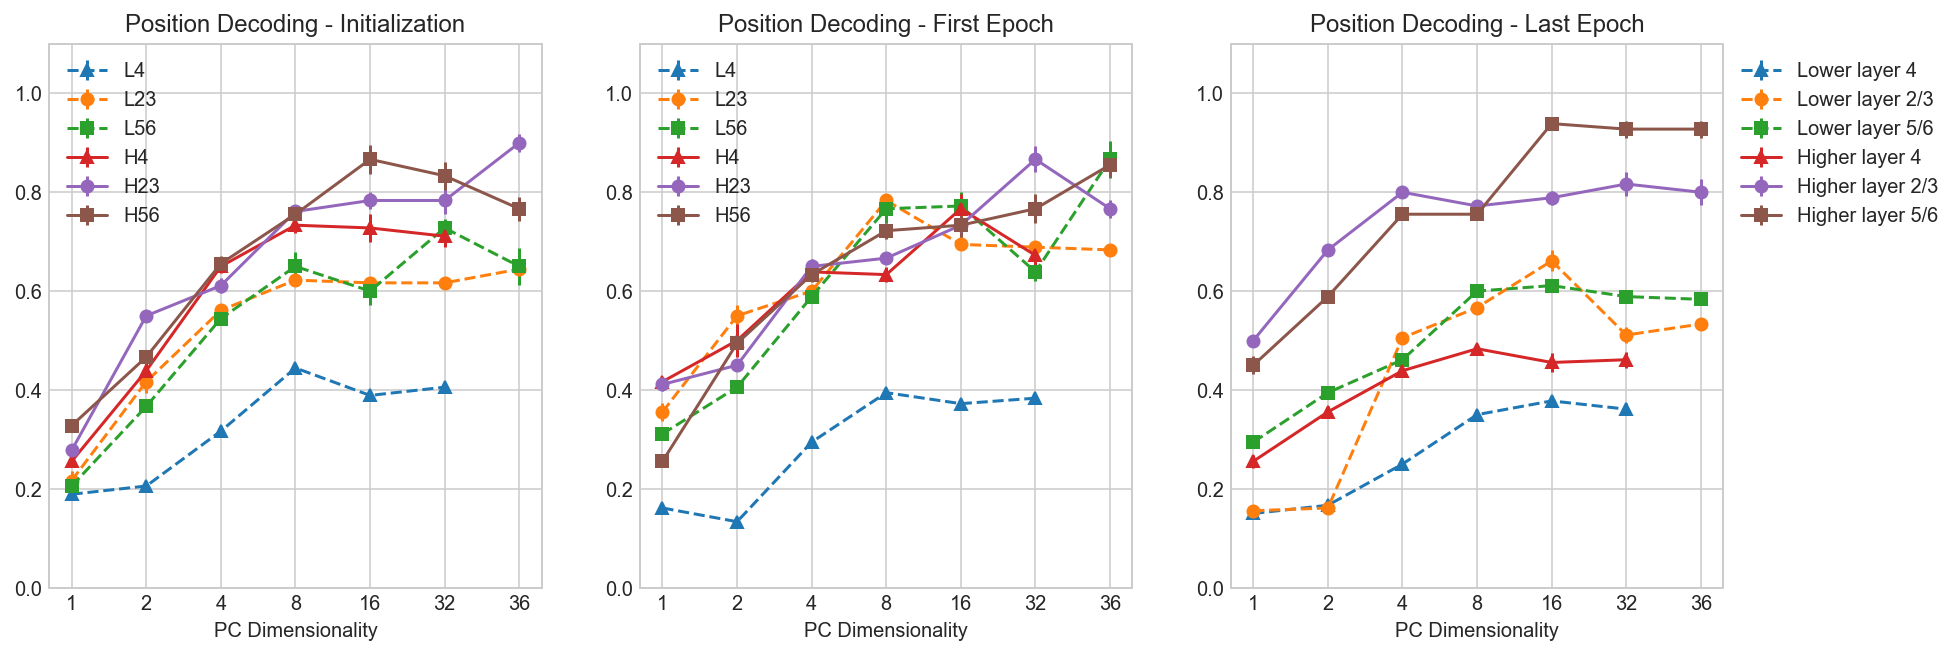

In [328]:
ffpos = plt.figure(figsize=(15,5))

plt.subplot(131)
plt.title('Position Decoding - Initialization')
plt.errorbar(np.arange(len(dims4)),mean_accs_L4posPC[:,0],yerr=std_accs_L4posPC[:,1],label='L4',fmt='--^')
plt.errorbar(np.arange(len(dims23)),mean_accs_L23posPC[:,0],yerr=std_accs_L23posPC[:,1],label='L23',fmt='--o')
plt.errorbar(np.arange(len(dims56)),mean_accs_L56posPC[:,0],yerr=std_accs_L56posPC[:,1],label='L56',fmt='--s')
plt.errorbar(np.arange(len(dims4)),mean_accs_H4posPC[:,0],yerr=std_accs_H4posPC[:,1],label='H4',fmt='-^')
plt.errorbar(np.arange(len(dims23)),mean_accs_H23posPC[:,0],yerr=std_accs_H23posPC[:,1],label='H23',fmt='-o')
plt.errorbar(np.arange(len(dims56)),mean_accs_H56posPC[:,0],yerr=std_accs_H56posPC[:,1],label='H56',fmt='-s')
plt.xlabel('PC Dimensionality')
plt.ylim(0,1.1)
plt.xticks(np.arange(len(dims23)),dims23)
plt.legend()

plt.subplot(132)
plt.title('Position Decoding - First Epoch')
plt.errorbar(np.arange(len(dims4)),mean_accs_L4posPC[:,1],yerr=std_accs_L4posPC[:,1],label='L4',fmt='--^')
plt.errorbar(np.arange(len(dims23)),mean_accs_L23posPC[:,1],yerr=std_accs_L23posPC[:,1],label='L23',fmt='--o')
plt.errorbar(np.arange(len(dims56)),mean_accs_L56posPC[:,1],yerr=std_accs_L56posPC[:,1],label='L56',fmt='--s')
plt.errorbar(np.arange(len(dims4)),mean_accs_H4posPC[:,1],yerr=std_accs_H4posPC[:,1],label='H4',fmt='-^')
plt.errorbar(np.arange(len(dims23)),mean_accs_H23posPC[:,1],yerr=std_accs_H23posPC[:,1],label='H23',fmt='-o')
plt.errorbar(np.arange(len(dims56)),mean_accs_H56posPC[:,1],yerr=std_accs_H56posPC[:,1],label='H56',fmt='-s')
plt.xlabel('PC Dimensionality')
plt.ylim(0,1.1)
plt.xticks(np.arange(len(dims23)),dims23)
plt.legend()

plt.subplot(133)
plt.title('Position Decoding - Last Epoch')
plt.errorbar(np.arange(len(dims4)),mean_accs_L4posPC[:,-1],yerr=std_accs_L4posPC[:,-1],label='Lower layer 4',fmt='--^')
plt.errorbar(np.arange(len(dims23)),mean_accs_L23posPC[:,-1],yerr=std_accs_L23posPC[:,-1],label='Lower layer 2/3',fmt='--o')
plt.errorbar(np.arange(len(dims56)),mean_accs_L56posPC[:,-1],yerr=std_accs_L56posPC[:,-1],label='Lower layer 5/6',fmt='--s')
plt.errorbar(np.arange(len(dims4)),mean_accs_H4posPC[:,-1],yerr=std_accs_H4posPC[:,-1],label='Higher layer 4',fmt='-^')
plt.errorbar(np.arange(len(dims23)),mean_accs_H23posPC[:,-1],yerr=std_accs_H23posPC[:,-1],label='Higher layer 2/3',fmt='-o')
plt.errorbar(np.arange(len(dims56)),mean_accs_H56posPC[:,-1],yerr=std_accs_H56posPC[:,-1],label='Higher layer 5/6',fmt='-s')
plt.xlabel('PC Dimensionality')
plt.ylim(0,1.1)
plt.xticks(np.arange(len(dims23)),dims23)
plt.legend(bbox_to_anchor=(1,1))

Text(0, 0.5, 'Accuracy')

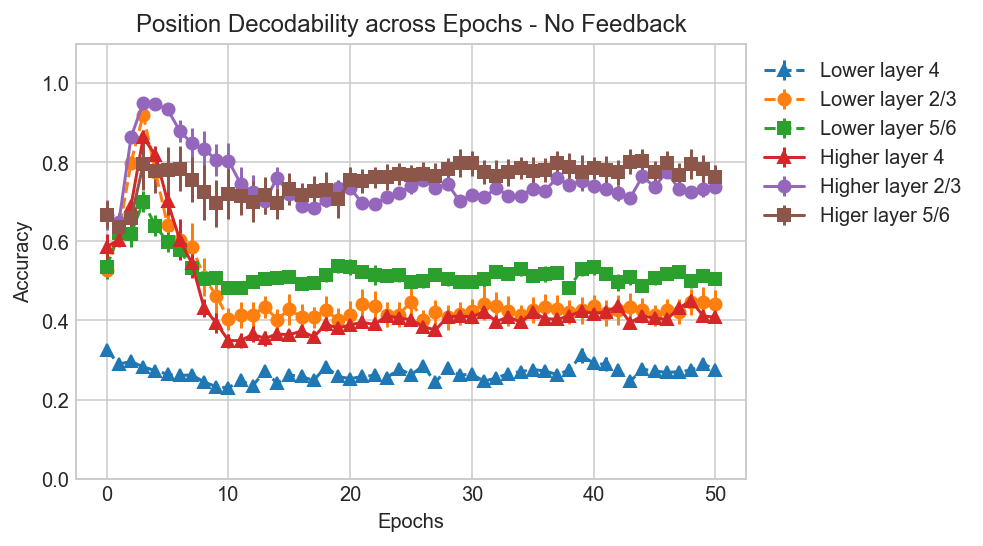

In [409]:
fpos_pcs = plt.figure()
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_L4posPC,0),yerr=np.var(mean_accs_L4posPC,0),label='Lower layer 4',fmt='--^')
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_L23posPC,0),yerr=np.var(mean_accs_L23posPC,0),label='Lower layer 2/3',fmt='--o')
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_L56posPC,0),yerr=np.var(mean_accs_L56posPC,0),label='Lower layer 5/6',fmt='--s')
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_H4posPC,0),yerr=np.var(mean_accs_H4posPC,0),label='Higher layer 4',fmt='-^')
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_H23posPC,0),yerr=np.var(mean_accs_H23posPC,0),label='Higher layer 2/3',fmt='-o')
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_H56posPC,0),yerr=np.var(mean_accs_H56posPC,0),label='Higer layer 5/6',fmt='-s')
plt.xlabel('Epochs')
plt.ylim(0,1.1)
plt.legend(bbox_to_anchor=(1,1))
plt.title('Position Decodability across Epochs - No Feedback')
plt.ylabel('Accuracy')

In [410]:
fpos_pcs.savefig('position-across-epochs-averaged-PCs-no-fb.png',dpi=300,bbox_inches="tight")

In [329]:
ffpos.savefig('repeated-runs-no-fb-position-decoding-across-pcs.png',dpi=300)

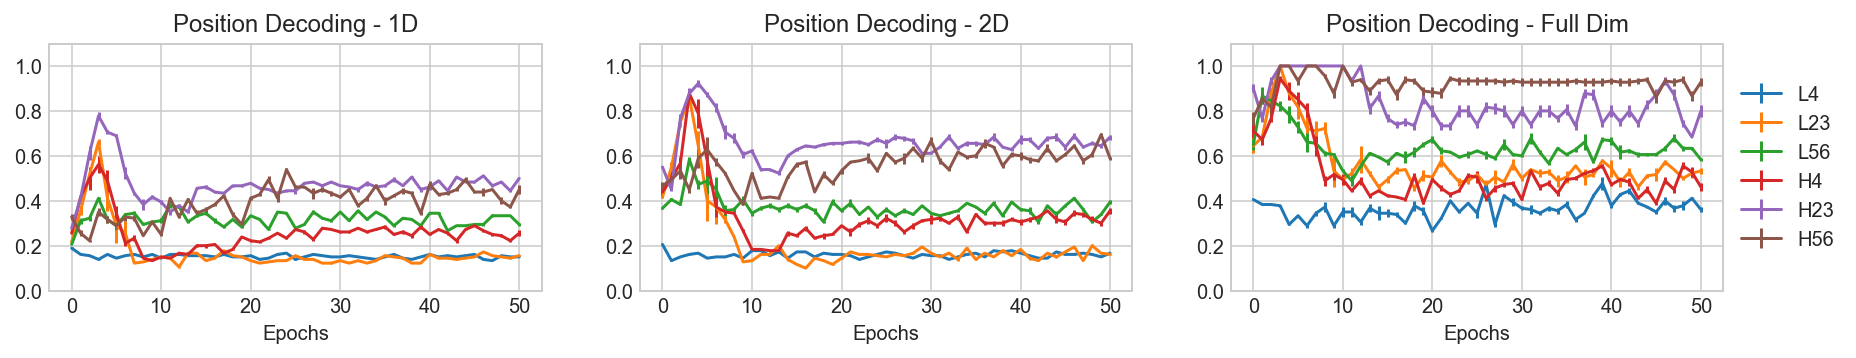

In [330]:
ffpos_epoch = plt.figure(figsize=(15,5))

plt.subplot(231)
plt.title('Position Decoding - 1D')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L4posPC[0],yerr=std_accs_L4posPC[0],label='L4',fmt='-')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L23posPC[0],yerr=std_accs_L23posPC[0],label='L23',fmt='-')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L56posPC[0],yerr=std_accs_L56posPC[0],label='L56',fmt='-')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H4posPC[0],yerr=std_accs_H4posPC[0],label='H4',fmt='-')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H23posPC[0],yerr=std_accs_H23posPC[0],label='H23',fmt='-')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H56posPC[0],yerr=std_accs_H56posPC[0],label='H56',fmt='-')
plt.xlabel('Epochs')
plt.ylim(0,1.1)
# plt.legend()

plt.subplot(232)
plt.title('Position Decoding - 2D')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L4posPC[1],yerr=std_accs_L4posPC[1],label='L4',fmt='-')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L23posPC[1],yerr=std_accs_L23posPC[1],label='L23',fmt='-')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L56posPC[1],yerr=std_accs_L56posPC[1],label='L56',fmt='-')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H4posPC[1],yerr=std_accs_H4posPC[1],label='H4',fmt='-')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H23posPC[1],yerr=std_accs_H23posPC[1],label='H23',fmt='-')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H56posPC[1],yerr=std_accs_H56posPC[1],label='H56',fmt='-')
plt.xlabel('Epochs')
plt.ylim(0,1.1)
# plt.legend()

plt.subplot(233)
plt.title('Position Decoding - Full Dim')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L4posPC[-1],yerr=std_accs_L4posPC[-1],label='L4',fmt='-')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L23posPC[-1],yerr=std_accs_L23posPC[-1],label='L23',fmt='-')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L56posPC[-1],yerr=std_accs_L56posPC[-1],label='L56',fmt='-')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H4posPC[-1],yerr=std_accs_H4posPC[-1],label='H4',fmt='-')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H23posPC[-1],yerr=std_accs_H23posPC[-1],label='H23',fmt='-')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H56posPC[-1],yerr=std_accs_H56posPC[-1],label='H56',fmt='-')
plt.xlabel('Epochs')
plt.ylim(0,1.1)
# plt.legend()

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [331]:
ffpos_epoch.savefig('repeated-runs-no-fb-position-decoding-across-epochs.png',dpi=300)

#### Surprise Decoding

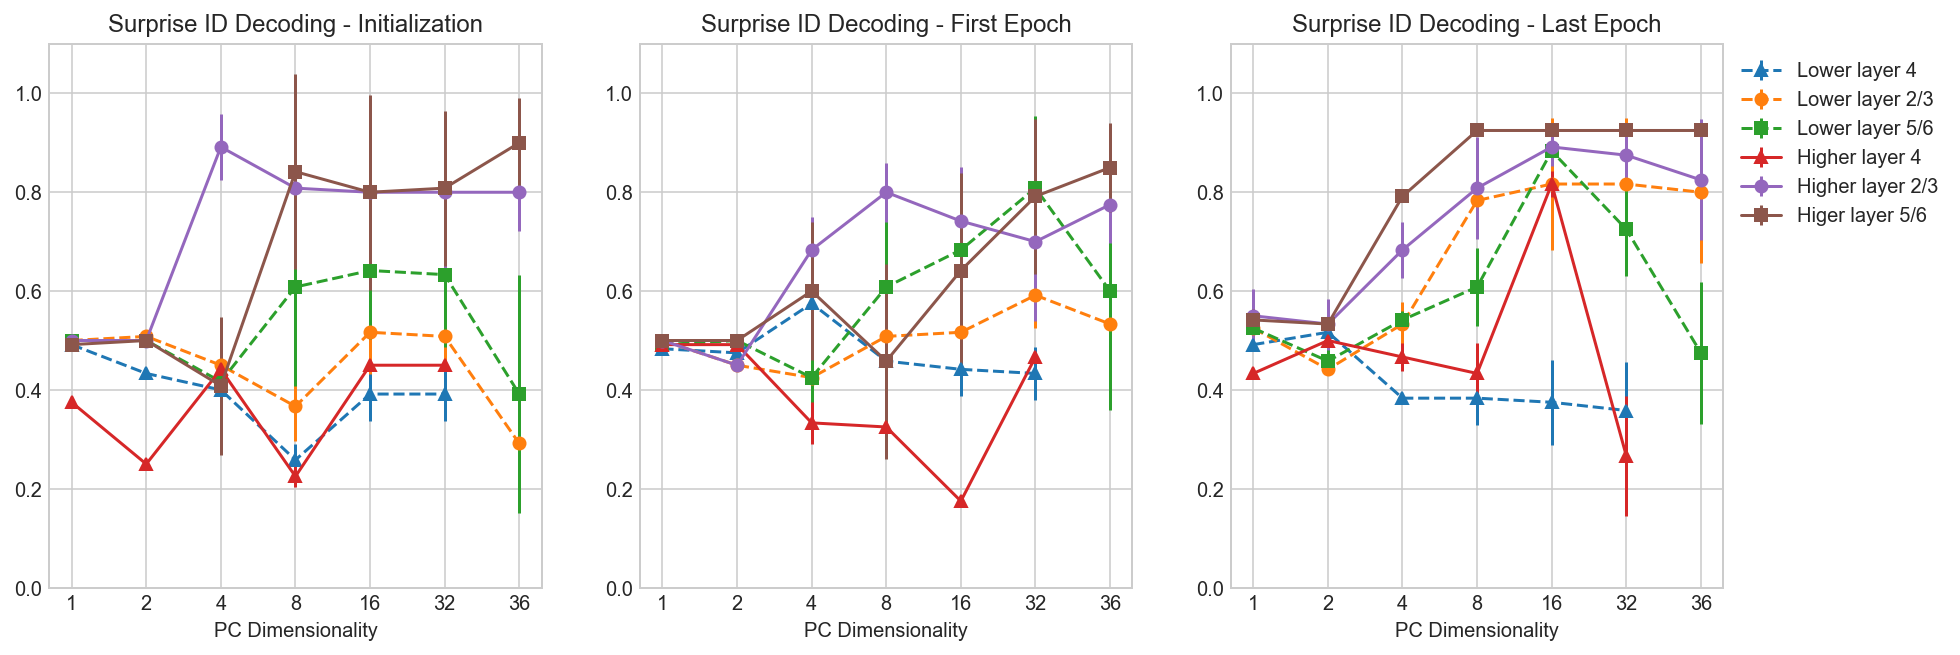

In [332]:
ffsurp_dim = plt.figure(figsize=(15,5))

plt.subplot(131)
plt.title('Surprise ID Decoding - Initialization')
plt.errorbar(np.arange(len(dims4)),mean_accs_L4surpPC[:,0],yerr=std_accs_L4surpPC[:,1],label='L4',fmt='--^')
plt.errorbar(np.arange(len(dims23)),mean_accs_L23surpPC[:,0],yerr=std_accs_L23surpPC[:,1],label='L23',fmt='--o')
plt.errorbar(np.arange(len(dims56)),mean_accs_L56surpPC[:,0],yerr=std_accs_L56surpPC[:,1],label='L56',fmt='--s')
plt.errorbar(np.arange(len(dims4)),mean_accs_H4surpPC[:,0],yerr=std_accs_H4surpPC[:,1],label='H4',fmt='-^')
plt.errorbar(np.arange(len(dims23)),mean_accs_H23surpPC[:,0],yerr=std_accs_H23surpPC[:,1],label='H23',fmt='-o')
plt.errorbar(np.arange(len(dims56)),mean_accs_H56surpPC[:,0],yerr=std_accs_H56surpPC[:,1],label='H56',fmt='-s')
plt.xlabel('PC Dimensionality')
plt.ylim(0,1.1)
plt.xticks(np.arange(len(dims23)),dims23)
# plt.legend()

plt.subplot(132)
plt.title('Surprise ID Decoding - First Epoch')
plt.errorbar(np.arange(len(dims4)),mean_accs_L4surpPC[:,1],yerr=std_accs_L4surpPC[:,1],label='L4',fmt='--^')
plt.errorbar(np.arange(len(dims23)),mean_accs_L23surpPC[:,1],yerr=std_accs_L23surpPC[:,1],label='L23',fmt='--o')
plt.errorbar(np.arange(len(dims56)),mean_accs_L56surpPC[:,1],yerr=std_accs_L56surpPC[:,1],label='L56',fmt='--s')
plt.errorbar(np.arange(len(dims4)),mean_accs_H4surpPC[:,1],yerr=std_accs_H4surpPC[:,1],label='H4',fmt='-^')
plt.errorbar(np.arange(len(dims23)),mean_accs_H23surpPC[:,1],yerr=std_accs_H23surpPC[:,1],label='H23',fmt='-o')
plt.errorbar(np.arange(len(dims56)),mean_accs_H56surpPC[:,1],yerr=std_accs_H56surpPC[:,1],label='H56',fmt='-s')
plt.xlabel('PC Dimensionality')
plt.ylim(0,1.1)
plt.xticks(np.arange(len(dims23)),dims23)
# plt.legend()

plt.subplot(133)
plt.title('Surprise ID Decoding - Last Epoch')
plt.errorbar(np.arange(len(dims4)),mean_accs_L4surpPC[:,-1],yerr=std_accs_L4surpPC[:,-1],label='Lower layer 4',fmt='--^')
plt.errorbar(np.arange(len(dims23)),mean_accs_L23surpPC[:,-1],yerr=std_accs_L23surpPC[:,-1],label='Lower layer 2/3',fmt='--o')
plt.errorbar(np.arange(len(dims56)),mean_accs_L56surpPC[:,-1],yerr=std_accs_L56surpPC[:,-1],label='Lower layer 5/6',fmt='--s')
plt.errorbar(np.arange(len(dims4)),mean_accs_H4surpPC[:,-1],yerr=std_accs_H4surpPC[:,-1],label='Higher layer 4',fmt='-^')
plt.errorbar(np.arange(len(dims23)),mean_accs_H23surpPC[:,-1],yerr=std_accs_H23surpPC[:,-1],label='Higher layer 2/3',fmt='-o')
plt.errorbar(np.arange(len(dims56)),mean_accs_H56surpPC[:,-1],yerr=std_accs_H56surpPC[:,-1],label='Higer layer 5/6',fmt='-s')
plt.xlabel('PC Dimensionality')
plt.ylim(0,1.1)
plt.xticks(np.arange(len(dims23)),dims23)
plt.legend(bbox_to_anchor=(1,1))

In [333]:
ffsurp_dim.savefig('repeated-runs-no-fb-surprise-decoding-across-PCs.png',dpi=300)

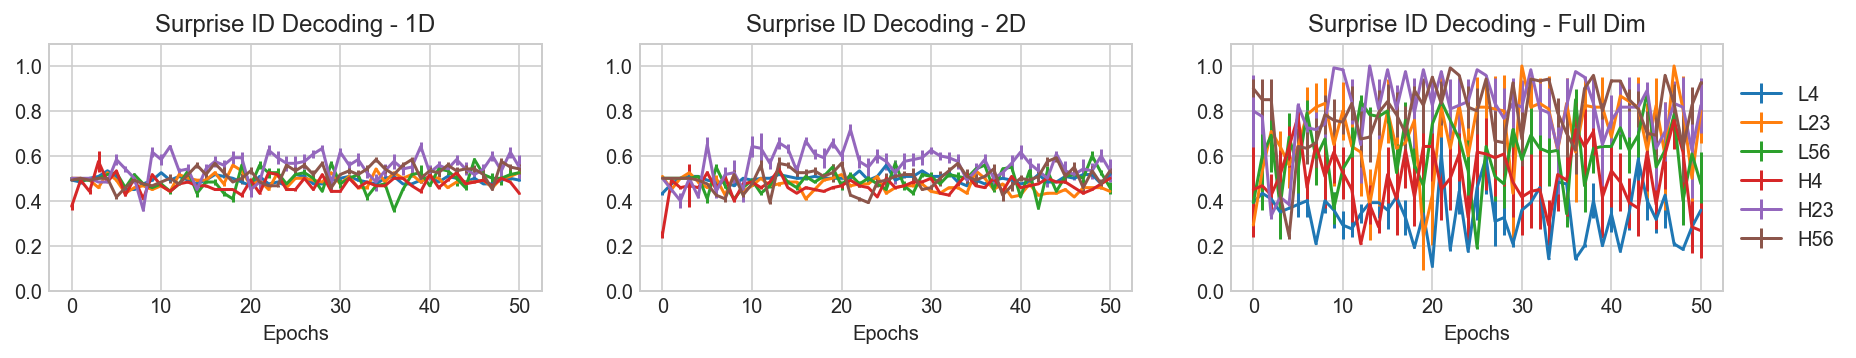

In [334]:
ffsurp_epoch = plt.figure(figsize=(15,5))

plt.subplot(231)
plt.title('Surprise ID Decoding - 1D')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L4surpPC[0],yerr=std_accs_L4surpPC[0],label='L4',fmt='-')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L23surpPC[0],yerr=std_accs_L23surpPC[0],label='L23',fmt='-')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L56surpPC[0],yerr=std_accs_L56surpPC[0],label='L56',fmt='-')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H4surpPC[0],yerr=std_accs_H4surpPC[0],label='H4',fmt='-')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H23surpPC[0],yerr=std_accs_H23surpPC[0],label='H23',fmt='-')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H56surpPC[0],yerr=std_accs_H56surpPC[0],label='H56',fmt='-')
plt.xlabel('Epochs')
plt.ylim(0,1.1)
# plt.legend()

plt.subplot(232)
plt.title('Surprise ID Decoding - 2D')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L4surpPC[1],yerr=std_accs_L4surpPC[1],label='L4',fmt='-')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L23surpPC[1],yerr=std_accs_L23surpPC[1],label='L23',fmt='-')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L56surpPC[1],yerr=std_accs_L56surpPC[1],label='L56',fmt='-')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H4surpPC[1],yerr=std_accs_H4surpPC[1],label='H4',fmt='-')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H23surpPC[1],yerr=std_accs_H23surpPC[1],label='H23',fmt='-')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H56surpPC[1],yerr=std_accs_H56surpPC[1],label='H56',fmt='-')
plt.xlabel('Epochs')
plt.ylim(0,1.1)
# plt.legend()

plt.subplot(233)
plt.title('Surprise ID Decoding - Full Dim')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L4surpPC[-1],yerr=std_accs_L4surpPC[-1],label='L4',fmt='-')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L23surpPC[-1],yerr=std_accs_L23surpPC[-1],label='L23',fmt='-')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L56surpPC[-1],yerr=std_accs_L56surpPC[-1],label='L56',fmt='-')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H4surpPC[-1],yerr=std_accs_H4surpPC[-1],label='H4',fmt='-')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H23surpPC[-1],yerr=std_accs_H23surpPC[-1],label='H23',fmt='-')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H56surpPC[-1],yerr=std_accs_H56surpPC[-1],label='H56',fmt='-')
plt.xlabel('Epochs')
plt.ylim(0,1.1)
# plt.legend()

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [335]:
ffsurp_epoch.savefig('repeated-runs-no-fb-surprise-decoding-across-epochs.png',dpi=300)

Text(0, 0.5, 'Accuracy')

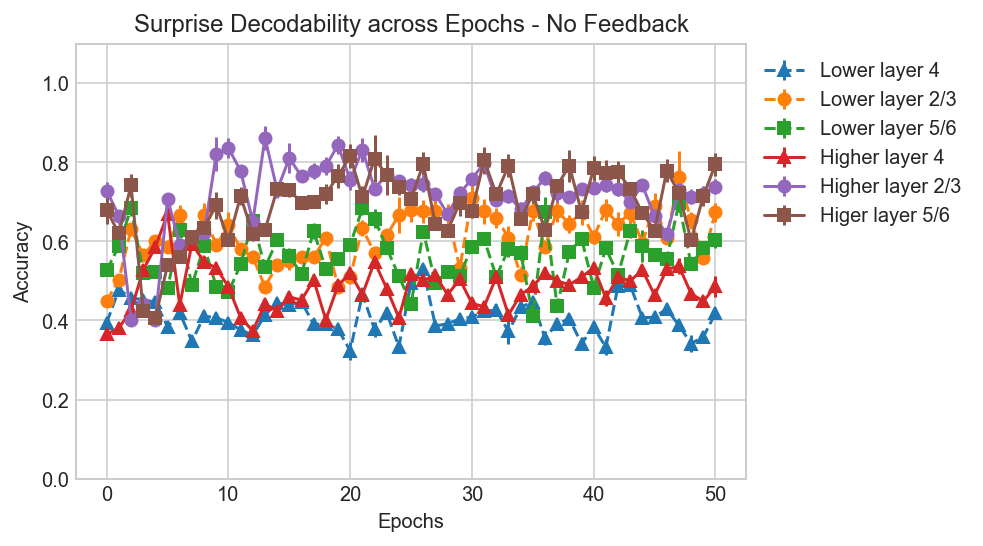

In [414]:
fsurp_pcs = plt.figure()
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_L4surpPC,0),yerr=np.var(mean_accs_L4surpPC,0),label='Lower layer 4',fmt='--^')
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_L23surpPC,0),yerr=np.var(mean_accs_L23surpPC,0),label='Lower layer 2/3',fmt='--o')
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_L56surpPC,0),yerr=np.var(mean_accs_L56surpPC,0),label='Lower layer 5/6',fmt='--s')
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_H4surpPC,0),yerr=np.var(mean_accs_H4surpPC,0),label='Higher layer 4',fmt='-^')
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_H23surpPC,0),yerr=np.var(mean_accs_H23surpPC,0),label='Higher layer 2/3',fmt='-o')
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_H56surpPC,0),yerr=np.var(mean_accs_H56surpPC,0),label='Higer layer 5/6',fmt='-s')
plt.xlabel('Epochs')
plt.ylim(0,1.1)
plt.legend(bbox_to_anchor=(1,1))
plt.title('Surprise Decodability across Epochs - No Feedback')
plt.ylabel('Accuracy')

#### Dimensionality (Linear)

In [42]:
def rnnLinDim(acts):
    nEpochs,nSeqs, nRolls, nNeurons = acts.shape
    nSamps = nSeqs*nRolls
    
    eig_mat = np.zeros((nEpochs,nNeurons))
        
    for ep in tqdm(range(nEpochs)):
        reps = acts[ep]
        
        ## reshape
        actsR = np.zeros((nSeqs*nRolls,nNeurons))
        cnt = 0
        
        for ii in range(nSeqs):
            for jj in range(nRolls):
                
                actsR[cnt] = reps[ii,jj]
                cnt += 1
        
        scaler = StandardScaler()
        actsScaled = scaler.fit_transform(actsR)
        cov = actsScaled.T@actsScaled
        eig_mat[ep] = eigvals(cov)
        num = np.sum(eig_mat,1)**2
        den = np.sum(eig_mat**2,1) + 1e-17
        PR = num/den
    return PR

In [43]:
L23LinDimC = np.zeros((nRuns,n_epochs+1))
L4LinDimC = np.zeros((nRuns,n_epochs+1))
L56LinDimC = np.zeros((nRuns,n_epochs+1))

H23LinDimC = np.zeros((nRuns,n_epochs+1))
H4LinDimC = np.zeros((nRuns,n_epochs+1))
H56LinDimC = np.zeros((nRuns,n_epochs+1))

L23LinDimS = np.zeros((nRuns,n_epochs+1))
L4LinDimS = np.zeros((nRuns,n_epochs+1))
L56LinDimS = np.zeros((nRuns,n_epochs+1))

H23LinDimS = np.zeros((nRuns,n_epochs+1))
H4LinDimS = np.zeros((nRuns,n_epochs+1))
H56LinDimS = np.zeros((nRuns,n_epochs+1))

In [44]:
for cntr in range(nRuns):
    L23LinDimC[cntr] = rnnLinDim(activations_hidden_L23C_np[cntr])
    L4LinDimC[cntr] = rnnLinDim(activations_hidden_L4C_np[cntr])
    L56LinDimC[cntr] = rnnLinDim(activations_hidden_L56C_np[cntr])

    H23LinDimC[cntr] = rnnLinDim(activations_hidden_H23C_np[cntr])
    H4LinDimC[cntr] = rnnLinDim(activations_hidden_H4C_np[cntr])
    H56LinDimC[cntr] = rnnLinDim(activations_hidden_H56C_np[cntr])

100%|██████████| 51/51 [00:00<00:00, 927.09it/s]


In [45]:
for cntr in range(nRuns):
    L23LinDimS[cntr] = rnnLinDim(activations_hidden_L23S_np[cntr])
    L4LinDimS[cntr] = rnnLinDim(activations_hidden_L4S_np[cntr])
    L56LinDimS[cntr] = rnnLinDim(activations_hidden_L56S_np[cntr])

    H23LinDimS[cntr] = rnnLinDim(activations_hidden_H23S_np[cntr])
    H4LinDimS[cntr] = rnnLinDim(activations_hidden_H4S_np[cntr])
    H56LinDimS[cntr] = rnnLinDim(activations_hidden_H56S_np[cntr])

100%|██████████| 51/51 [00:00<00:00, 962.26it/s]


In [46]:
L23_LineDim_meanC = np.mean(L23LinDimC,0)
L4_LineDim_meanC = np.mean(L4LinDimC,0)
L56_LineDim_meanC = np.mean(L56LinDimC,0)

H23_LineDim_meanC = np.mean(H23LinDimC,0)
H4_LineDim_meanC = np.mean(H4LinDimC,0)
H56_LineDim_meanC = np.mean(H56LinDimC,0)

L23_LineDim_stdC = np.std(L23LinDimC,0)
L4_LineDim_stdC = np.std(L4LinDimC,0)
L56_LineDim_stdC = np.std(L56LinDimC,0)

H23_LineDim_stdC = np.std(H23LinDimC,0)
H4_LineDim_stdC = np.std(H4LinDimC,0)
H56_LineDim_stdC = np.std(H56LinDimC,0)

In [47]:
L23_LineDim_meanS = np.mean(L23LinDimS,0)
L4_LineDim_meanS = np.mean(L4LinDimS,0)
L56_LineDim_meanS = np.mean(L56LinDimS,0)

H23_LineDim_meanS = np.mean(H23LinDimS,0)
H4_LineDim_meanS = np.mean(H4LinDimS,0)
H56_LineDim_meanS = np.mean(H56LinDimS,0)

L23_LineDim_stdS = np.std(L23LinDimS,0)
L4_LineDim_stdS = np.std(L4LinDimS,0)
L56_LineDim_stdS = np.std(L56LinDimS,0)

H23_LineDim_stdS = np.std(H23LinDimS,0)
H4_LineDim_stdS = np.std(H4LinDimS,0)
H56_LineDim_stdS = np.std(H56LinDimS,0)

(0.0, 10.0)

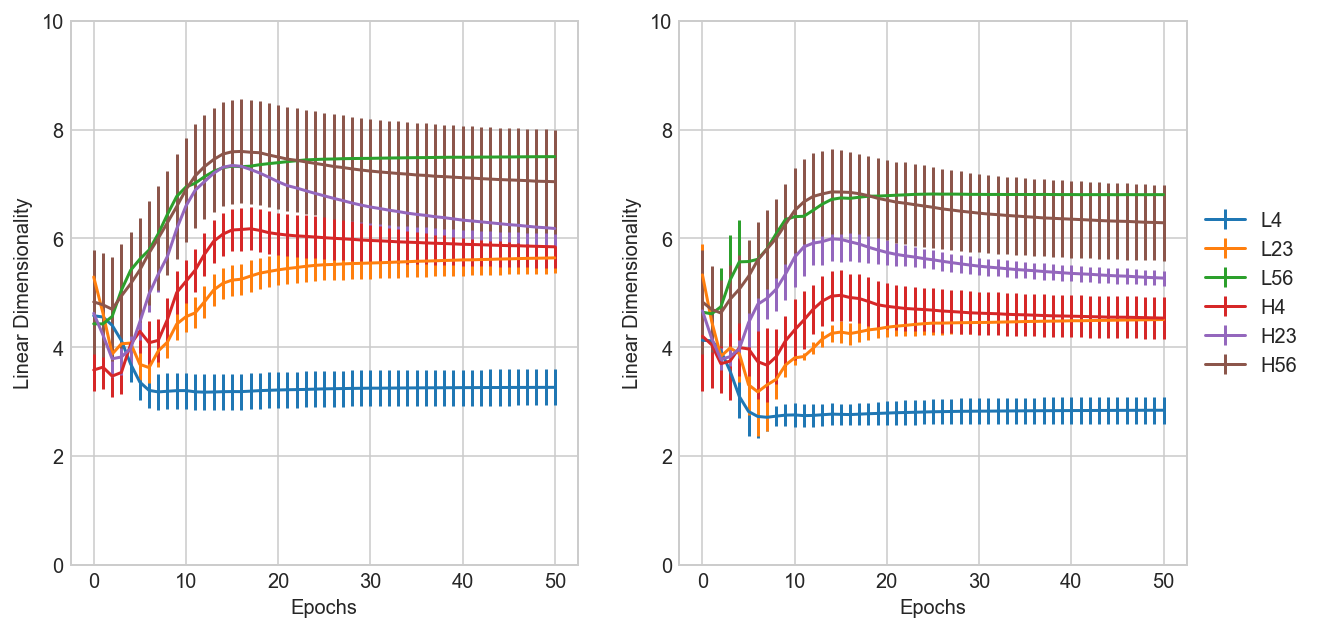

In [48]:
ffLinDim = plt.figure(figsize=(10,5))

plt.subplot(121)
plt.errorbar(np.arange(n_epochs+1),L4_LineDim_meanC,yerr=L4_LineDim_stdC[-1],label='L4',fmt='-')
plt.errorbar(np.arange(n_epochs+1),L23_LineDim_meanC,yerr=L23_LineDim_stdC[-1],label='L23',fmt='-')
plt.errorbar(np.arange(n_epochs+1),L56_LineDim_meanC,yerr=L56_LineDim_stdC[-1],label='L56',fmt='-')
plt.errorbar(np.arange(n_epochs+1),H4_LineDim_meanC,yerr=H4_LineDim_stdC[-1],label='H4',fmt='-')
plt.errorbar(np.arange(n_epochs+1),H23_LineDim_meanC,yerr=H23_LineDim_stdC[-1],label='H23',fmt='-')
plt.errorbar(np.arange(n_epochs+1),H56_LineDim_meanC,yerr=H56_LineDim_stdC[-1],label='H56',fmt='-')
plt.xlabel('Epochs')
plt.ylabel('Linear Dimensionality')
plt.ylim(0,10)

plt.subplot(122)
plt.errorbar(np.arange(n_epochs+1),L4_LineDim_meanS, yerr=L4_LineDim_stdS,label='L4',fmt='-')
plt.errorbar(np.arange(n_epochs+1),L23_LineDim_meanS, yerr=L23_LineDim_stdS,label='L23',fmt='-')
plt.errorbar(np.arange(n_epochs+1),L56_LineDim_meanS, yerr=L56_LineDim_stdS,label='L56',fmt='-')
plt.errorbar(np.arange(n_epochs+1),H4_LineDim_meanS, yerr=H4_LineDim_stdS,label='H4',fmt='-')
plt.errorbar(np.arange(n_epochs+1),H23_LineDim_meanS, yerr=H23_LineDim_stdS,label='H23',fmt='-')
plt.errorbar(np.arange(n_epochs+1),H56_LineDim_meanS, yerr=H56_LineDim_stdS,label='H56',fmt='-')
plt.xlabel('Epochs')
plt.ylabel('Linear Dimensionality')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(0,10)

#### Dimensionality (Non-linear)

In [49]:
def rnnNonLinDim(acts,nTypes=4):
    nEpochs,nSeqs, nRolls, nNeurons = acts.shape
    nSamps = nSeqs*nRolls
    
    dims_mat = np.zeros((nEpochs,nTypes))
        
    for ep in (range(nEpochs)):
        reps = acts[ep]
        
        ## reshape
        actsR = np.zeros((nSeqs*nRolls,nNeurons))
        cnt = 0
        
        for ii in range(nSeqs):
            for jj in range(nRolls):
                
                actsR[cnt] = reps[ii,jj]
                cnt += 1
        
        scaler = StandardScaler()
        actsScaled = scaler.fit_transform(actsR)
        
        dims_mat[ep,0] = CorrInt().fit(actsScaled).dimension_
        dims_mat[ep,1] = DANCo().fit(actsScaled).dimension_
        dims_mat[ep,2] = MiND_ML().fit(actsScaled).dimension_
        dims_mat[ep,3] = MLE().fit(actsScaled).dimension_
        
    return np.mean(dims_mat,-1),dims_mat

In [50]:
L23NonLinDimC = np.zeros((nRuns,n_epochs+1))
L4NonLinDimC = np.zeros((nRuns,n_epochs+1))
L56NonLinDimC = np.zeros((nRuns,n_epochs+1))

H23NonLinDimC = np.zeros((nRuns,n_epochs+1))
H4NonLinDimC = np.zeros((nRuns,n_epochs+1))
H56NonLinDimC = np.zeros((nRuns,n_epochs+1))

L23NonLinDimS = np.zeros((nRuns,n_epochs+1))
L4NonLinDimS = np.zeros((nRuns,n_epochs+1))
L56NonLinDimS = np.zeros((nRuns,n_epochs+1))

H23NonLinDimS = np.zeros((nRuns,n_epochs+1))
H4NonLinDimS = np.zeros((nRuns,n_epochs+1))
H56NonLinDimS = np.zeros((nRuns,n_epochs+1))

In [51]:
L23_ND_matC = {}
L4_ND_matC = {}
L56_ND_matC = {}
H23_ND_matC = {}
H4_ND_matC = {}
H56_ND_matC = {}

L23_ND_matS = {}
L4_ND_matS = {}
L56_ND_matS = {}
H23_ND_matS = {}
H4_ND_matS = {}
H56_ND_matS = {}

In [52]:
for cntr in tqdm(range(nRuns)):
    L23NonLinDimC[cntr], L23_ND_matC[cntr] = rnnNonLinDim(activations_hidden_L23C_np[cntr])
    L4NonLinDimC[cntr], L4_ND_matC[cntr] = rnnNonLinDim(activations_hidden_L4C_np[cntr])
    L56NonLinDimC[cntr], L56_ND_matC[cntr] = rnnNonLinDim(activations_hidden_L56C_np[cntr])

    H23NonLinDimC[cntr], H23_ND_matC[cntr] = rnnNonLinDim(activations_hidden_H23C_np[cntr])
    H4NonLinDimC[cntr], H4_ND_matC[cntr] = rnnNonLinDim(activations_hidden_H4C_np[cntr])
    H56NonLinDimC[cntr], H56_ND_matC[cntr] = rnnNonLinDim(activations_hidden_H56C_np[cntr])

100%|██████████| 5/5 [1:13:29<00:00, 881.93s/it]


In [145]:
for cntr in tqdm(range(nRuns)):
    L23NonLinDimS[cntr], L23_ND_matS[cntr] = rnnNonLinDim(activations_hidden_L23S_np[cntr])
    L4NonLinDimS[cntr], L4_ND_matS[cntr] = rnnNonLinDim(activations_hidden_L4S_np[cntr])
    L56NonLinDimS[cntr], L56_ND_matS[cntr] = rnnNonLinDim(activations_hidden_L56S_np[cntr])

    H23NonLinDimS[cntr], H23_ND_matS[cntr] = rnnNonLinDim(activations_hidden_H23S_np[cntr])
    H4NonLinDimS[cntr], H4_ND_matS[cntr] = rnnNonLinDim(activations_hidden_H4S_np[cntr])
    H56NonLinDimS[cntr], H56_ND_matS[cntr] = rnnNonLinDim(activations_hidden_H56S_np[cntr])

100%|██████████| 5/5 [1:17:18<00:00, 927.75s/it]


In [53]:
L23_NonLineDim_meanC = np.mean(L23NonLinDimC,0)
L4_NonLineDim_meanC = np.mean(L4NonLinDimC,0)
L56_NonLineDim_meanC = np.mean(L56NonLinDimC,0)

H23_NonLineDim_meanC = np.mean(H23NonLinDimC,0)
H4_NonLineDim_meanC = np.mean(H4NonLinDimC,0)
H56_NonLineDim_meanC = np.mean(H56NonLinDimC,0)

L23_NonLineDim_stdC = np.std(L23NonLinDimC,0)
L4_NonLineDim_stdC = np.std(L4NonLinDimC,0)
L56_NonLineDim_stdC = np.std(L56NonLinDimC,0)

H23_NonLineDim_stdC = np.std(H23NonLinDimC,0)
H4_NonLineDim_stdC = np.std(H4NonLinDimC,0)
H56_NonLineDim_stdC = np.std(H56NonLinDimC,0)

In [147]:
L23_NonLineDim_meanS = np.mean(L23NonLinDimS,0)
L4_NonLineDim_meanS = np.mean(L4NonLinDimS,0)
L56_NonLineDim_meanS = np.mean(L56NonLinDimS,0)

H23_NonLineDim_meanS = np.mean(H23NonLinDimS,0)
H4_NonLineDim_meanS = np.mean(H4NonLinDimS,0)
H56_NonLineDim_meanS = np.mean(H56NonLinDimS,0)

L23_NonLineDim_stdS = np.std(L23NonLinDimS,0)
L4_NonLineDim_stdS = np.std(L4NonLinDimS,0)
L56_NonLineDim_stdS = np.std(L56NonLinDimS,0)

H23_NonLineDim_stdS = np.std(H23NonLinDimS,0)
H4_NonLineDim_stdS = np.std(H4NonLinDimS,0)
H56_NonLineDim_stdS = np.std(H56NonLinDimS,0)

(0.0, 8.0)

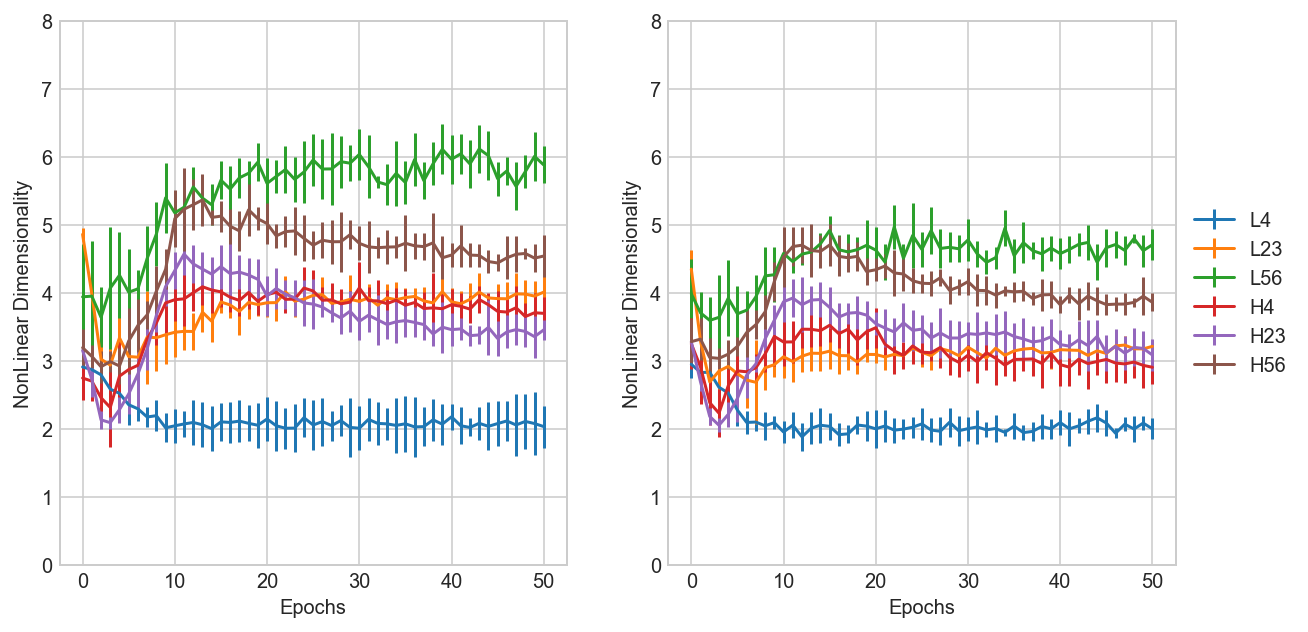

In [148]:
ffNonLinDim = plt.figure(figsize=(10,5))

plt.subplot(121)
plt.errorbar(np.arange(n_epochs+1),L4_NonLineDim_meanC,yerr=L4_NonLineDim_stdC,label='L4',fmt='-')
plt.errorbar(np.arange(n_epochs+1),L23_NonLineDim_meanC,yerr=L23_NonLineDim_stdC,label='L23',fmt='-')
plt.errorbar(np.arange(n_epochs+1),L56_NonLineDim_meanC,yerr=L56_NonLineDim_stdC,label='L56',fmt='-')
plt.errorbar(np.arange(n_epochs+1),H4_NonLineDim_meanC,yerr=H4_NonLineDim_stdC,label='H4',fmt='-')
plt.errorbar(np.arange(n_epochs+1),H23_NonLineDim_meanC,yerr=H23_NonLineDim_stdC,label='H23',fmt='-')
plt.errorbar(np.arange(n_epochs+1),H56_NonLineDim_meanC,yerr=H56_NonLineDim_stdC,label='H56',fmt='-')
plt.xlabel('Epochs')
plt.ylabel('NonLinear Dimensionality')
plt.ylim(0,8)

plt.subplot(122)
plt.errorbar(np.arange(n_epochs+1),L4_NonLineDim_meanS, yerr=L4_NonLineDim_stdS,label='L4',fmt='-')
plt.errorbar(np.arange(n_epochs+1),L23_NonLineDim_meanS, yerr=L23_NonLineDim_stdS,label='L23',fmt='-')
plt.errorbar(np.arange(n_epochs+1),L56_NonLineDim_meanS, yerr=L56_NonLineDim_stdS,label='L56',fmt='-')
plt.errorbar(np.arange(n_epochs+1),H4_NonLineDim_meanS, yerr=H4_NonLineDim_stdS,label='H4',fmt='-')
plt.errorbar(np.arange(n_epochs+1),H23_NonLineDim_meanS, yerr=H23_NonLineDim_stdS,label='H23',fmt='-')
plt.errorbar(np.arange(n_epochs+1),H56_NonLineDim_meanS, yerr=H56_NonLineDim_stdS,label='H56',fmt='-')
plt.xlabel('Epochs')
plt.ylabel('NonLinear Dimensionality')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(0,8)

#### Ration fo Lin. and Non-Lin. dim

In [54]:
L23_dimC = np.zeros((nRuns,n_epochs+1))
L4_dimC = np.zeros((nRuns,n_epochs+1))
L56_dimC = np.zeros((nRuns,n_epochs+1))

H23_dimC = np.zeros((nRuns,n_epochs+1))
H4_dimC = np.zeros((nRuns,n_epochs+1))
H56_dimC = np.zeros((nRuns,n_epochs+1))

L23_dimS = np.zeros((nRuns,n_epochs+1))
L4_dimS = np.zeros((nRuns,n_epochs+1))
L56_dimS = np.zeros((nRuns,n_epochs+1))

H23_dimS = np.zeros((nRuns,n_epochs+1))
H4_dimS = np.zeros((nRuns,n_epochs+1))
H56_dimS = np.zeros((nRuns,n_epochs+1))

In [55]:
for cntr in range(nRuns):
    L23_dimC[cntr] = L23LinDimC[cntr]/L23NonLinDimC[cntr]
    L4_dimC[cntr] = L4LinDimC[cntr]/L4NonLinDimC[cntr]
    L56_dimC[cntr] = L56LinDimC[cntr]/L56NonLinDimC[cntr]
    H23_dimC[cntr] = H23LinDimC[cntr]/H23NonLinDimC[cntr]
    H4_dimC[cntr] = H4LinDimC[cntr]/H4NonLinDimC[cntr]
    H56_dimC[cntr] = H56LinDimC[cntr]/H56NonLinDimC[cntr]
    
    L23_dimS[cntr] = L23LinDimS[cntr]/L23NonLinDimS[cntr]
    L4_dimS[cntr] = L4LinDimS[cntr]/L4NonLinDimS[cntr]
    L56_dimS[cntr] = L56LinDimS[cntr]/L56NonLinDimS[cntr]
    H23_dimS[cntr] = H23LinDimS[cntr]/H23NonLinDimS[cntr]
    H4_dimS[cntr] = H4LinDimS[cntr]/H4NonLinDimS[cntr]
    H56_dimS[cntr] = H56LinDimS[cntr]/H56NonLinDimS[cntr]

(1.0, 2.2)

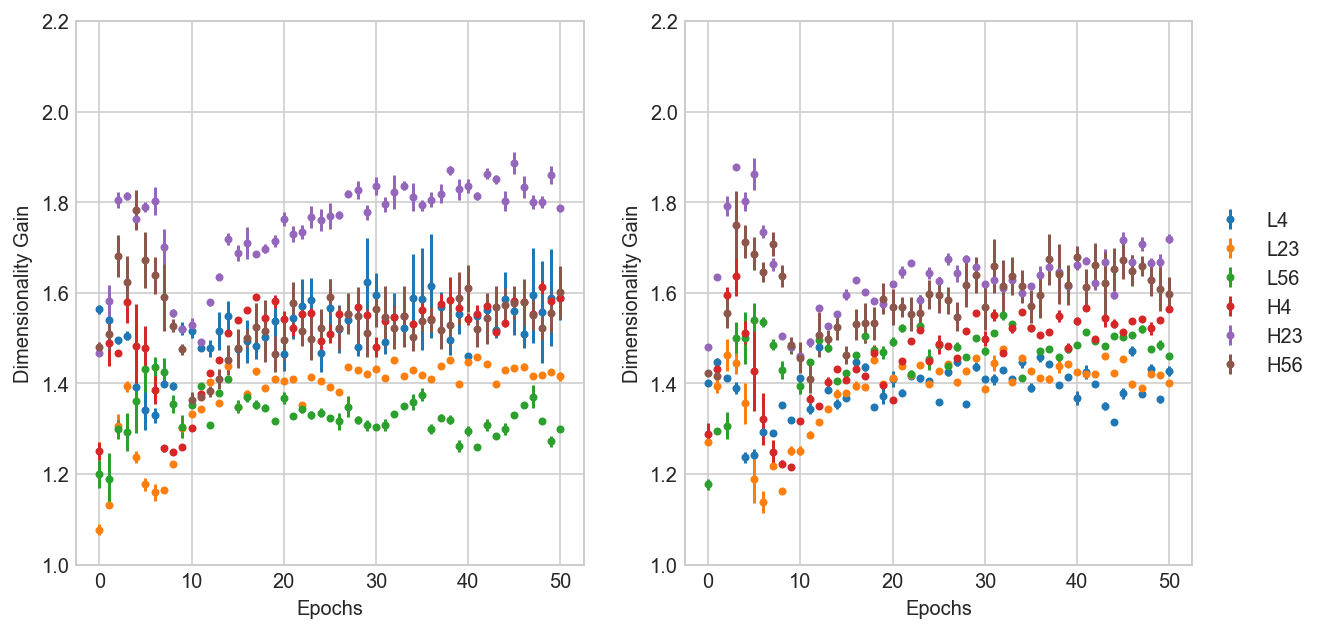

In [269]:
ffTotDim = plt.figure(figsize=(10,5))

plt.subplot(121)
plt.errorbar(np.arange(n_epochs+1),np.mean(L4_dimC,0),yerr=np.var(L4_dimC,0),label='L4',fmt='.')
plt.errorbar(np.arange(n_epochs+1),np.mean(L23_dimC,0),yerr=np.var(L23_dimC,0),label='L23',fmt='.')
plt.errorbar(np.arange(n_epochs+1),np.mean(L56_dimC,0),yerr=np.var(L56_dimC,0),label='L56',fmt='.')
plt.errorbar(np.arange(n_epochs+1),np.mean(H4_dimC,0),yerr=np.var(H4_dimC,0),label='H4',fmt='.')
plt.errorbar(np.arange(n_epochs+1),np.mean(H23_dimC,0),yerr=np.var(H23_dimC,0),label='H23',fmt='.')
plt.errorbar(np.arange(n_epochs+1),np.mean(H56_dimC,0),yerr=np.var(H56_dimC,0),label='H56',fmt='.')
plt.xlabel('Epochs')
plt.ylabel('Dimensionality Gain')
plt.ylim(1,2.2)

plt.subplot(122)
plt.errorbar(np.arange(n_epochs+1),np.mean(L4_dimS,0),yerr=np.var(L4_dimS,0),label='L4',fmt='.')
plt.errorbar(np.arange(n_epochs+1),np.mean(L23_dimS,0),yerr=np.var(L23_dimS,0),label='L23',fmt='.')
plt.errorbar(np.arange(n_epochs+1),np.mean(L56_dimS,0),yerr=np.var(L56_dimS,0),label='L56',fmt='.')
plt.errorbar(np.arange(n_epochs+1),np.mean(H4_dimS,0),yerr=np.var(H4_dimS,0),label='H4',fmt='.')
plt.errorbar(np.arange(n_epochs+1),np.mean(H23_dimS,0),yerr=np.var(H23_dimS,0),label='H23',fmt='.')
plt.errorbar(np.arange(n_epochs+1),np.mean(H56_dimS,0),yerr=np.var(H56_dimS,0),label='H56',fmt='.')
plt.xlabel('Epochs')
plt.ylabel('Dimensionality Gain')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(1,2.2)

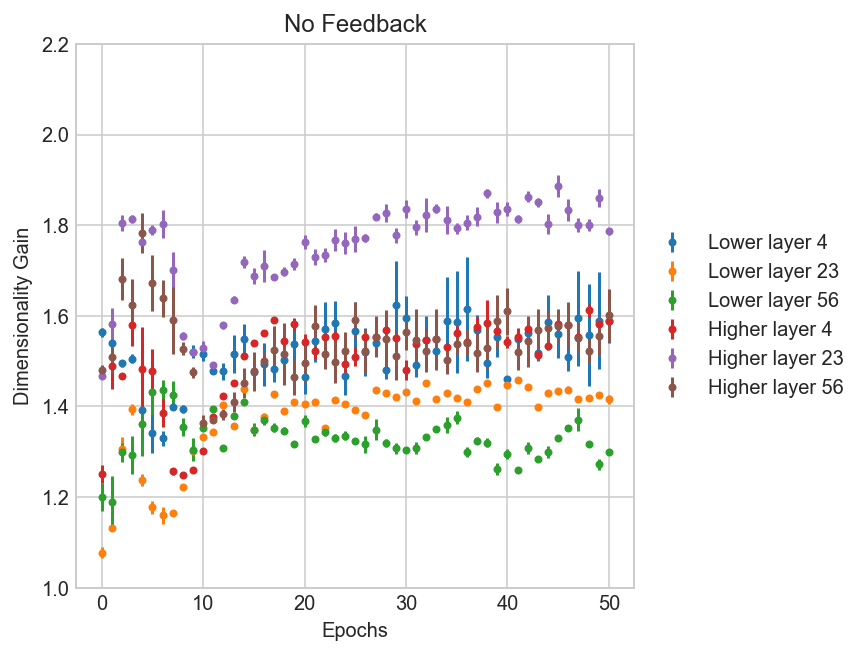

In [272]:
ffTotDim = plt.figure(figsize=(5,5))

plt.subplot(111)
plt.errorbar(np.arange(n_epochs+1),np.mean(L4_dimC,0),yerr=np.var(L4_dimC,0),label='Lower layer 4',fmt='.')
plt.errorbar(np.arange(n_epochs+1),np.mean(L23_dimC,0),yerr=np.var(L23_dimC,0),label='Lower layer 23',fmt='.')
plt.errorbar(np.arange(n_epochs+1),np.mean(L56_dimC,0),yerr=np.var(L56_dimC,0),label='Lower layer 56',fmt='.')
plt.errorbar(np.arange(n_epochs+1),np.mean(H4_dimC,0),yerr=np.var(H4_dimC,0),label='Higher layer 4',fmt='.')
plt.errorbar(np.arange(n_epochs+1),np.mean(H23_dimC,0),yerr=np.var(H23_dimC,0),label='Higher layer 23',fmt='.')
plt.errorbar(np.arange(n_epochs+1),np.mean(H56_dimC,0),yerr=np.var(H56_dimC,0),label='Higher layer 56',fmt='.')
plt.xlabel('Epochs')
plt.ylabel('Dimensionality Gain')
plt.ylim(1,2.2)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('No Feedback')
plt.show()

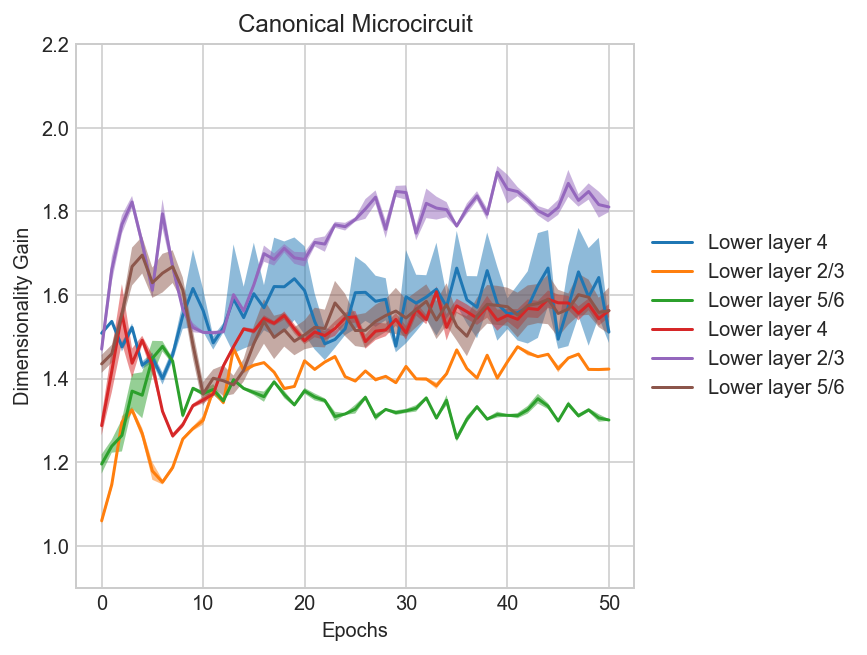

In [56]:
ffTotDim = plt.figure(figsize=(5,5))

plt.subplot(111)

plt.plot(np.arange(n_epochs+1),np.mean(L4_dimC,0),label='Lower layer 4')
plt.fill_between(np.arange(n_epochs+1),np.mean(L4_dimC,0)-np.var(L4_dimC,0),np.mean(L4_dimC,0)+np.var(L4_dimC,0),alpha=0.5)
plt.plot(np.arange(n_epochs+1),np.mean(L23_dimC,0),label='Lower layer 2/3')
plt.fill_between(np.arange(n_epochs+1),np.mean(L23_dimC,0)-np.var(L23_dimC,0),np.mean(L23_dimC,0)+np.var(L23_dimC,0),alpha=0.5)
plt.plot(np.arange(n_epochs+1),np.mean(L56_dimC,0),label='Lower layer 5/6')
plt.fill_between(np.arange(n_epochs+1),np.mean(L56_dimC,0)-np.var(L56_dimC,0),np.mean(L56_dimC,0)+np.var(L56_dimC,0),alpha=0.5)

plt.plot(np.arange(n_epochs+1),np.mean(H4_dimC,0),label='Lower layer 4')
plt.fill_between(np.arange(n_epochs+1),np.mean(H4_dimC,0)-np.var(H4_dimC,0),np.mean(H4_dimC,0)+np.var(H4_dimC,0),alpha=0.5)
plt.plot(np.arange(n_epochs+1),np.mean(H23_dimC,0),label='Lower layer 2/3')
plt.fill_between(np.arange(n_epochs+1),np.mean(H23_dimC,0)-np.var(H23_dimC,0),np.mean(H23_dimC,0)+np.var(H23_dimC,0),alpha=0.5)
plt.plot(np.arange(n_epochs+1),np.mean(H56_dimC,0),label='Lower layer 5/6')
plt.fill_between(np.arange(n_epochs+1),np.mean(H56_dimC,0)-np.var(H56_dimC,0),np.mean(H56_dimC,0)+np.var(H56_dimC,0),alpha=0.5)

plt.xlabel('Epochs')
plt.ylabel('Dimensionality Gain')
plt.ylim(0.9,2.2)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Canonical Microcircuit')
plt.show()

In [57]:
np.save(pp+'L23DG_no-fb',L23_dimC)
np.save(pp+'L4DG_no-fb',L4_dimC)
np.save(pp+'L56DG_no-fb',L56_dimC)
np.save(pp+'H23DG_no-fb',H23_dimC)
np.save(pp+'H4DG_no-fb',H4_dimC)
np.save(pp+'H56DG_no-fb',H56_dimC)

In [274]:
ffTotDim.savefig('Dimensionality-gain-no-fb-across-learning.png',dpi=300,bbox_inches='tight')

#### Noise encoding

In [337]:
delta_L23 = {}
delta_L4 = {}
delta_L56 = {}

delta_H23 = {}
delta_H4 = {}
delta_H56 = {}

In [338]:
for cntr in range(nRuns):
    delta_L23[cntr] = activations_hidden_L23S_np[cntr][:,:,2:] - activations_hidden_L23C_np[cntr][:,:,2:]
    delta_L4[cntr] = activations_hidden_L4S_np[cntr][:,:,2:] - activations_hidden_L4C_np[cntr][:,:,2:]
    delta_L56[cntr] = activations_hidden_L56S_np[cntr][:,:,2:] - activations_hidden_L56C_np[cntr][:,:,2:]
    
    delta_H23[cntr] = activations_hidden_H23S_np[cntr][:,:,2:] - activations_hidden_H23C_np[cntr][:,:,2:]
    delta_H4[cntr] = activations_hidden_H4S_np[cntr][:,:,2:] - activations_hidden_H4C_np[cntr][:,:,2:]
    delta_H56[cntr] = activations_hidden_H56S_np[cntr][:,:,2:] - activations_hidden_H56C_np[cntr][:,:,2:]

In [339]:
norm_delta_L23 = {}
norm_delta_L4 = {}
norm_delta_L56 = {}

norm_delta_H23 = {}
norm_delta_H4 = {}
norm_delta_H56 = {}

In [340]:
norm_norm_delta_L23 = {}
norm_norm_delta_L4 = {}
norm_norm_delta_L56 = {}

norm_norm_delta_H23 = {}
norm_norm_delta_H4 = {}
norm_norm_delta_H56 = {}

In [341]:
for cntr in range(nRuns):
    norm_delta_L23[cntr] = norm(delta_L23[cntr],axis= -1)
    norm_delta_L4[cntr] = norm(delta_L4[cntr],axis= -1)
    norm_delta_L56[cntr] = norm(delta_L56[cntr],axis= -1)
    
    norm_delta_H23[cntr] = norm(delta_H23[cntr],axis= -1)
    norm_delta_H4[cntr] = norm(delta_H4[cntr],axis= -1)
    norm_delta_H56[cntr] = norm(delta_H56[cntr],axis= -1)
    
    norm_norm_delta_L23[cntr] = norm_delta_L23[cntr]/norm(activations_hidden_L23C_np[cntr][:,:,2:],axis= -1)
    norm_norm_delta_L4[cntr] = norm_delta_L4[cntr]/norm(activations_hidden_L4C_np[cntr][:,:,2:],axis= -1)
    norm_norm_delta_L56[cntr] = norm_delta_L56[cntr]/norm(activations_hidden_L56C_np[cntr][:,:,2:],axis= -1)
    
    norm_norm_delta_H23[cntr] = norm_delta_H23[cntr]/norm(activations_hidden_H23C_np[cntr][:,:,2:],axis= -1)
    norm_norm_delta_H4[cntr] = norm_delta_H4[cntr]/norm(activations_hidden_H4C_np[cntr][:,:,2:],axis= -1)
    norm_norm_delta_H56[cntr] = norm_delta_H56[cntr]/norm(activations_hidden_H56C_np[cntr][:,:,2:],axis= -1)

In [342]:
nnnd_L4 = np.zeros((nRuns,n_epochs+1,nSteps-2))
nnnd_L23 = np.zeros((nRuns,n_epochs+1,nSteps-2))
nnnd_L56 = np.zeros((nRuns,n_epochs+1,nSteps-2))

nnnd_H4 = np.zeros((nRuns,n_epochs+1,nSteps-2))
nnnd_H23 = np.zeros((nRuns,n_epochs+1,nSteps-2))
nnnd_H56 = np.zeros((nRuns,n_epochs+1,nSteps-2))

In [343]:
for r in range(nRuns):
        
    for step in range(nSteps-2):
        nnnd_L4[r,:,step] = norm(norm_norm_delta_L4[r][:,:,step],axis=-1)
        nnnd_L23[r,:,step] = norm(norm_norm_delta_L23[r][:,:,step],axis=-1)
        nnnd_L56[r,:,step] = norm(norm_norm_delta_L56[r][:,:,step],axis=-1)

        nnnd_H4[r,:,step] = norm(norm_norm_delta_H4[r][:,:,step],axis=-1)
        nnnd_H23[r,:,step] = norm(norm_norm_delta_H23[r][:,:,step],axis=-1)
        nnnd_H56[r,:,step] = norm(norm_norm_delta_H56[r][:,:,step],axis=-1)

In [344]:
nnnd_L4_mean = np.mean(nnnd_L4,axis=0)/batch_size_analyses
nnnd_L23_mean = np.mean(nnnd_L23,axis=0)/batch_size_analyses
nnnd_L56_mean = np.mean(nnnd_L56,axis=0)/batch_size_analyses

nnnd_H4_mean = np.mean(nnnd_H4,axis=0)/batch_size_analyses
nnnd_H23_mean = np.mean(nnnd_H23,axis=0)/batch_size_analyses
nnnd_H56_mean = np.mean(nnnd_H56,axis=0)/batch_size_analyses

In [345]:
nnnd_L4_std = np.var(nnnd_L4,axis=0)
nnnd_L23_std = np.var(nnnd_L23,axis=0)
nnnd_L56_std = np.var(nnnd_L56,axis=0)

nnnd_H4_std = np.var(nnnd_H4,axis=0)
nnnd_H23_std = np.var(nnnd_H23,axis=0)
nnnd_H56_std = np.var(nnnd_H56,axis=0)

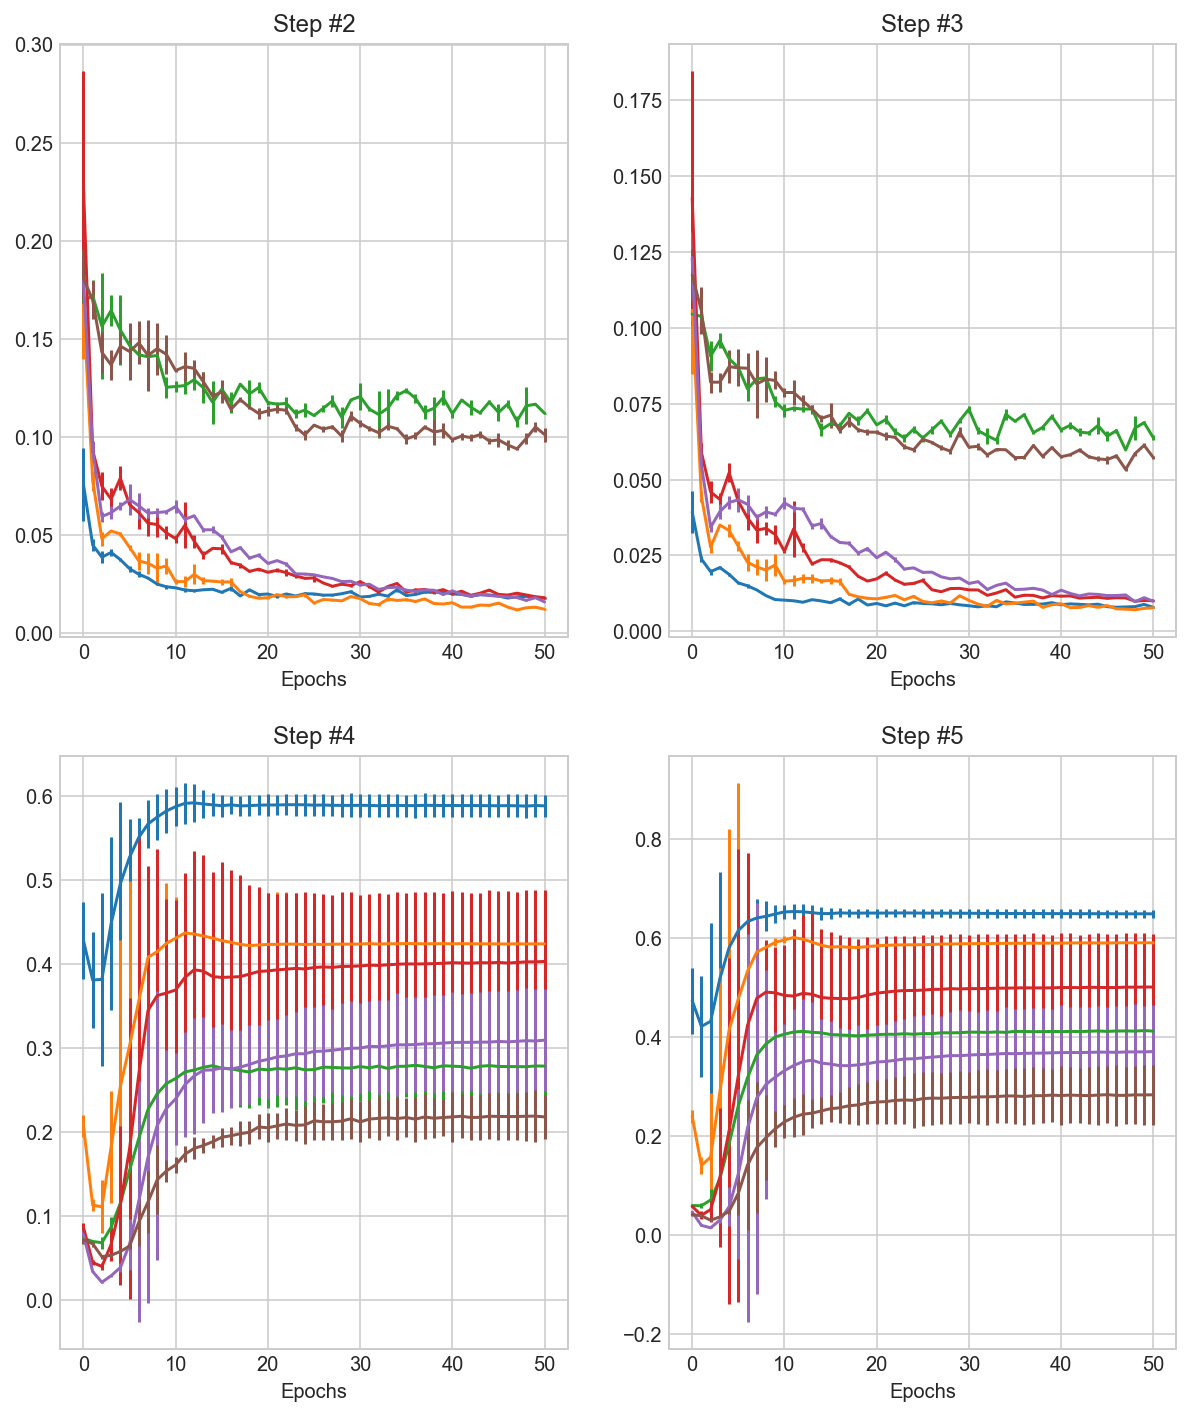

In [346]:
ff = plt.figure(figsize=(10,12))

for ii in range(nSteps-2):
    plt.subplot(2,2,ii+1)
    plt.errorbar(np.arange(n_epochs+1),nnnd_L4_mean[:,ii], yerr=nnnd_L4_std[:,ii], label='L4', fmt='-')
    plt.errorbar(np.arange(n_epochs+1),nnnd_L23_mean[:,ii], yerr=nnnd_L23_std[:,ii], label='L23', fmt='-')
    plt.errorbar(np.arange(n_epochs+1),nnnd_L56_mean[:,ii], yerr=nnnd_L56_std[:,ii], label='L56', fmt='-')
    plt.errorbar(np.arange(n_epochs+1),nnnd_H4_mean[:,ii], yerr=nnnd_H4_std[:,ii], label='H4', fmt='-')
    plt.errorbar(np.arange(n_epochs+1),nnnd_H23_mean[:,ii], yerr=nnnd_H23_std[:,ii], label='H23', fmt='-')
    plt.errorbar(np.arange(n_epochs+1),nnnd_H56_mean[:,ii], yerr=nnnd_H56_std[:,ii], label='H56', fmt='-')
    plt.xlabel('Epochs')
    plt.title('Step #'+str(ii+2))
    if ii == nSteps-1:
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

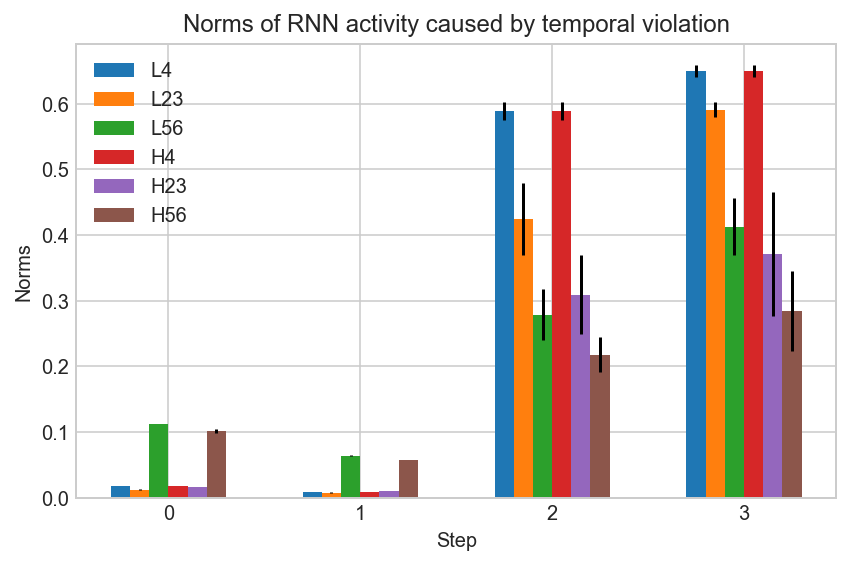

In [347]:
labels = ['Step 2', 'Step 3', 'Step 4', 'Step 5']

x = np.arange(len(labels))  # the label locations
width = 0.1  # the width of the bars
height = 0.2

fig, ax = plt.subplots()
rects_L4 = ax.bar(x - 5*width/2, nnnd_L4_mean[-1], yerr=nnnd_L4_std[-1], width=width, label='L4')
rects_L23 = ax.bar(x - 3*width/2, nnnd_L23_mean[-1], yerr=nnnd_L23_std[-1], width=width, label='L23')
rects_L56 = ax.bar(x - width/2, nnnd_L56_mean[-1], yerr=nnnd_L56_std[-1], width=width, label='L56')

rects_H4 = ax.bar(x + width/2, nnnd_L4_mean[-1], yerr=nnnd_L4_std[-1], width=width, label='H4')
rects_H23 = ax.bar(x + 3*width/2, nnnd_H23_mean[-1], yerr=nnnd_H23_std[-1], width=width, label='H23')
rects_H56 = ax.bar(x + 5*width/2, nnnd_H56_mean[-1], yerr=nnnd_H56_std[-1], width=width, label='H56')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Norms of RNN activity caused by temporal violation')
ax.set_xticks(x)
ax.legend()
ax.set_ylabel("Norms")
ax.set_xlabel('Step')

fig.tight_layout()

plt.show()

#### Eigenspectrum decay

In [348]:
from scipy.stats import linregress

In [349]:
def eigendpectrumDecay(acts):
    nEpochs,nSeqs, nRolls, nNeurons = acts.shape
    nSamps = nSeqs*nRolls
    
    alphas = np.zeros(nEpochs)
    
    if nNeurons<nSamps:
        dd = nNeurons
    else:
        dd = nSamps-1
    
    eig_mat = np.zeros((nEpochs,dd))
        
    for ep in tqdm(range(nEpochs)):
        reps = acts[ep]
        
        ## reshape
        actsR = np.zeros((nSeqs*nRolls,nNeurons))
        cnt = 0
        
        for ii in range(nSeqs):
            for jj in range(nRolls):
                
                actsR[cnt] = reps[ii,jj]
                cnt += 1
        
        scaler = StandardScaler()
        actsScaled = scaler.fit_transform(actsR)
#         actsScaled = actsR
        cov = actsScaled.T@actsScaled
        eig_mat[ep] = eigvals(cov)[:dd]
        
        alphas[ep], b, r, _, _ = linregress(np.log(np.arange(1,dd+1)),np.log(np.abs(eig_mat[ep]))) 
    
    return alphas*-1

In [350]:
egdL4 = np.zeros((nRuns,n_epochs+1))
egdL23 = np.zeros((nRuns,n_epochs+1))
egdL56 = np.zeros((nRuns,n_epochs+1))

egdH4 = np.zeros((nRuns,n_epochs+1))
egdH23 = np.zeros((nRuns,n_epochs+1))
egdH56 = np.zeros((nRuns,n_epochs+1))

In [351]:
for cntr in range(nRuns):
    egdL23[cntr] = eigendpectrumDecay(activations_hidden_L23C_np[cntr])
    egdL4[cntr] = eigendpectrumDecay(activations_hidden_L4C_np[cntr])
    egdL56[cntr] = eigendpectrumDecay(activations_hidden_L56C_np[cntr])
    egdH23[cntr] = eigendpectrumDecay(activations_hidden_H23C_np[cntr])
    egdH4[cntr] = eigendpectrumDecay(activations_hidden_H4C_np[cntr])
    egdH56[cntr] = eigendpectrumDecay(activations_hidden_H56C_np[cntr])

100%|██████████| 51/51 [00:00<00:00, 657.10it/s]


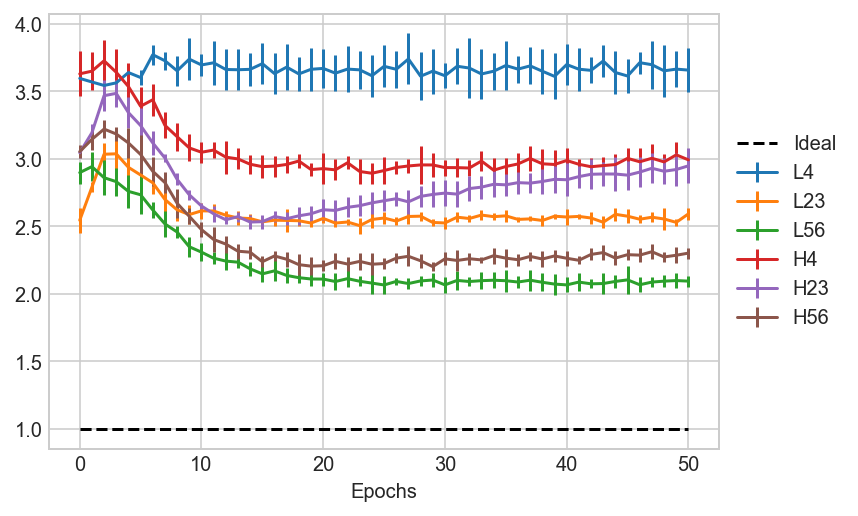

In [352]:
ff_egd = plt.figure()
plt.errorbar(np.arange(n_epochs+1),np.mean(egdL4,0), yerr=np.std(egdL4,0), label='L4', fmt='-')
plt.errorbar(np.arange(n_epochs+1),np.mean(egdL23,0), yerr=np.std(egdL23,0), label='L23', fmt='-')
plt.errorbar(np.arange(n_epochs+1),np.mean(egdL56,0), yerr=np.std(egdL56,0), label='L56', fmt='-')
plt.errorbar(np.arange(n_epochs+1),np.mean(egdH4,0), yerr=np.std(egdH4,0), label='H4', fmt='-')
plt.errorbar(np.arange(n_epochs+1),np.mean(egdH23,0), yerr=np.std(egdH23,0), label='H23', fmt='-')
plt.errorbar(np.arange(n_epochs+1),np.mean(egdH56,0), yerr=np.std(egdH56,0), label='H56', fmt='-')
plt.plot(np.ones(n_epochs+1),'--',c='k',label='Ideal')
plt.xlabel('Epochs')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [415]:
ff_egd.savefig('eigenspectrum-decay-repeated-runs-no-fb.png',dpi=300,bbox_inches='tight')

#### Accuracies

In [353]:
labels_clean = np.argmax(yCleanSeqs[0]@template[0].T,-1)[:,2:]
labels_surp = np.argmax(ySurpSeqs[0]@template[0].T,-1)[:,2:]

In [354]:
predsC = {}
predsS = {}

accsC = np.zeros((nRuns,n_epochs+1))
accsS = np.zeros((nRuns,n_epochs+1))

In [355]:
for cntr in range(nRuns):
    predsC[cntr] = np.argmax(activations_outC_np[cntr]@template[cntr].T,-1)[:,:,2:]
    predsS[cntr] = np.argmax(activations_outS_np[cntr]@template[cntr].T,-1)[:,:,2:]
    
    accsC[cntr] = np.sum(np.sum(((labels_clean - predsC[cntr])==0)*1,-1),-1)/24
    accsS[cntr] = np.sum(np.sum(((labels_clean - predsS[cntr])==0)*1,-1),-1)/24

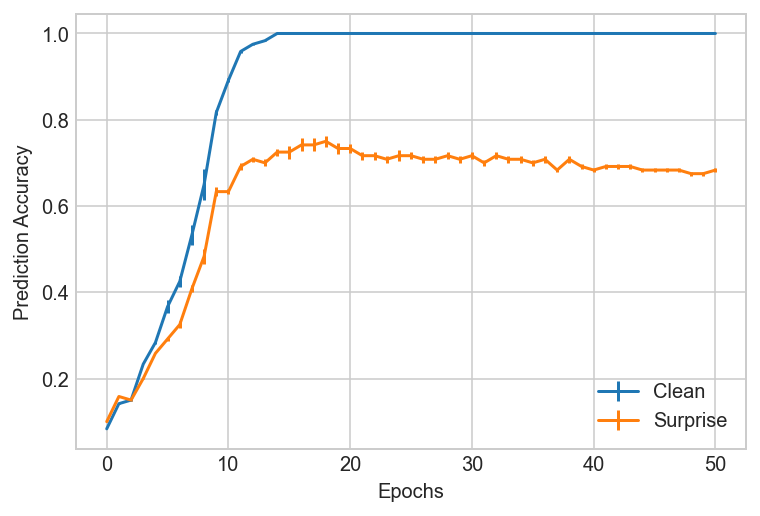

In [356]:
plt.errorbar(np.arange(n_epochs+1),np.mean(accsC,0),yerr=np.var(accsC,0),fmt='-',label='Clean')
plt.errorbar(np.arange(n_epochs+1),np.mean(accsS,0),yerr=np.var(accsS,0),fmt='-',label='Surprise')
plt.xlabel('Epochs')
plt.ylabel('Prediction Accuracy')
plt.legend()

### Spatial Violations

In [357]:
from numpy.random import normal

In [358]:
noise_stds = np.linspace(0,5,6)

In [359]:
noiseSeqs = {}

In [360]:
for cntr in range(nRuns):
    for nn, noise in enumerate(noise_stds):
        noiseSeqs[cntr,nn] = cleanSeqs[cntr] + normal(0,noise,cleanSeqs[cntr].shape)

In [361]:
noisy_loader_analyses = {}

for cntr in range(nRuns):
    for nn, noise in enumerate(noise_stds):
        noisy_loader_analyses[cntr,nn] = makeTensorLoaders((noiseSeqs[cntr,nn],yCleanSeqs[cntr],
                                                            eClean,pClean,surpClean),batch_size_analyses,shuffle=False)

In [362]:
activations_noisy_L23_np = {}
activations_noisy_L4_np = {}
activations_noisy_L56_np = {}

activations_noisy_H23_np = {}
activations_noisy_H4_np = {}
activations_noisy_H56_np = {}

activations_out_noisy_np = {}

In [363]:
for cntr in range(nRuns):
    for nn, noise in enumerate(noise_stds):
        activations_noisy_L23_np[cntr,nn] = np.zeros((n_epochs+1,nStates_surp,nSteps,pop_list[1]*n_latent))
        activations_noisy_L4_np[cntr,nn] = np.zeros((n_epochs+1,nStates_surp,nSteps,pop_list[0]*n_latent))
        activations_noisy_L56_np[cntr,nn] = np.zeros((n_epochs+1,nStates_surp,nSteps,pop_list[2]*n_latent))

        activations_noisy_H23_np[cntr,nn] = np.zeros((n_epochs+1,nStates_surp,nSteps,pop_list[1]*n_latent))
        activations_noisy_H4_np[cntr,nn] = np.zeros((n_epochs+1,nStates_surp,nSteps,pop_list[0]*n_latent))
        activations_noisy_H56_np[cntr,nn] = np.zeros((n_epochs+1,nStates_surp,nSteps,pop_list[2]*n_latent))

        activations_out_noisy_np[cntr,nn] = np.zeros((n_epochs+1,nStates_surp,nSteps,dim))

In [364]:
for cntr in range(nRuns):
    
    
    for e in tqdm(range(n_epochs+1)):

        ## Load model
        model[cntr].load_state_dict(torch.load(pp_pts[cntr]+'predRNN_epoch_'+str(e)+'.pt'))
        model[cntr].eval()
        
        for nn, noise in enumerate(noise_stds):
            
            cntN = 0

            ## Pass clean samples
            for dataN, f_targetN, lastEventN, surprisePositionN, surpriseBinaryN in noisy_loader_analyses[cntr,nn]:

                if train_on_gpu:
                    dataN, f_targetN = dataN.float().cuda(), f_targetN.float().cuda()
                else: dataN, f_targetN = dataN.float(), f_targetN.float()

                targetN = f_targetN

                output_predN, RNN_outputsN, feedbackDiffsN, projInterAreaN = model[cntr](dataN)
                lossN = reconLoss(output_predN[:,2:],targetN[:,2:])

                ## Collect activations  
                act_hidden_L23N = np.squeeze(RNN_outputsN[0].detach().cpu().numpy())
                act_hidden_L4N = np.squeeze(RNN_outputsN[1].detach().cpu().numpy())
                act_hidden_L56N = np.squeeze(RNN_outputsN[2].detach().cpu().numpy())

                act_hidden_H23N = np.squeeze(RNN_outputsN[3].detach().cpu().numpy())
                act_hidden_H4N = np.squeeze(RNN_outputsN[4].detach().cpu().numpy())
                act_hidden_H56N = np.squeeze(RNN_outputsN[5].detach().cpu().numpy())

                output_predN = np.squeeze(output_predN.detach().cpu().numpy())

                for i in range(batch_size_analyses):
                    if i < len(dataN):
                        label = targetN.data[i]

                        activations_noisy_L23_np[cntr,nn][e,cntN] = act_hidden_L23N[i]
                        activations_noisy_L4_np[cntr,nn][e,cntN] = act_hidden_L4N[i]
                        activations_noisy_L56_np[cntr,nn][e,cntN] = act_hidden_L56N[i]

                        activations_noisy_H23_np[cntr,nn][e,cntN] = act_hidden_H23N[i]
                        activations_noisy_H4_np[cntr,nn][e,cntN] = act_hidden_H4N[i]
                        activations_noisy_H56_np[cntr,nn][e,cntN] = act_hidden_H56N[i]

                        activations_out_noisy_np[cntr,nn][e,cntN] = output_predN[i]

                        cntN += 1

100%|██████████| 51/51 [00:04<00:00, 10.95it/s]


In [365]:
predsN = {}

accsN = np.zeros((nRuns,len(noise_stds),n_epochs+1))

In [366]:
for cntr in range(nRuns):
    for nn, noise in enumerate(noise_stds):
        predsN[cntr,nn] = np.argmax(activations_out_noisy_np[cntr,nn]@template[cntr].T,-1)[:,:,2:]
        accsN[cntr,nn] = np.sum(np.sum(((labels_clean - predsN[cntr,nn])==0)*1,-1),-1)/24

In [416]:
from matplotlib.cm import get_cmap
name = "Dark2_r"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
colors = cmap.colors  # type: list

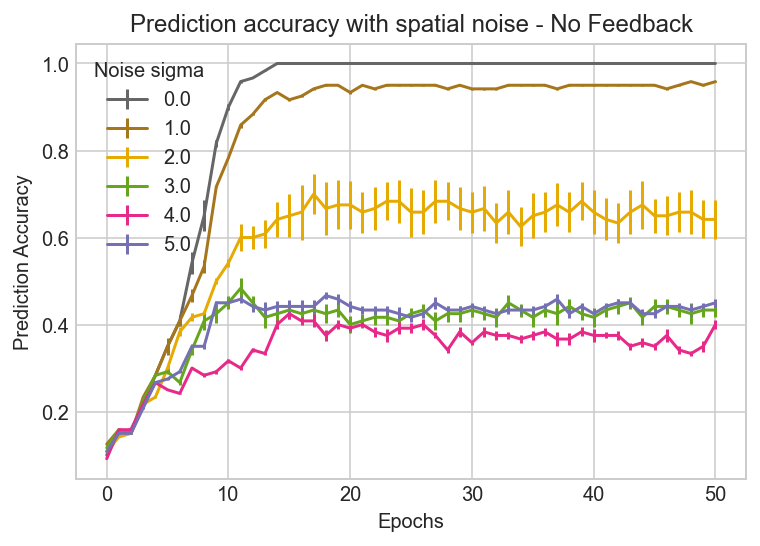

In [417]:
fpredspat = plt.figure()
for nn, noise in enumerate(noise_stds):
    plt.errorbar(np.arange(n_epochs+1),np.mean(accsN[:,nn],0),yerr=np.var(accsN[:,nn],0),fmt='-',label=np.round(noise,2),
                c=colors[nn])
plt.xlabel('Epochs')
plt.ylabel('Prediction Accuracy')
plt.legend(title="Noise sigma")
plt.title('Prediction accuracy with spatial noise - No Feedback')
plt.show()

In [368]:
fpredspat.savefig('repeated-runs-pred-acc-spatial-noise-no-fb.png',dpi=300,bbox_inches='tight')

#### Noisy Decoding

In [369]:
L23_noisy_pca = {}
L4_noisy_pca = {}
L56_noisy_pca = {}

H23_noisy_pca = {}
H4_noisy_pca = {}
H56_noisy_pca = {}

In [370]:
for cntr in range(nRuns):
    for nn, noise in enumerate(noise_stds):
        L23_noisy_pca[cntr,nn], _ = repsPCA(activations_noisy_L23_np[cntr,nn])
        L4_noisy_pca[cntr,nn], _ = repsPCA(activations_noisy_L4_np[cntr,nn])
        L56_noisy_pca[cntr,nn], _ = repsPCA(activations_noisy_L56_np[cntr,nn])
        
        H23_noisy_pca[cntr,nn], _ = repsPCA(activations_noisy_H23_np[cntr,nn])
        H4_noisy_pca[cntr,nn], _ = repsPCA(activations_noisy_H4_np[cntr,nn])
        H56_noisy_pca[cntr,nn], _ = repsPCA(activations_noisy_H56_np[cntr,nn])

100%|██████████| 51/51 [00:00<00:00, 984.71it/s]


#### Image Decoding

In [371]:
def repsDecodeSupervisedImage(rnnActs,labels,clf='svm',io='in'):
    nEpochs, nSamps, nNeurons = rnnActs.shape
    decode_dict = {}
    
    if io == 'in':
        nClasses = nStates_reg
    elif io == 'out':
        nClasses = nStates_tot
    
    reps_preds_probs = np.zeros((nEpochs,nSamps,nClasses))
    
    for ep in (range(nEpochs)):
        repsR = rnnActs[ep]
        
        ## Decoding
        if clf=='svm':
            clfR = SVC(kernel='linear',probability=True).fit(repsR,labels)
        elif clf=='logistic':
            clfR = LogisticRegression().fit(repsR,labels)
        elif clf=='perceptron':
            clfR = Perceptron().fit(repsR,labels)
        
        reps_preds_probs[ep] = clfR.predict_proba(repsR)
        decode_dict[str(ep)] = clfR
        
    return reps_preds_probs, decode_dict

#### Image In

In [372]:
noisy_L23img_inPC = {}
noisy_L4img_inPC = {}
noisy_L56img_inPC = {}

noisy_H23img_inPC = {}
noisy_H4img_inPC = {}
noisy_H56img_inPC = {}

In [373]:
for cntr in tqdm(range(nRuns)):
    for nn, noise in enumerate(noise_stds):
    
        for d in dims23:
            noisy_L23img_inPC[cntr,nn,d], _ = repsDecodeSupervisedImage(L23_noisy_pca[cntr,nn][:,:,:d],labelMtxC[:,0])
            noisy_H23img_inPC[cntr,nn,d], _ = repsDecodeSupervisedImage(H23_noisy_pca[cntr,nn][:,:,:d],labelMtxC[:,0])

        for d in dims4:
            noisy_L4img_inPC[cntr,nn,d], _ = repsDecodeSupervisedImage(L4_noisy_pca[cntr,nn][:,:,:d],labelMtxC[:,0])
            noisy_H4img_inPC[cntr,nn,d], _ = repsDecodeSupervisedImage(H4_noisy_pca[cntr,nn][:,:,:d],labelMtxC[:,0])

        for d in dims56:
            noisy_L56img_inPC[cntr,nn,d], _ = repsDecodeSupervisedImage(L56_noisy_pca[cntr,nn][:,:,:d],labelMtxC[:,0])      
            noisy_H56img_inPC[cntr,nn,d], _ = repsDecodeSupervisedImage(H56_noisy_pca[cntr,nn][:,:,:d],labelMtxC[:,0])

100%|██████████| 5/5 [01:22<00:00, 16.57s/it]


In [374]:
noisy_preds_L23img_inPC = {}
noisy_preds_L4img_inPC = {}
noisy_preds_L56img_inPC = {}

noisy_preds_H23img_inPC = {}
noisy_preds_H4img_inPC = {}
noisy_preds_H56img_inPC = {}

In [375]:
noisy_accs_L23img_inPC = {}
noisy_accs_L4img_inPC = {}
noisy_accs_L56img_inPC = {}

noisy_accs_H23img_inPC = {}
noisy_accs_H4img_inPC = {}
noisy_accs_H56img_inPC = {}

In [376]:
for cntr in range(nRuns):
    
    for ep in range(n_epochs+1):
        
        for nn, noise in enumerate(noise_stds):
        
            for d in dims23:
                noisy_preds_L23img_inPC[cntr,nn,d,ep] = np.argmax(noisy_L23img_inPC[cntr,nn,d][ep],axis=-1)
                noisy_preds_H23img_inPC[cntr,nn,d,ep] = np.argmax(noisy_H23img_inPC[cntr,nn,d][ep],axis=-1)

                noisy_accs_L23img_inPC[cntr,nn,d,ep] = accuracy_score(labelMtxC[:,0],noisy_preds_L23img_inPC[cntr,nn,d,ep])
                noisy_accs_H23img_inPC[cntr,nn,d,ep] = accuracy_score(labelMtxC[:,0],noisy_preds_H23img_inPC[cntr,nn,d,ep])

            for d in dims4:
                noisy_preds_L4img_inPC[cntr,nn,d,ep] = np.argmax(noisy_L4img_inPC[cntr,nn,d][ep],axis=-1)
                noisy_preds_H4img_inPC[cntr,nn,d,ep] = np.argmax(noisy_H4img_inPC[cntr,nn,d][ep],axis=-1)

                noisy_accs_L4img_inPC[cntr,nn,d,ep] = accuracy_score(labelMtxC[:,0],noisy_preds_L4img_inPC[cntr,nn,d,ep])
                noisy_accs_H4img_inPC[cntr,nn,d,ep] = accuracy_score(labelMtxC[:,0],noisy_preds_H4img_inPC[cntr,nn,d,ep])

            for d in dims56:
                noisy_preds_L56img_inPC[cntr,nn,d,ep] = np.argmax(noisy_L56img_inPC[cntr,nn,d][ep],axis=-1)
                noisy_preds_H56img_inPC[cntr,nn,d,ep] = np.argmax(noisy_H56img_inPC[cntr,nn,d][ep],axis=-1)

                noisy_accs_L56img_inPC[cntr,nn,d,ep] = accuracy_score(labelMtxC[:,0],noisy_preds_L56img_inPC[cntr,nn,d,ep])
                noisy_accs_H56img_inPC[cntr,nn,d,ep] = accuracy_score(labelMtxC[:,0],noisy_preds_H56img_inPC[cntr,nn,d,ep])

In [377]:
noisy_tensor_accs_L23img_inPC = np.zeros((nRuns,len(noise_stds),len(dims23),n_epochs+1))
noisy_tensor_accs_L4img_inPC = np.zeros((nRuns,len(noise_stds),len(dims4),n_epochs+1))
noisy_tensor_accs_L56img_inPC = np.zeros((nRuns,len(noise_stds),len(dims56),n_epochs+1))

noisy_tensor_accs_H23img_inPC = np.zeros((nRuns,len(noise_stds),len(dims23),n_epochs+1))
noisy_tensor_accs_H4img_inPC = np.zeros((nRuns,len(noise_stds),len(dims4),n_epochs+1))
noisy_tensor_accs_H56img_inPC = np.zeros((nRuns,len(noise_stds),len(dims56),n_epochs+1))

In [378]:
for ii in range(nRuns):
    
    for kk in range(n_epochs+1):
        
        for nn, noise in enumerate(noise_stds):
        
            for jj,d in enumerate(dims23):
                noisy_tensor_accs_L23img_inPC[ii,nn,jj,kk] = noisy_accs_L23img_inPC[ii,nn,d,kk]
                noisy_tensor_accs_H23img_inPC[ii,nn,jj,kk] = noisy_accs_H23img_inPC[ii,nn,d,kk]

            for jj,d in enumerate(dims4):
                noisy_tensor_accs_L4img_inPC[ii,nn,jj,kk] = noisy_accs_L4img_inPC[ii,nn,d,kk]
                noisy_tensor_accs_H4img_inPC[ii,nn,jj,kk] = noisy_accs_H4img_inPC[ii,nn,d,kk]

            for jj,d in enumerate(dims56):            
                noisy_tensor_accs_L56img_inPC[ii,nn,jj,kk] = noisy_accs_L56img_inPC[ii,nn,d,kk]            
                noisy_tensor_accs_H56img_inPC[ii,nn,jj,kk] = noisy_accs_H56img_inPC[ii,nn,d,kk]

In [379]:
noisy_mean_accs_L4img_inPC = np.zeros((len(noise_stds),len(dims4),n_epochs+1))
noisy_mean_accs_L23img_inPC = np.zeros((len(noise_stds),len(dims23),n_epochs+1))
noisy_mean_accs_L56img_inPC = np.zeros((len(noise_stds),len(dims56),n_epochs+1))

noisy_mean_accs_H4img_inPC = np.zeros((len(noise_stds),len(dims4),n_epochs+1))
noisy_mean_accs_H23img_inPC = np.zeros((len(noise_stds),len(dims23),n_epochs+1))
noisy_mean_accs_H56img_inPC = np.zeros((len(noise_stds),len(dims56),n_epochs+1))

noisy_std_accs_L4img_inPC = np.zeros((len(noise_stds),len(dims4),n_epochs+1))
noisy_std_accs_L23img_inPC = np.zeros((len(noise_stds),len(dims23),n_epochs+1))
noisy_std_accs_L56img_inPC = np.zeros((len(noise_stds),len(dims56),n_epochs+1))

noisy_std_accs_H4img_inPC = np.zeros((len(noise_stds),len(dims4),n_epochs+1))
noisy_std_accs_H23img_inPC = np.zeros((len(noise_stds),len(dims23),n_epochs+1))
noisy_std_accs_H56img_inPC = np.zeros((len(noise_stds),len(dims56),n_epochs+1))

In [380]:
for ep in range(n_epochs+1):
    
    for nn, noise in enumerate(noise_stds):
    
        for dd, dim in enumerate(dims23):
            noisy_mean_accs_L23img_inPC[nn,dd,ep] = np.mean(noisy_tensor_accs_L23img_inPC[:,nn,dd,ep])
            noisy_mean_accs_H23img_inPC[nn,dd,ep] = np.mean(noisy_tensor_accs_H23img_inPC[:,nn,dd,ep])

            noisy_std_accs_L23img_inPC[nn,dd,ep] = np.var(noisy_tensor_accs_L23img_inPC[:,nn,dd,ep])
            noisy_std_accs_H23img_inPC[nn,dd,ep] = np.var(noisy_tensor_accs_H23img_inPC[:,nn,dd,ep])

        for dd, dim in enumerate(dims4):
            noisy_mean_accs_L4img_inPC[nn,dd,ep] = np.mean(noisy_tensor_accs_L4img_inPC[:,nn,dd,ep])
            noisy_mean_accs_H4img_inPC[nn,dd,ep] = np.mean(noisy_tensor_accs_H4img_inPC[:,nn,dd,ep])

            noisy_std_accs_L4img_inPC[nn,dd,ep] = np.var(noisy_tensor_accs_L4img_inPC[:,nn,dd,ep])
            noisy_std_accs_H4img_inPC[nn,dd,ep] = np.var(noisy_tensor_accs_H4img_inPC[:,nn,dd,ep])

        for dd, dim in enumerate(dims56):
            noisy_mean_accs_L56img_inPC[nn,dd,ep] = np.mean(noisy_tensor_accs_L56img_inPC[:,nn,dd,ep])
            noisy_mean_accs_H56img_inPC[nn,dd,ep] = np.mean(noisy_tensor_accs_H56img_inPC[:,nn,dd,ep])

            noisy_std_accs_L56img_inPC[nn,dd,ep] = np.var(noisy_tensor_accs_L56img_inPC[:,nn,dd,ep])
            noisy_std_accs_H56img_inPC[nn,dd,ep] = np.var(noisy_tensor_accs_H56img_inPC[:,nn,dd,ep])

(0.0, 1.1)

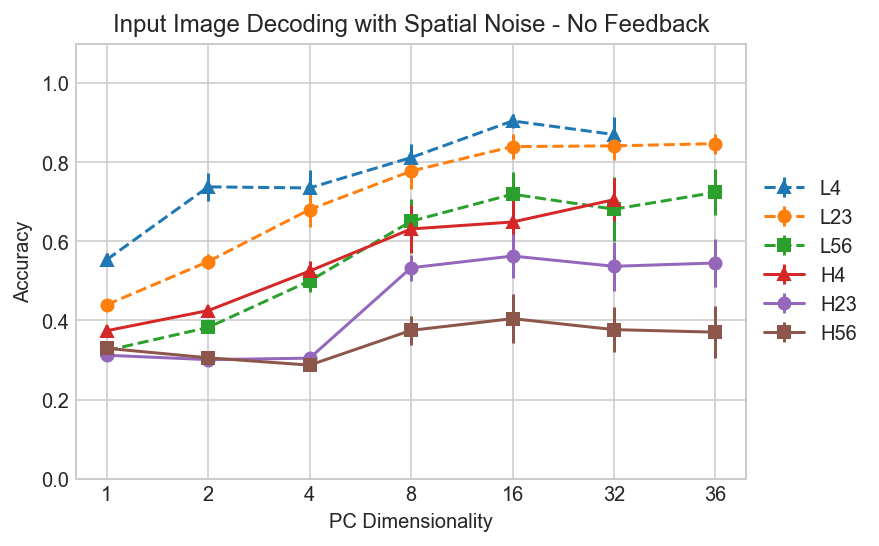

In [381]:
fipimg = plt.figure()
plt.errorbar(np.arange(len(dims4)),
             np.mean(noisy_mean_accs_L4img_inPC,0)[:,-1],yerr=np.var(noisy_mean_accs_L4img_inPC,0)[:,-1],
             label='L4',fmt='--^')
plt.errorbar(np.arange(len(dims23)),
             np.mean(noisy_mean_accs_L23img_inPC,0)[:,-1],yerr=np.var(noisy_mean_accs_L23img_inPC,0)[:,-1],
             label='L23',fmt='--o')
plt.errorbar(np.arange(len(dims56)),
             np.mean(noisy_mean_accs_L56img_inPC,0)[:,-1],yerr=np.var(noisy_mean_accs_L56img_inPC,0)[:,-1],
             label='L56',fmt='--s')
plt.errorbar(np.arange(len(dims4)),
             np.mean(noisy_mean_accs_H4img_inPC,0)[:,-1],yerr=np.var(noisy_mean_accs_H4img_inPC,0)[:,-1],
             label='H4',fmt='-^')
plt.errorbar(np.arange(len(dims23)),
             np.mean(noisy_mean_accs_H23img_inPC,0)[:,-1],yerr=np.var(noisy_mean_accs_H23img_inPC,0)[:,-1],
             label='H23',fmt='-o')
plt.errorbar(np.arange(len(dims56)),
             np.mean(noisy_mean_accs_H56img_inPC,0)[:,-1],yerr=np.var(noisy_mean_accs_H56img_inPC,0)[:,-1],
             label='H56',fmt='-s')
plt.xticks(np.arange(len(dims23)),dims23)
plt.title('Input Image Decoding with Spatial Noise - No Feedback')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('Accuracy')
plt.xlabel('PC Dimensionality')
plt.ylim(0,1.1)

In [382]:
fipimg.savefig('input-image-decoding-no-fb.png',dpi=300,bbox_inches="tight")

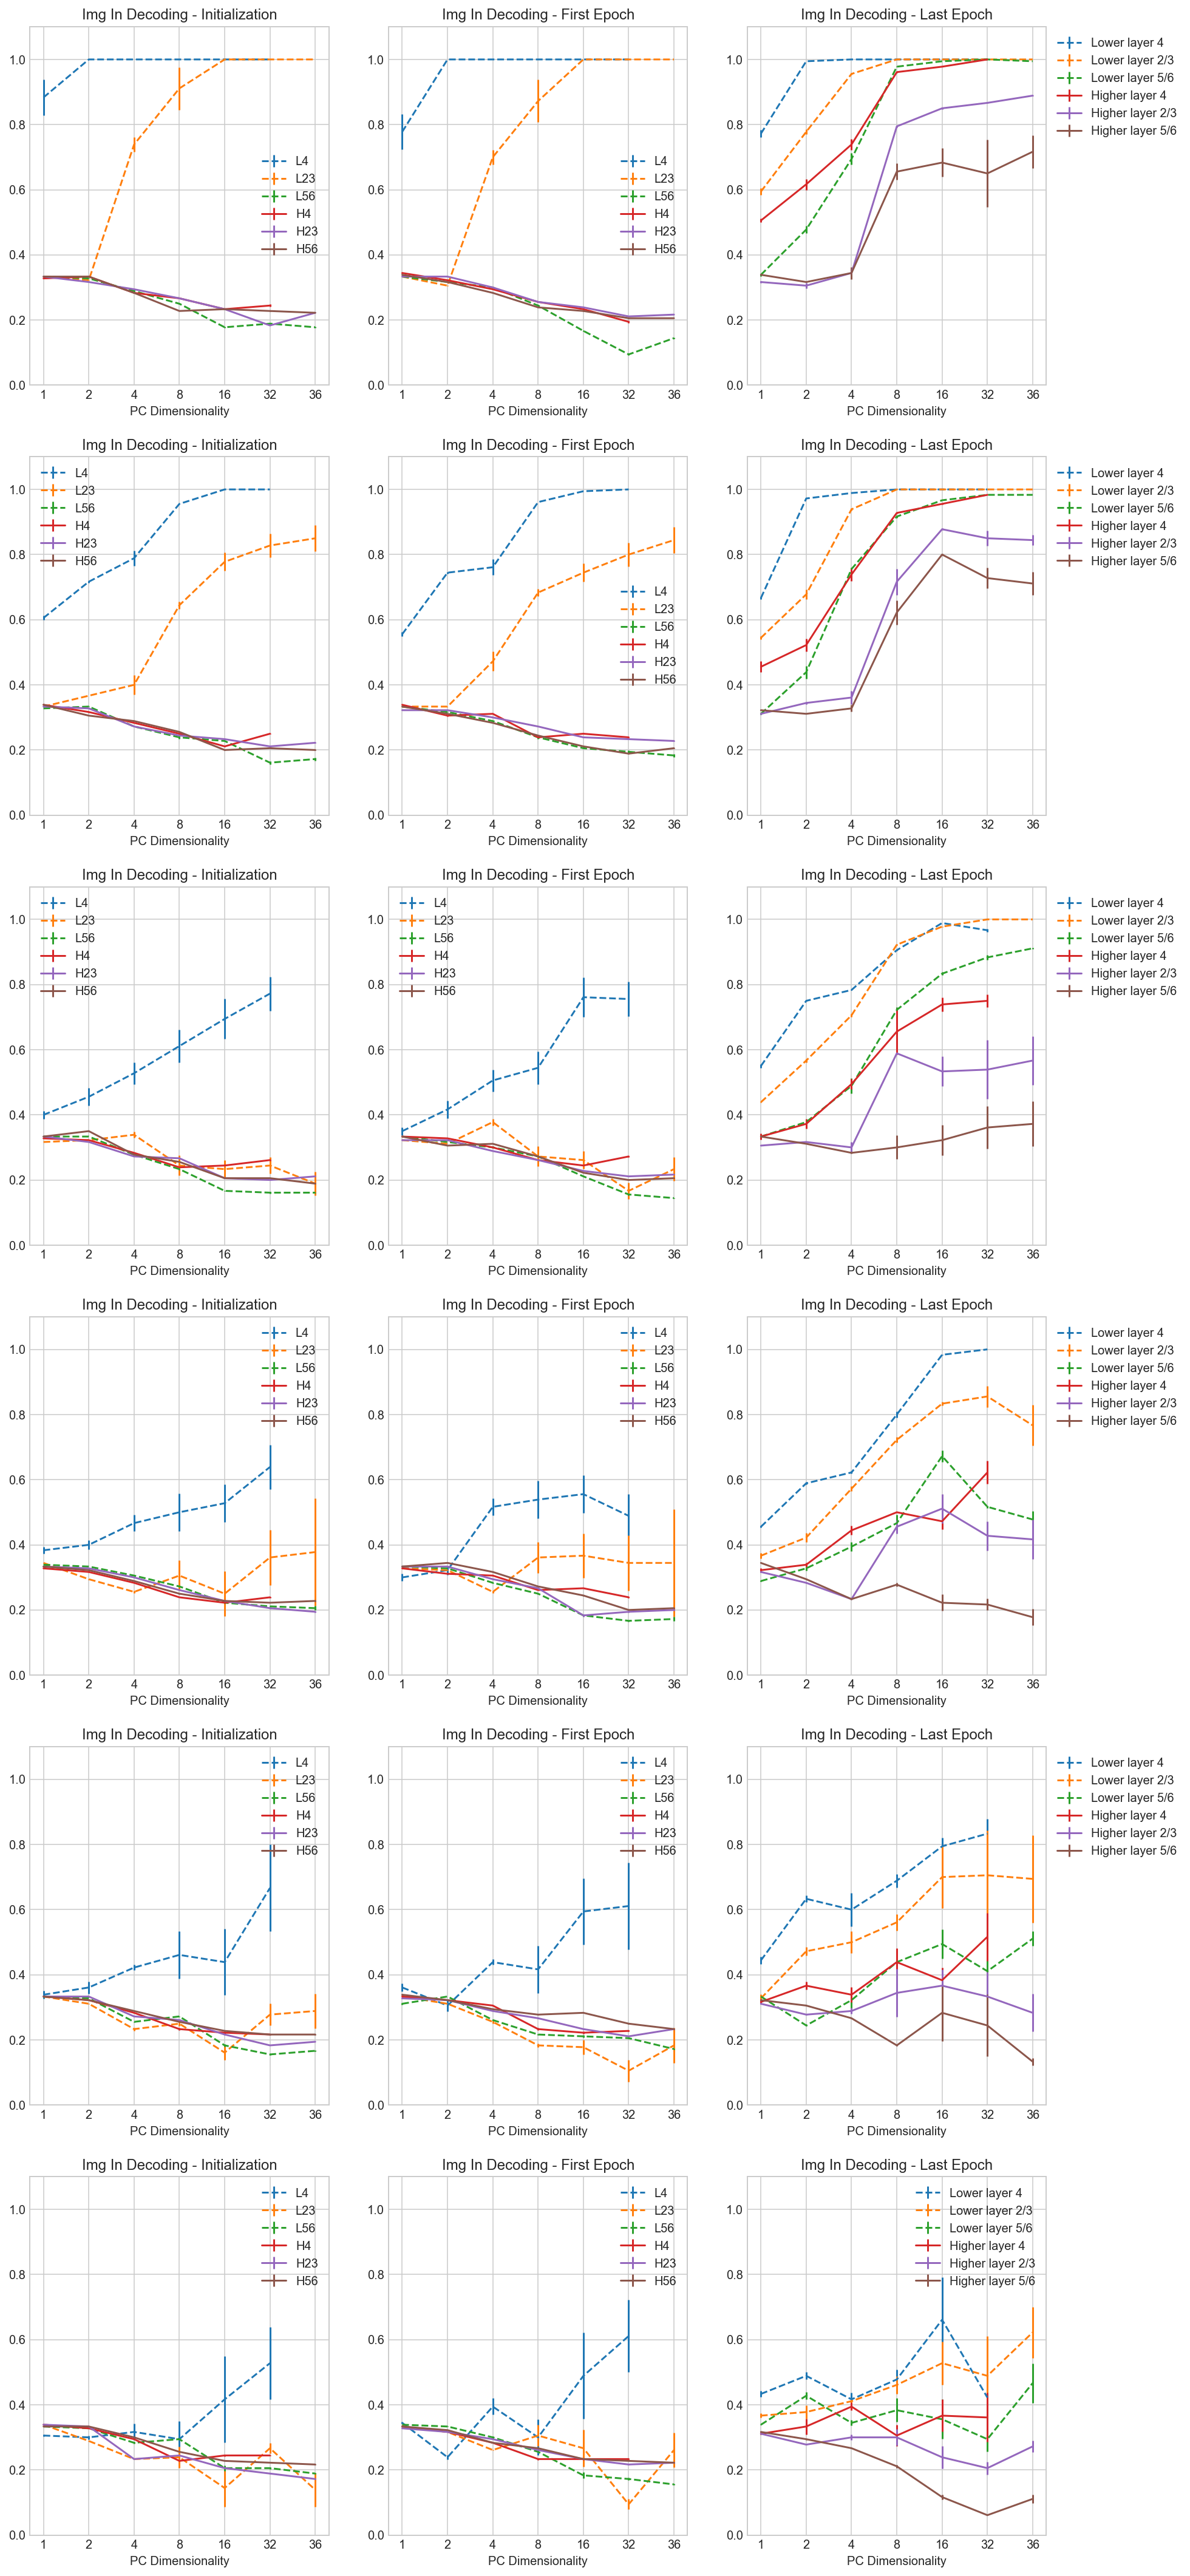

In [383]:
ffimg_in_noisy = plt.figure(figsize=(15,38))

for nn in range(len(noise_stds)):
    plt.subplot(6,3,3*nn + 1)
    plt.title('Img In Decoding - Initialization')
    plt.errorbar(np.arange(len(dims4)),noisy_mean_accs_L4img_inPC[nn,:,0],
                 yerr=noisy_std_accs_L4img_inPC[nn,:,1],label='L4',fmt='--')
    plt.errorbar(np.arange(len(dims23)),noisy_mean_accs_L23img_inPC[nn,:,0],
                 yerr=noisy_std_accs_L23img_inPC[nn,:,1],label='L23',fmt='--')
    plt.errorbar(np.arange(len(dims56)),noisy_mean_accs_L56img_inPC[nn,:,0],
                 yerr=noisy_std_accs_L56img_inPC[nn,:,1],label='L56',fmt='--')
    plt.errorbar(np.arange(len(dims4)),noisy_mean_accs_H4img_inPC[nn,:,0],
                 yerr=noisy_std_accs_H4img_inPC[nn,:,1],label='H4',fmt='-')
    plt.errorbar(np.arange(len(dims23)),noisy_mean_accs_H23img_inPC[nn,:,0],
                 yerr=noisy_std_accs_H23img_inPC[nn,:,1],label='H23',fmt='-')
    plt.errorbar(np.arange(len(dims56)),noisy_mean_accs_H56img_inPC[nn,:,0],
                 yerr=noisy_std_accs_H56img_inPC[nn,:,1],label='H56',fmt='-')
    plt.xlabel('PC Dimensionality')
    plt.ylim(0,1.1)
    plt.xticks(np.arange(len(dims23)),dims23)
    plt.legend()

    plt.subplot(6,3,3*nn + 2)
    plt.title('Img In Decoding - First Epoch')
    plt.errorbar(np.arange(len(dims4)),noisy_mean_accs_L4img_inPC[nn,:,1],
                 yerr=noisy_std_accs_L4img_inPC[nn,:,1],label='L4',fmt='--')
    plt.errorbar(np.arange(len(dims23)),noisy_mean_accs_L23img_inPC[nn,:,1],
                 yerr=noisy_std_accs_L23img_inPC[nn,:,1],label='L23',fmt='--')
    plt.errorbar(np.arange(len(dims56)),noisy_mean_accs_L56img_inPC[nn,:,1],
                 yerr=noisy_std_accs_L56img_inPC[nn,:,1],label='L56',fmt='--')
    plt.errorbar(np.arange(len(dims4)),noisy_mean_accs_H4img_inPC[nn,:,1],
                 yerr=noisy_std_accs_H4img_inPC[nn,:,1],label='H4',fmt='-')
    plt.errorbar(np.arange(len(dims23)),noisy_mean_accs_H23img_inPC[nn,:,1],
                 yerr=noisy_std_accs_H23img_inPC[nn,:,1],label='H23',fmt='-')
    plt.errorbar(np.arange(len(dims56)),noisy_mean_accs_H56img_inPC[nn,:,1],
                 yerr=noisy_std_accs_H56img_inPC[nn,:,1],label='H56',fmt='-')
    plt.xlabel('PC Dimensionality')
    plt.ylim(0,1.1)
    plt.xticks(np.arange(len(dims23)),dims23)
    plt.legend()

    plt.subplot(6,3,3*nn + 3)
    plt.title('Img In Decoding - Last Epoch')
    plt.errorbar(np.arange(len(dims4)),noisy_mean_accs_L4img_inPC[nn,:,-1],
                 yerr=noisy_std_accs_L4img_inPC[nn,:,-1],label='Lower layer 4',fmt='--')
    plt.errorbar(np.arange(len(dims23)),noisy_mean_accs_L23img_inPC[nn,:,-1],
                 yerr=noisy_std_accs_L23img_inPC[nn,:,-1],label='Lower layer 2/3',fmt='--')
    plt.errorbar(np.arange(len(dims56)),noisy_mean_accs_L56img_inPC[nn,:,-1],
                 yerr=noisy_std_accs_L56img_inPC[nn,:,-1],label='Lower layer 5/6',fmt='--')
    plt.errorbar(np.arange(len(dims4)),noisy_mean_accs_H4img_inPC[nn,:,-1],
                 yerr=noisy_std_accs_H4img_inPC[nn,:,-1],label='Higher layer 4',fmt='-')
    plt.errorbar(np.arange(len(dims23)),noisy_mean_accs_H23img_inPC[nn,:,-1],
                 yerr=noisy_std_accs_H23img_inPC[nn,:,-1],label='Higher layer 2/3',fmt='-')
    plt.errorbar(np.arange(len(dims56)),noisy_mean_accs_H56img_inPC[nn,:,-1],
                 yerr=noisy_std_accs_H56img_inPC[nn,:,-1],label='Higher layer 5/6',fmt='-')
    plt.xlabel('PC Dimensionality')
    plt.ylim(0,1.1)
    plt.xticks(np.arange(len(dims23)),dims23)
    plt.legend(bbox_to_anchor=(1,1))

#### Image Out

In [384]:
noisy_L23img_outPC = {}
noisy_L4img_outPC = {}
noisy_L56img_outPC = {}

noisy_H23img_outPC = {}
noisy_H4img_outPC = {}
noisy_H56img_outPC = {}

In [385]:
for cntr in tqdm(range(nRuns)):
    for nn, noise in enumerate(noise_stds):
    
        for d in dims23:
            noisy_L23img_outPC[cntr,nn,d], _ = repsDecodeSupervisedImage(L23_noisy_pca[cntr,nn][:,:,:d],labelMtxC[:,1],
                                                                         io='out')
            noisy_H23img_outPC[cntr,nn,d], _ = repsDecodeSupervisedImage(H23_noisy_pca[cntr,nn][:,:,:d],labelMtxC[:,1],
                                                                         io='out')

        for d in dims4:
            noisy_L4img_outPC[cntr,nn,d], _ = repsDecodeSupervisedImage(L4_noisy_pca[cntr,nn][:,:,:d],labelMtxC[:,1],
                                                                        io='out')
            noisy_H4img_outPC[cntr,nn,d], _ = repsDecodeSupervisedImage(H4_noisy_pca[cntr,nn][:,:,:d],labelMtxC[:,1],
                                                                        io='out')

        for d in dims56:
            noisy_L56img_outPC[cntr,nn,d], _ = repsDecodeSupervisedImage(L56_noisy_pca[cntr,nn][:,:,:d],labelMtxC[:,1],
                                                                         io='out')      
            noisy_H56img_outPC[cntr,nn,d], _ = repsDecodeSupervisedImage(H56_noisy_pca[cntr,nn][:,:,:d],labelMtxC[:,1],
                                                                         io='out')

100%|██████████| 5/5 [03:25<00:00, 41.13s/it]


In [386]:
noisy_preds_L23img_outPC = {}
noisy_preds_L4img_outPC = {}
noisy_preds_L56img_outPC = {}

noisy_preds_H23img_outPC = {}
noisy_preds_H4img_outPC = {}
noisy_preds_H56img_outPC = {}

In [387]:
noisy_accs_L23img_outPC = {}
noisy_accs_L4img_outPC = {}
noisy_accs_L56img_outPC = {}

noisy_accs_H23img_outPC = {}
noisy_accs_H4img_outPC = {}
noisy_accs_H56img_outPC = {}

In [388]:
for cntr in range(nRuns):
    
    for ep in range(n_epochs+1):
        
        for nn, noise in enumerate(noise_stds):
        
            for d in dims23:
                noisy_preds_L23img_outPC[cntr,nn,d,ep] = np.argmax(noisy_L23img_outPC[cntr,nn,d][ep],axis=-1)
                noisy_preds_H23img_outPC[cntr,nn,d,ep] = np.argmax(noisy_H23img_outPC[cntr,nn,d][ep],axis=-1)

                noisy_accs_L23img_outPC[cntr,nn,d,ep] = accuracy_score(labelMtxC[:,1],noisy_preds_L23img_outPC[cntr,nn,d,ep])
                noisy_accs_H23img_outPC[cntr,nn,d,ep] = accuracy_score(labelMtxC[:,1],noisy_preds_H23img_outPC[cntr,nn,d,ep])

            for d in dims4:
                noisy_preds_L4img_outPC[cntr,nn,d,ep] = np.argmax(noisy_L4img_outPC[cntr,nn,d][ep],axis=-1)
                noisy_preds_H4img_outPC[cntr,nn,d,ep] = np.argmax(noisy_H4img_outPC[cntr,nn,d][ep],axis=-1)

                noisy_accs_L4img_outPC[cntr,nn,d,ep] = accuracy_score(labelMtxC[:,1],noisy_preds_L4img_outPC[cntr,nn,d,ep])
                noisy_accs_H4img_outPC[cntr,nn,d,ep] = accuracy_score(labelMtxC[:,1],noisy_preds_H4img_outPC[cntr,nn,d,ep])

            for d in dims56:
                noisy_preds_L56img_outPC[cntr,nn,d,ep] = np.argmax(noisy_L56img_outPC[cntr,nn,d][ep],axis=-1)
                noisy_preds_H56img_outPC[cntr,nn,d,ep] = np.argmax(noisy_H56img_outPC[cntr,nn,d][ep],axis=-1)

                noisy_accs_L56img_outPC[cntr,nn,d,ep] = accuracy_score(labelMtxC[:,1],noisy_preds_L56img_outPC[cntr,nn,d,ep])
                noisy_accs_H56img_outPC[cntr,nn,d,ep] = accuracy_score(labelMtxC[:,1],noisy_preds_H56img_outPC[cntr,nn,d,ep])

In [389]:
noisy_tensor_accs_L23img_outPC = np.zeros((nRuns,len(noise_stds),len(dims23),n_epochs+1))
noisy_tensor_accs_L4img_outPC = np.zeros((nRuns,len(noise_stds),len(dims4),n_epochs+1))
noisy_tensor_accs_L56img_outPC = np.zeros((nRuns,len(noise_stds),len(dims56),n_epochs+1))

noisy_tensor_accs_H23img_outPC = np.zeros((nRuns,len(noise_stds),len(dims23),n_epochs+1))
noisy_tensor_accs_H4img_outPC = np.zeros((nRuns,len(noise_stds),len(dims4),n_epochs+1))
noisy_tensor_accs_H56img_outPC = np.zeros((nRuns,len(noise_stds),len(dims56),n_epochs+1))

In [390]:
for ii in range(nRuns):
    
    for kk in range(n_epochs+1):
        
        for nn, noise in enumerate(noise_stds):
        
            for jj,d in enumerate(dims23):
                noisy_tensor_accs_L23img_outPC[ii,nn,jj,kk] = noisy_accs_L23img_outPC[ii,nn,d,kk]
                noisy_tensor_accs_H23img_outPC[ii,nn,jj,kk] = noisy_accs_H23img_outPC[ii,nn,d,kk]

            for jj,d in enumerate(dims4):
                noisy_tensor_accs_L4img_outPC[ii,nn,jj,kk] = noisy_accs_L4img_outPC[ii,nn,d,kk]
                noisy_tensor_accs_H4img_outPC[ii,nn,jj,kk] = noisy_accs_H4img_outPC[ii,nn,d,kk]

            for jj,d in enumerate(dims56):            
                noisy_tensor_accs_L56img_outPC[ii,nn,jj,kk] = noisy_accs_L56img_outPC[ii,nn,d,kk]            
                noisy_tensor_accs_H56img_outPC[ii,nn,jj,kk] = noisy_accs_H56img_outPC[ii,nn,d,kk]

In [391]:
noisy_mean_accs_L4img_outPC = np.zeros((len(noise_stds),len(dims4),n_epochs+1))
noisy_mean_accs_L23img_outPC = np.zeros((len(noise_stds),len(dims23),n_epochs+1))
noisy_mean_accs_L56img_outPC = np.zeros((len(noise_stds),len(dims56),n_epochs+1))

noisy_mean_accs_H4img_outPC = np.zeros((len(noise_stds),len(dims4),n_epochs+1))
noisy_mean_accs_H23img_outPC = np.zeros((len(noise_stds),len(dims23),n_epochs+1))
noisy_mean_accs_H56img_outPC = np.zeros((len(noise_stds),len(dims56),n_epochs+1))

noisy_std_accs_L4img_outPC = np.zeros((len(noise_stds),len(dims4),n_epochs+1))
noisy_std_accs_L23img_outPC = np.zeros((len(noise_stds),len(dims23),n_epochs+1))
noisy_std_accs_L56img_outPC = np.zeros((len(noise_stds),len(dims56),n_epochs+1))

noisy_std_accs_H4img_outPC = np.zeros((len(noise_stds),len(dims4),n_epochs+1))
noisy_std_accs_H23img_outPC = np.zeros((len(noise_stds),len(dims23),n_epochs+1))
noisy_std_accs_H56img_outPC = np.zeros((len(noise_stds),len(dims56),n_epochs+1))

In [392]:
for ep in range(n_epochs+1):
    
    for nn, noise in enumerate(noise_stds):
    
        for dd, dim in enumerate(dims23):
            noisy_mean_accs_L23img_outPC[nn,dd,ep] = np.mean(noisy_tensor_accs_L23img_outPC[:,nn,dd,ep])
            noisy_mean_accs_H23img_outPC[nn,dd,ep] = np.mean(noisy_tensor_accs_H23img_outPC[:,nn,dd,ep])

            noisy_std_accs_L23img_outPC[nn,dd,ep] = np.var(noisy_tensor_accs_L23img_outPC[:,nn,dd,ep])
            noisy_std_accs_H23img_outPC[nn,dd,ep] = np.var(noisy_tensor_accs_H23img_outPC[:,nn,dd,ep])

        for dd, dim in enumerate(dims4):
            noisy_mean_accs_L4img_outPC[nn,dd,ep] = np.mean(noisy_tensor_accs_L4img_outPC[:,nn,dd,ep])
            noisy_mean_accs_H4img_outPC[nn,dd,ep] = np.mean(noisy_tensor_accs_H4img_outPC[:,nn,dd,ep])

            noisy_std_accs_L4img_outPC[nn,dd,ep] = np.var(noisy_tensor_accs_L4img_outPC[:,nn,dd,ep])
            noisy_std_accs_H4img_outPC[nn,dd,ep] = np.var(noisy_tensor_accs_H4img_outPC[:,nn,dd,ep])

        for dd, dim in enumerate(dims56):
            noisy_mean_accs_L56img_outPC[nn,dd,ep] = np.mean(noisy_tensor_accs_L56img_outPC[:,nn,dd,ep])
            noisy_mean_accs_H56img_outPC[nn,dd,ep] = np.mean(noisy_tensor_accs_H56img_outPC[:,nn,dd,ep])

            noisy_std_accs_L56img_outPC[nn,dd,ep] = np.var(noisy_tensor_accs_L56img_outPC[:,nn,dd,ep])
            noisy_std_accs_H56img_outPC[nn,dd,ep] = np.var(noisy_tensor_accs_H56img_outPC[:,nn,dd,ep])

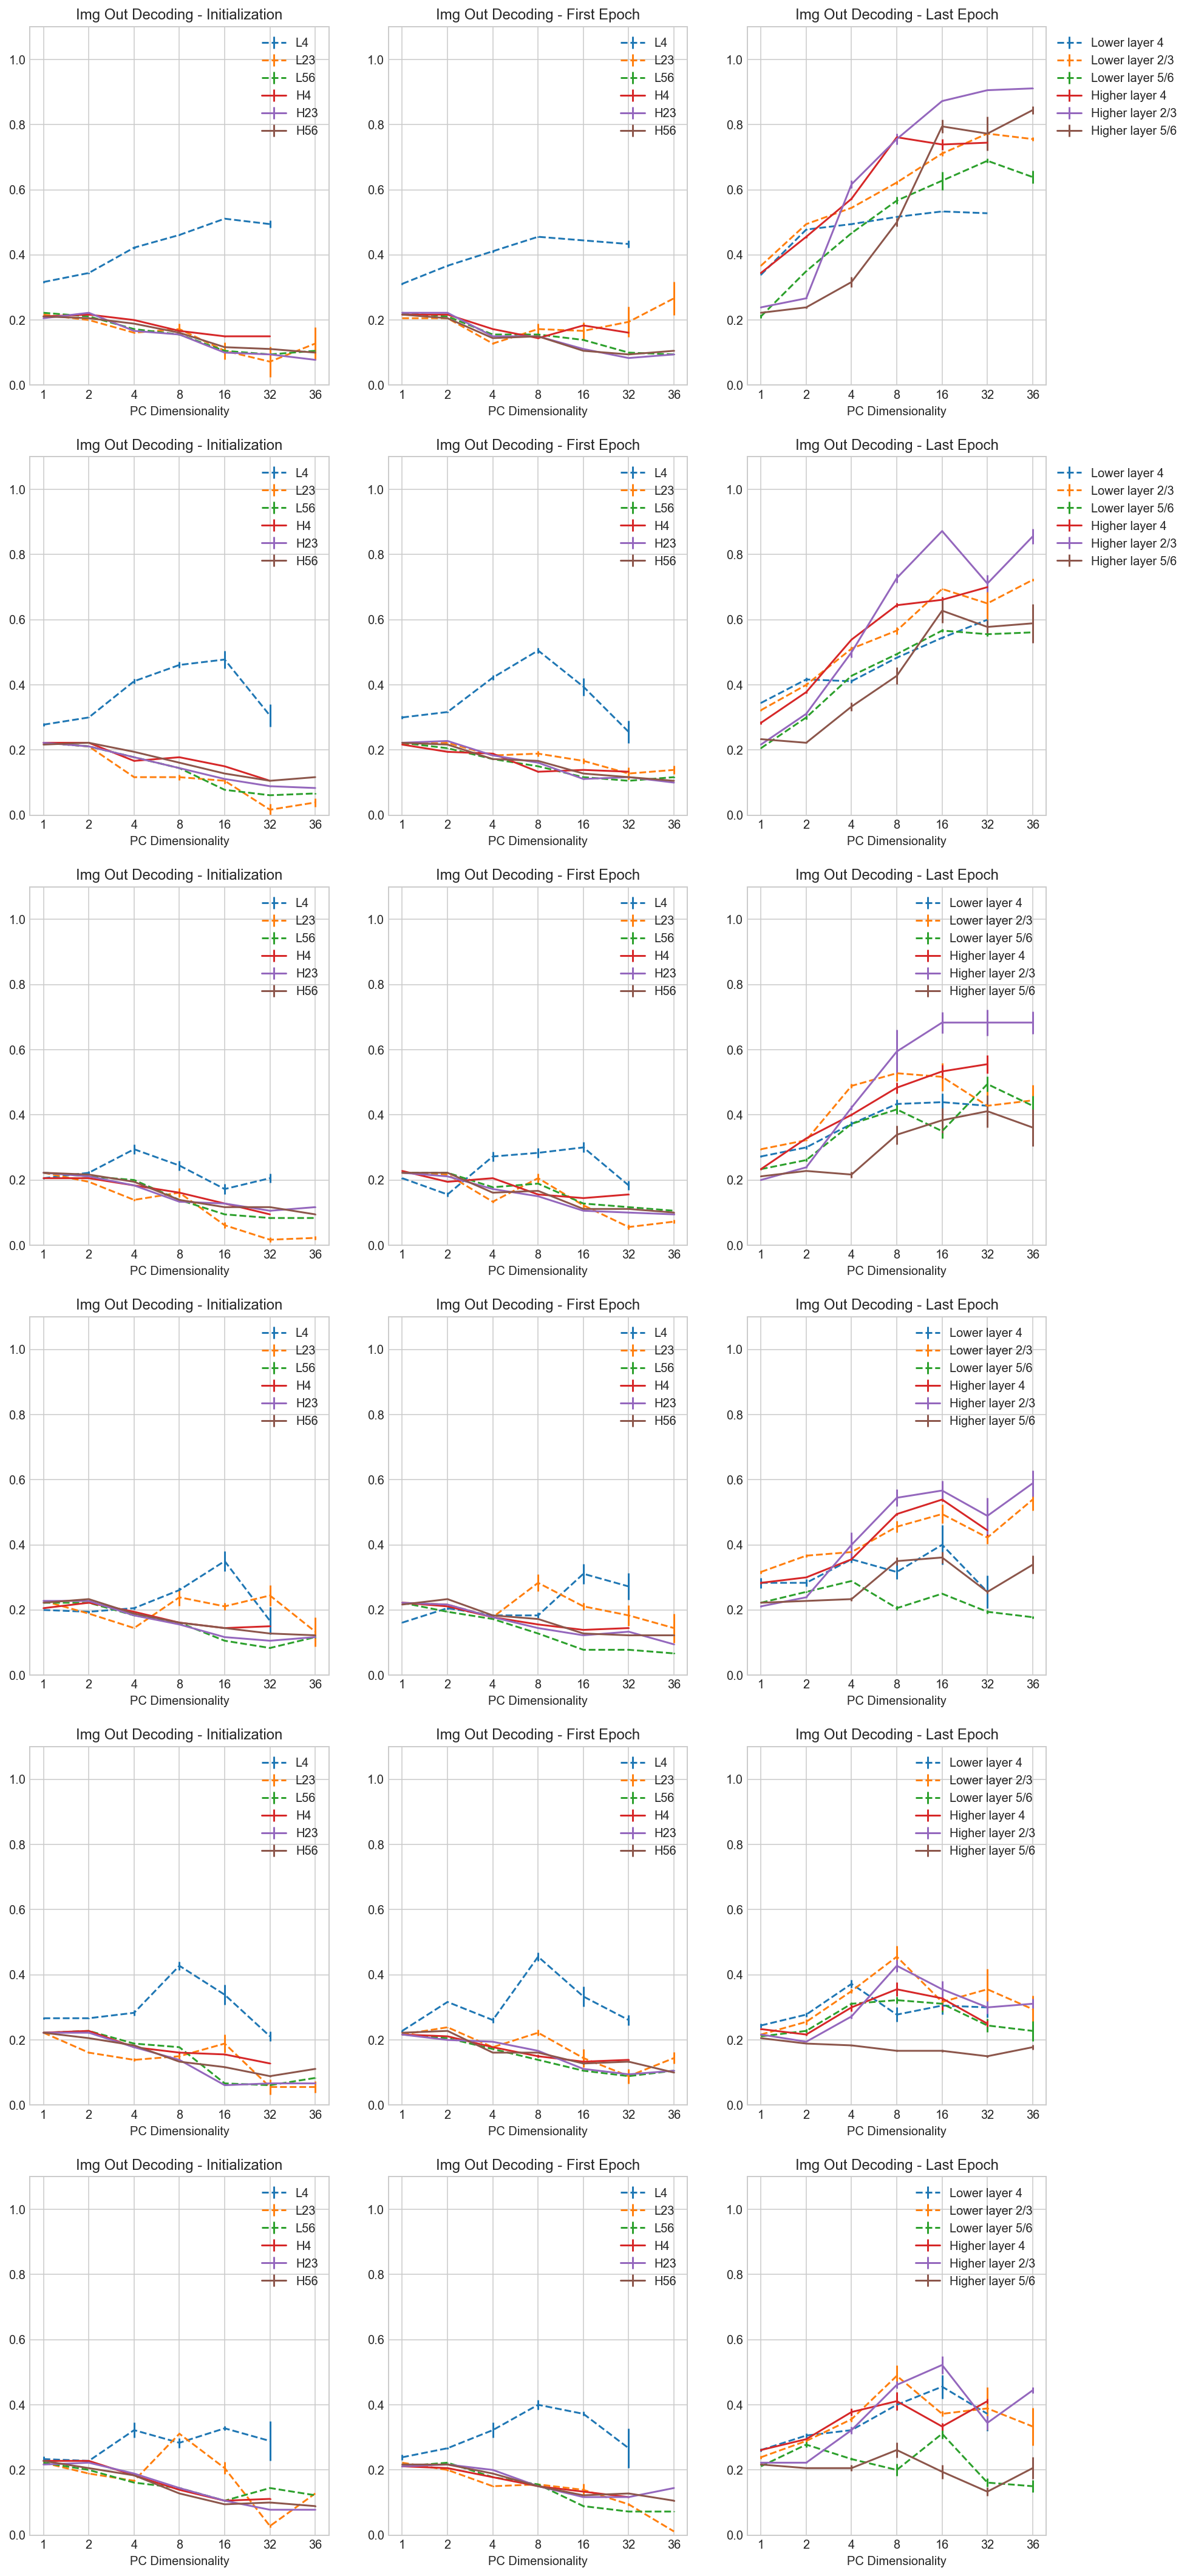

In [393]:
ffimg_out_noisy = plt.figure(figsize=(15,38))

for nn in range(len(noise_stds)):
    plt.subplot(6,3,3*nn + 1)
    plt.title('Img Out Decoding - Initialization')
    plt.errorbar(np.arange(len(dims4)),noisy_mean_accs_L4img_outPC[nn,:,0],
                 yerr=noisy_std_accs_L4img_outPC[nn,:,1],label='L4',fmt='--')
    plt.errorbar(np.arange(len(dims23)),noisy_mean_accs_L23img_outPC[nn,:,0],
                 yerr=noisy_std_accs_L23img_outPC[nn,:,1],label='L23',fmt='--')
    plt.errorbar(np.arange(len(dims56)),noisy_mean_accs_L56img_outPC[nn,:,0],
                 yerr=noisy_std_accs_L56img_outPC[nn,:,1],label='L56',fmt='--')
    plt.errorbar(np.arange(len(dims4)),noisy_mean_accs_H4img_outPC[nn,:,0],
                 yerr=noisy_std_accs_H4img_outPC[nn,:,1],label='H4',fmt='-')
    plt.errorbar(np.arange(len(dims23)),noisy_mean_accs_H23img_outPC[nn,:,0],
                 yerr=noisy_std_accs_H23img_outPC[nn,:,1],label='H23',fmt='-')
    plt.errorbar(np.arange(len(dims56)),noisy_mean_accs_H56img_outPC[nn,:,0],
                 yerr=noisy_std_accs_H56img_outPC[nn,:,1],label='H56',fmt='-')
    plt.xlabel('PC Dimensionality')
    plt.ylim(0,1.1)
    plt.xticks(np.arange(len(dims23)),dims23)
    plt.legend()

    plt.subplot(6,3,3*nn + 2)
    plt.title('Img Out Decoding - First Epoch')
    plt.errorbar(np.arange(len(dims4)),noisy_mean_accs_L4img_outPC[nn,:,1],
                 yerr=noisy_std_accs_L4img_outPC[nn,:,1],label='L4',fmt='--')
    plt.errorbar(np.arange(len(dims23)),noisy_mean_accs_L23img_outPC[nn,:,1],
                 yerr=noisy_std_accs_L23img_outPC[nn,:,1],label='L23',fmt='--')
    plt.errorbar(np.arange(len(dims56)),noisy_mean_accs_L56img_outPC[nn,:,1],
                 yerr=noisy_std_accs_L56img_outPC[nn,:,1],label='L56',fmt='--')
    plt.errorbar(np.arange(len(dims4)),noisy_mean_accs_H4img_outPC[nn,:,1],
                 yerr=noisy_std_accs_H4img_outPC[nn,:,1],label='H4',fmt='-')
    plt.errorbar(np.arange(len(dims23)),noisy_mean_accs_H23img_outPC[nn,:,1],
                 yerr=noisy_std_accs_H23img_outPC[nn,:,1],label='H23',fmt='-')
    plt.errorbar(np.arange(len(dims56)),noisy_mean_accs_H56img_outPC[nn,:,1],
                 yerr=noisy_std_accs_H56img_outPC[nn,:,1],label='H56',fmt='-')
    plt.xlabel('PC Dimensionality')
    plt.ylim(0,1.1)
    plt.xticks(np.arange(len(dims23)),dims23)
    plt.legend()

    plt.subplot(6,3,3*nn + 3)
    plt.title('Img Out Decoding - Last Epoch')
    plt.errorbar(np.arange(len(dims4)),noisy_mean_accs_L4img_outPC[nn,:,-1],
                 yerr=noisy_std_accs_L4img_outPC[nn,:,-1],label='Lower layer 4',fmt='--')
    plt.errorbar(np.arange(len(dims23)),noisy_mean_accs_L23img_outPC[nn,:,-1],
                 yerr=noisy_std_accs_L23img_outPC[nn,:,-1],label='Lower layer 2/3',fmt='--')
    plt.errorbar(np.arange(len(dims56)),noisy_mean_accs_L56img_outPC[nn,:,-1],
                 yerr=noisy_std_accs_L56img_outPC[nn,:,-1],label='Lower layer 5/6',fmt='--')
    plt.errorbar(np.arange(len(dims4)),noisy_mean_accs_H4img_outPC[nn,:,-1],
                 yerr=noisy_std_accs_H4img_outPC[nn,:,-1],label='Higher layer 4',fmt='-')
    plt.errorbar(np.arange(len(dims23)),noisy_mean_accs_H23img_outPC[nn,:,-1],
                 yerr=noisy_std_accs_H23img_outPC[nn,:,-1],label='Higher layer 2/3',fmt='-')
    plt.errorbar(np.arange(len(dims56)),noisy_mean_accs_H56img_outPC[nn,:,-1],
                 yerr=noisy_std_accs_H56img_outPC[nn,:,-1],label='Higher layer 5/6',fmt='-')
    plt.xlabel('PC Dimensionality')
    plt.ylim(0,1.1)
    plt.xticks(np.arange(len(dims23)),dims23)
    plt.legend(bbox_to_anchor=(1,1))

(0.1, 0.9)

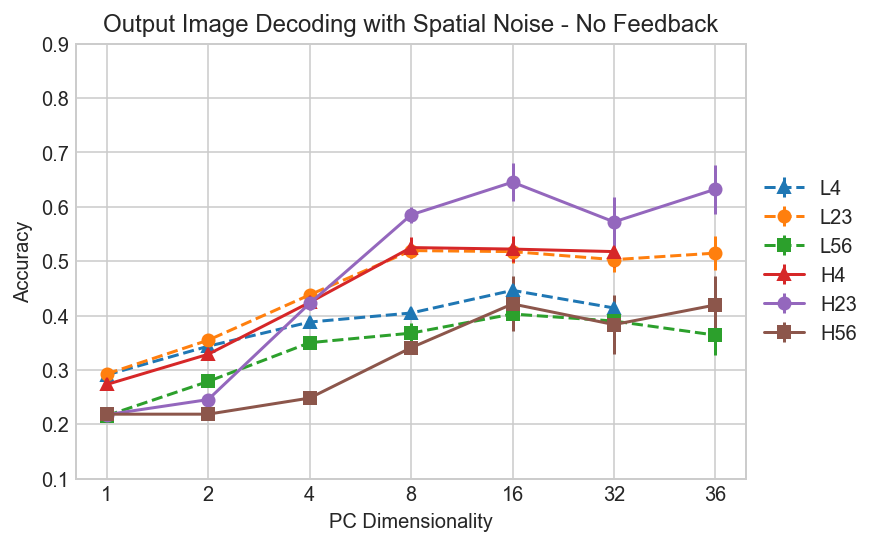

In [394]:
foutimg = plt.figure()
plt.errorbar(np.arange(len(dims4)),
             np.mean(noisy_mean_accs_L4img_outPC,0)[:,-1],yerr=np.var(noisy_mean_accs_L4img_outPC,0)[:,-1],
             label='L4',fmt='--^')
plt.errorbar(np.arange(len(dims23)),
             np.mean(noisy_mean_accs_L23img_outPC,0)[:,-1],yerr=np.var(noisy_mean_accs_L23img_outPC,0)[:,-1],
             label='L23',fmt='--o')
plt.errorbar(np.arange(len(dims56)),
             np.mean(noisy_mean_accs_L56img_outPC,0)[:,-1],yerr=np.var(noisy_mean_accs_L56img_outPC,0)[:,-1],
             label='L56',fmt='--s')
plt.errorbar(np.arange(len(dims4)),
             np.mean(noisy_mean_accs_H4img_outPC,0)[:,-1],yerr=np.var(noisy_mean_accs_H4img_outPC,0)[:,-1],
             label='H4',fmt='-^')
plt.errorbar(np.arange(len(dims23)),
             np.mean(noisy_mean_accs_H23img_outPC,0)[:,-1],yerr=np.var(noisy_mean_accs_H23img_outPC,0)[:,-1],
             label='H23',fmt='-o')
plt.errorbar(np.arange(len(dims56)),
             np.mean(noisy_mean_accs_H56img_outPC,0)[:,-1],yerr=np.var(noisy_mean_accs_H56img_outPC,0)[:,-1],
             label='H56',fmt='-s')
plt.xticks(np.arange(len(dims23)),dims23)
plt.title('Output Image Decoding with Spatial Noise - No Feedback')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('Accuracy')
plt.xlabel('PC Dimensionality')
plt.ylim(0.1,0.9)

In [395]:
foutimg.savefig('output-image-decoding-no-fb.png',dpi=300,bbox_inches="tight")

#### Position

In [396]:
noisy_L23posPC = {}
noisy_L4posPC = {}
noisy_L56posPC = {}

noisy_H23posPC = {}
noisy_H4posPC = {}
noisy_H56posPC = {}

In [397]:
for cntr in tqdm(range(nRuns)):
    for nn, noise in enumerate(noise_stds):
    
        for d in dims23:
            noisy_L23posPC[cntr,nn,d], _ = repsDecodeSupervisedPosition(L23_noisy_pca[cntr,nn][:,:,:d],labelMtxC[:,-1])
            noisy_H23posPC[cntr,nn,d], _ = repsDecodeSupervisedPosition(H23_noisy_pca[cntr,nn][:,:,:d],labelMtxC[:,-1])

        for d in dims4:
            noisy_L4posPC[cntr,nn,d], _ = repsDecodeSupervisedPosition(L4_noisy_pca[cntr,nn][:,:,:d],labelMtxC[:,-1])
            noisy_H4posPC[cntr,nn,d], _ = repsDecodeSupervisedPosition(H4_noisy_pca[cntr,nn][:,:,:d],labelMtxC[:,-1])

        for d in dims56:
            ## Position
            noisy_L56posPC[cntr,nn,d], _ = repsDecodeSupervisedPosition(L56_noisy_pca[cntr,nn][:,:,:d],labelMtxC[:,-1])      
            noisy_H56posPC[cntr,nn,d], _ = repsDecodeSupervisedPosition(H56_noisy_pca[cntr,nn][:,:,:d],labelMtxC[:,-1])

100%|██████████| 5/5 [01:59<00:00, 23.89s/it]


In [398]:
noisy_preds_L23posPC = {}
noisy_preds_L4posPC = {}
noisy_preds_L56posPC = {}

noisy_preds_H23posPC = {}
noisy_preds_H4posPC = {}
noisy_preds_H56posPC = {}

In [399]:
noisy_accs_L23posPC = {}
noisy_accs_L4posPC = {}
noisy_accs_L56posPC = {}

noisy_accs_H23posPC = {}
noisy_accs_H4posPC = {}
noisy_accs_H56posPC = {}

In [400]:
for cntr in range(nRuns):
    
    for ep in range(n_epochs+1):
        
        for nn, noise in enumerate(noise_stds):
        
            for d in dims23:
                noisy_preds_L23posPC[cntr,nn,d,ep] = np.argmax(noisy_L23posPC[cntr,nn,d][ep],axis=-1)
                noisy_preds_H23posPC[cntr,nn,d,ep] = np.argmax(noisy_H23posPC[cntr,nn,d][ep],axis=-1)

                noisy_accs_L23posPC[cntr,nn,d,ep] = accuracy_score(labelMtxC[:,-1],noisy_preds_L23posPC[cntr,nn,d,ep])
                noisy_accs_H23posPC[cntr,nn,d,ep] = accuracy_score(labelMtxC[:,-1],noisy_preds_H23posPC[cntr,nn,d,ep])

            for d in dims4:
                noisy_preds_L4posPC[cntr,nn,d,ep] = np.argmax(noisy_L4posPC[cntr,nn,d][ep],axis=-1)
                noisy_preds_H4posPC[cntr,nn,d,ep] = np.argmax(noisy_H4posPC[cntr,nn,d][ep],axis=-1)

                noisy_accs_L4posPC[cntr,nn,d,ep] = accuracy_score(labelMtxC[:,-1],noisy_preds_L4posPC[cntr,nn,d,ep])
                noisy_accs_H4posPC[cntr,nn,d,ep] = accuracy_score(labelMtxC[:,-1],noisy_preds_H4posPC[cntr,nn,d,ep])

            for d in dims56:
                noisy_preds_L56posPC[cntr,nn,d,ep] = np.argmax(noisy_L56posPC[cntr,nn,d][ep],axis=-1)
                noisy_preds_H56posPC[cntr,nn,d,ep] = np.argmax(noisy_H56posPC[cntr,nn,d][ep],axis=-1)

                noisy_accs_L56posPC[cntr,nn,d,ep] = accuracy_score(labelMtxC[:,-1],noisy_preds_L56posPC[cntr,nn,d,ep])
                noisy_accs_H56posPC[cntr,nn,d,ep] = accuracy_score(labelMtxC[:,-1],noisy_preds_H56posPC[cntr,nn,d,ep])

In [401]:
noisy_tensor_accs_L23posPC = np.zeros((nRuns,len(noise_stds),len(dims23),n_epochs+1))
noisy_tensor_accs_L4posPC = np.zeros((nRuns,len(noise_stds),len(dims4),n_epochs+1))
noisy_tensor_accs_L56posPC = np.zeros((nRuns,len(noise_stds),len(dims56),n_epochs+1))

noisy_tensor_accs_H23posPC = np.zeros((nRuns,len(noise_stds),len(dims23),n_epochs+1))
noisy_tensor_accs_H4posPC = np.zeros((nRuns,len(noise_stds),len(dims4),n_epochs+1))
noisy_tensor_accs_H56posPC = np.zeros((nRuns,len(noise_stds),len(dims56),n_epochs+1))

In [402]:
for ii in range(nRuns):
    
    for kk in range(n_epochs+1):
        
        for nn, noise in enumerate(noise_stds):
        
            for jj,d in enumerate(dims23):
                noisy_tensor_accs_L23posPC[ii,nn,jj,kk] = noisy_accs_L23posPC[ii,nn,d,kk]
                noisy_tensor_accs_H23posPC[ii,nn,jj,kk] = noisy_accs_H23posPC[ii,nn,d,kk]

            for jj,d in enumerate(dims4):
                noisy_tensor_accs_L4posPC[ii,nn,jj,kk] = noisy_accs_L4posPC[ii,nn,d,kk]
                noisy_tensor_accs_H4posPC[ii,nn,jj,kk] = noisy_accs_H4posPC[ii,nn,d,kk]

            for jj,d in enumerate(dims56):            
                noisy_tensor_accs_L56posPC[ii,nn,jj,kk] = noisy_accs_L56posPC[ii,nn,d,kk]            
                noisy_tensor_accs_H56posPC[ii,nn,jj,kk] = noisy_accs_H56posPC[ii,nn,d,kk]

In [403]:
noisy_mean_accs_L4posPC = np.zeros((len(noise_stds),len(dims4),n_epochs+1))
noisy_mean_accs_L23posPC = np.zeros((len(noise_stds),len(dims23),n_epochs+1))
noisy_mean_accs_L56posPC = np.zeros((len(noise_stds),len(dims56),n_epochs+1))

noisy_mean_accs_H4posPC = np.zeros((len(noise_stds),len(dims4),n_epochs+1))
noisy_mean_accs_H23posPC = np.zeros((len(noise_stds),len(dims23),n_epochs+1))
noisy_mean_accs_H56posPC = np.zeros((len(noise_stds),len(dims56),n_epochs+1))

noisy_std_accs_L4posPC = np.zeros((len(noise_stds),len(dims4),n_epochs+1))
noisy_std_accs_L23posPC = np.zeros((len(noise_stds),len(dims23),n_epochs+1))
noisy_std_accs_L56posPC = np.zeros((len(noise_stds),len(dims56),n_epochs+1))

noisy_std_accs_H4posPC = np.zeros((len(noise_stds),len(dims4),n_epochs+1))
noisy_std_accs_H23posPC = np.zeros((len(noise_stds),len(dims23),n_epochs+1))
noisy_std_accs_H56posPC = np.zeros((len(noise_stds),len(dims56),n_epochs+1))

In [404]:
for ep in range(n_epochs+1):
    
    for nn, noise in enumerate(noise_stds):
    
        for dd, dim in enumerate(dims23):
            noisy_mean_accs_L23posPC[nn,dd,ep] = np.mean(noisy_tensor_accs_L23posPC[:,nn,dd,ep])
            noisy_mean_accs_H23posPC[nn,dd,ep] = np.mean(noisy_tensor_accs_H23posPC[:,nn,dd,ep])

            noisy_std_accs_L23posPC[nn,dd,ep] = np.var(noisy_tensor_accs_L23posPC[:,nn,dd,ep])
            noisy_std_accs_H23posPC[nn,dd,ep] = np.var(noisy_tensor_accs_H23posPC[:,nn,dd,ep])

        for dd, dim in enumerate(dims4):
            noisy_mean_accs_L4posPC[nn,dd,ep] = np.mean(noisy_tensor_accs_L4posPC[:,nn,dd,ep])
            noisy_mean_accs_H4posPC[nn,dd,ep] = np.mean(noisy_tensor_accs_H4posPC[:,nn,dd,ep])

            noisy_std_accs_L4posPC[nn,dd,ep] = np.var(noisy_tensor_accs_L4posPC[:,nn,dd,ep])
            noisy_std_accs_H4posPC[nn,dd,ep] = np.var(noisy_tensor_accs_H4posPC[:,nn,dd,ep])

        for dd, dim in enumerate(dims56):
            noisy_mean_accs_L56posPC[nn,dd,ep] = np.mean(noisy_tensor_accs_L56posPC[:,nn,dd,ep])
            noisy_mean_accs_H56posPC[nn,dd,ep] = np.mean(noisy_tensor_accs_H56posPC[:,nn,dd,ep])

            noisy_std_accs_L56posPC[nn,dd,ep] = np.var(noisy_tensor_accs_L56posPC[:,nn,dd,ep])
            noisy_std_accs_H56posPC[nn,dd,ep] = np.var(noisy_tensor_accs_H56posPC[:,nn,dd,ep])

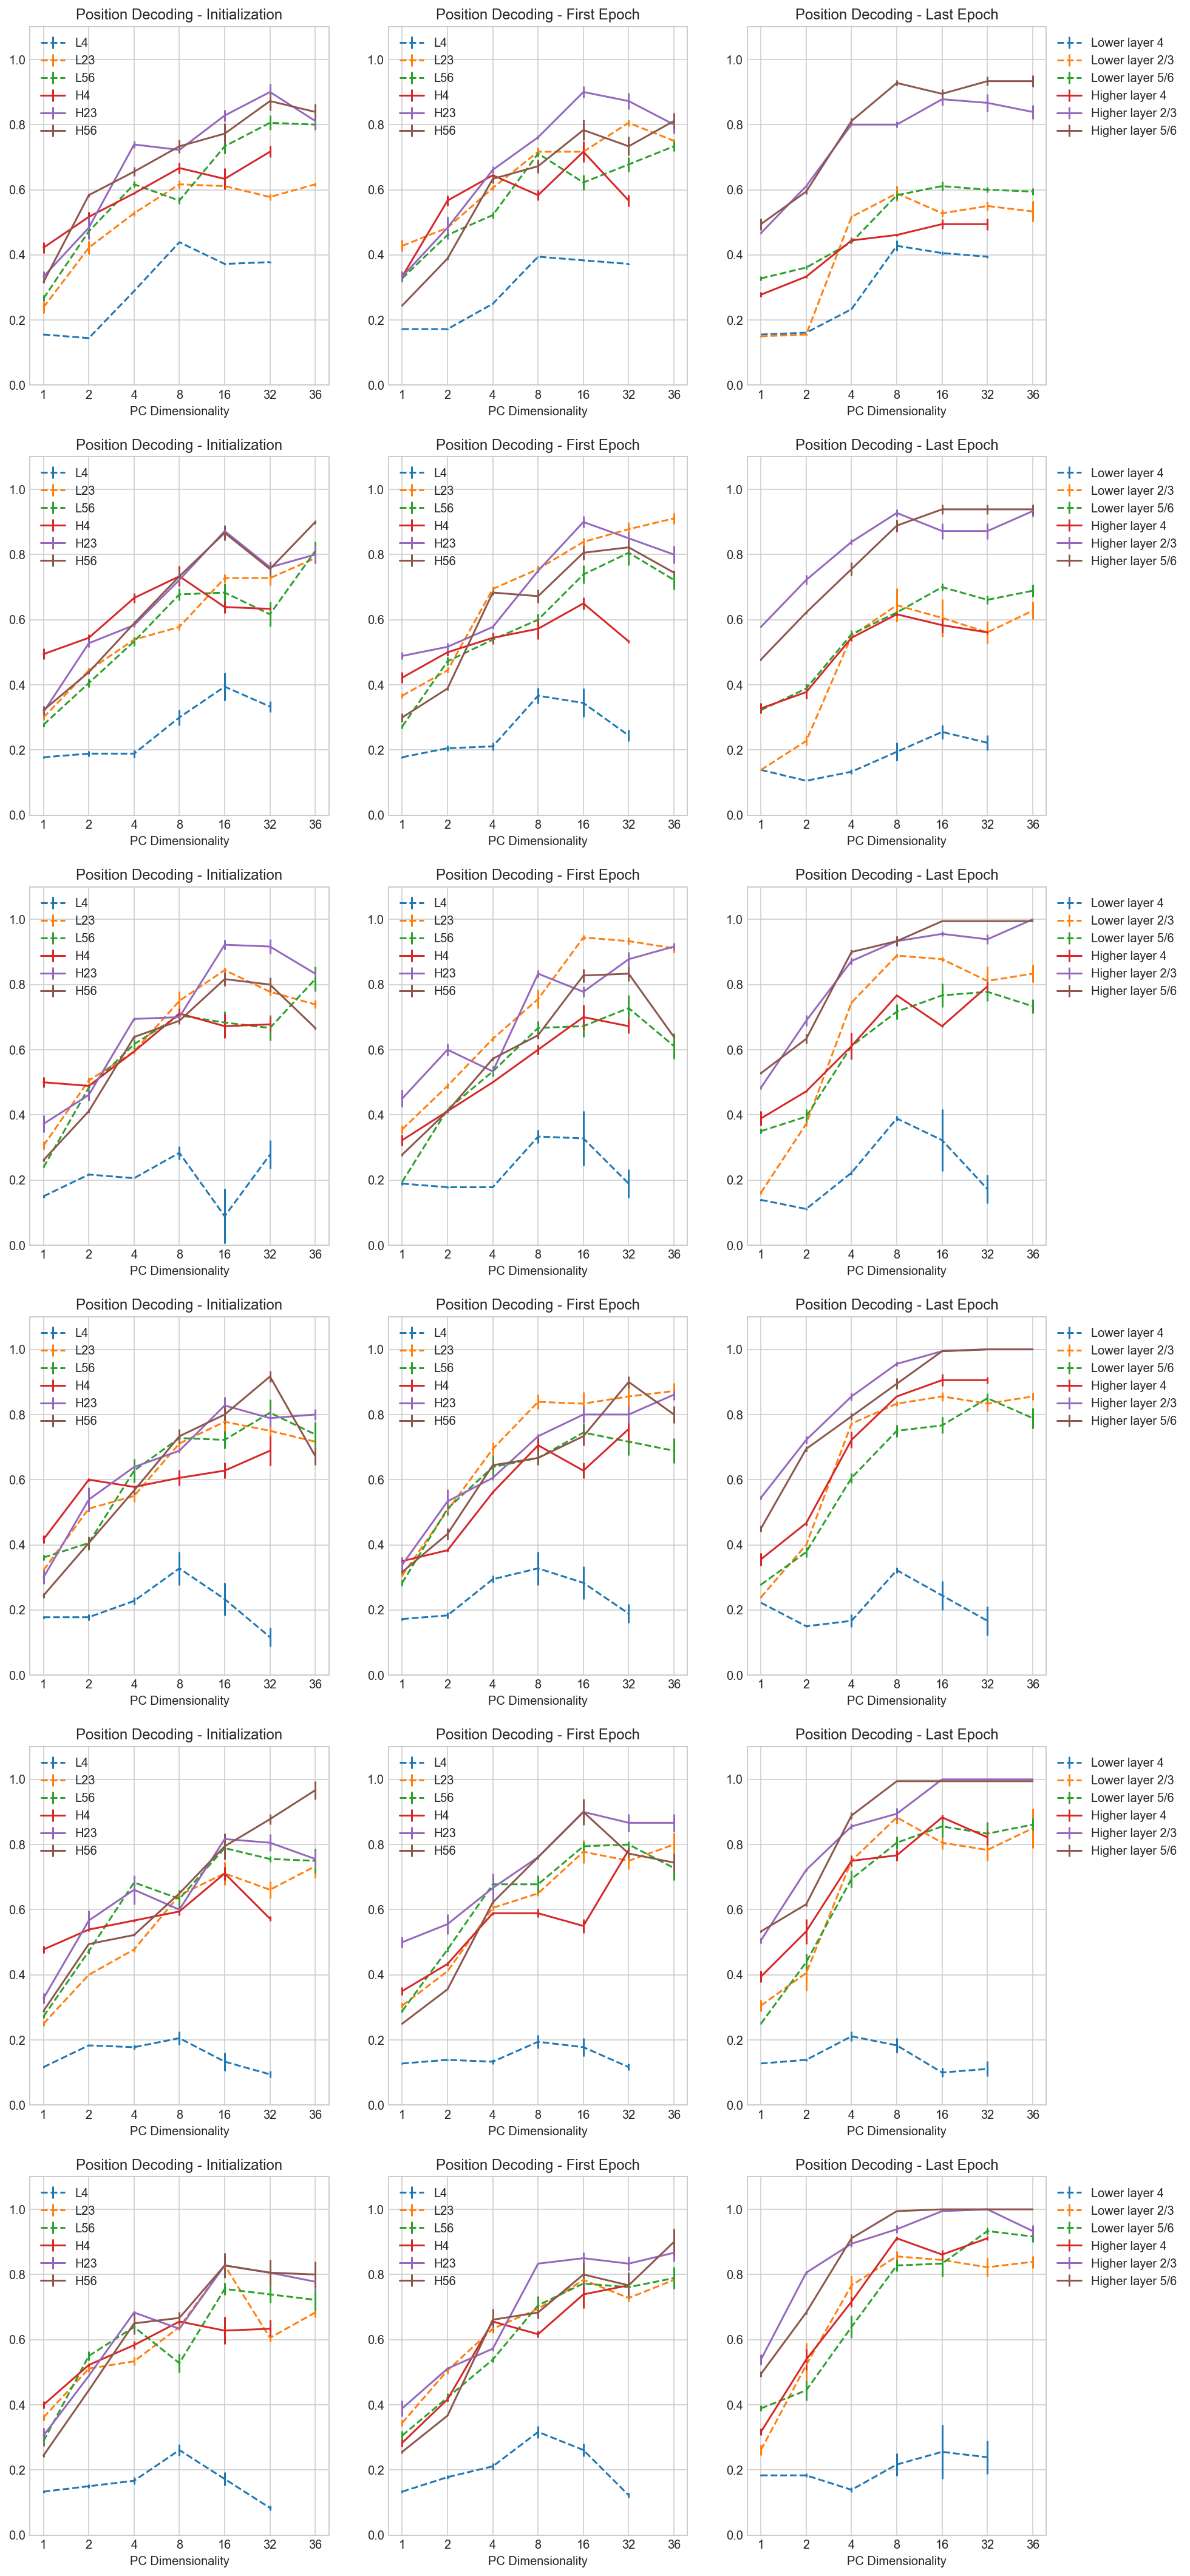

In [405]:
ffpos_noisy = plt.figure(figsize=(15,38))

for nn in range(len(noise_stds)):
    plt.subplot(6,3,3*nn + 1)
    plt.title('Position Decoding - Initialization')
    plt.errorbar(np.arange(len(dims4)),noisy_mean_accs_L4posPC[nn,:,0],
                 yerr=noisy_std_accs_L4posPC[nn,:,1],label='L4',fmt='--')
    plt.errorbar(np.arange(len(dims23)),noisy_mean_accs_L23posPC[nn,:,0],
                 yerr=noisy_std_accs_L23posPC[nn,:,1],label='L23',fmt='--')
    plt.errorbar(np.arange(len(dims56)),noisy_mean_accs_L56posPC[nn,:,0],
                 yerr=noisy_std_accs_L56posPC[nn,:,1],label='L56',fmt='--')
    plt.errorbar(np.arange(len(dims4)),noisy_mean_accs_H4posPC[nn,:,0],
                 yerr=noisy_std_accs_H4posPC[nn,:,1],label='H4',fmt='-')
    plt.errorbar(np.arange(len(dims23)),noisy_mean_accs_H23posPC[nn,:,0],
                 yerr=noisy_std_accs_H23posPC[nn,:,1],label='H23',fmt='-')
    plt.errorbar(np.arange(len(dims56)),noisy_mean_accs_H56posPC[nn,:,0],
                 yerr=noisy_std_accs_H56posPC[nn,:,1],label='H56',fmt='-')
    plt.xlabel('PC Dimensionality')
    plt.ylim(0,1.1)
    plt.xticks(np.arange(len(dims23)),dims23)
    plt.legend()

    plt.subplot(6,3,3*nn + 2)
    plt.title('Position Decoding - First Epoch')
    plt.errorbar(np.arange(len(dims4)),noisy_mean_accs_L4posPC[nn,:,1],
                 yerr=noisy_std_accs_L4posPC[nn,:,1],label='L4',fmt='--')
    plt.errorbar(np.arange(len(dims23)),noisy_mean_accs_L23posPC[nn,:,1],
                 yerr=noisy_std_accs_L23posPC[nn,:,1],label='L23',fmt='--')
    plt.errorbar(np.arange(len(dims56)),noisy_mean_accs_L56posPC[nn,:,1],
                 yerr=noisy_std_accs_L56posPC[nn,:,1],label='L56',fmt='--')
    plt.errorbar(np.arange(len(dims4)),noisy_mean_accs_H4posPC[nn,:,1],
                 yerr=noisy_std_accs_H4posPC[nn,:,1],label='H4',fmt='-')
    plt.errorbar(np.arange(len(dims23)),noisy_mean_accs_H23posPC[nn,:,1],
                 yerr=noisy_std_accs_H23posPC[nn,:,1],label='H23',fmt='-')
    plt.errorbar(np.arange(len(dims56)),noisy_mean_accs_H56posPC[nn,:,1],
                 yerr=noisy_std_accs_H56posPC[nn,:,1],label='H56',fmt='-')
    plt.xlabel('PC Dimensionality')
    plt.ylim(0,1.1)
    plt.xticks(np.arange(len(dims23)),dims23)
    plt.legend()

    plt.subplot(6,3,3*nn + 3)
    plt.title('Position Decoding - Last Epoch')
    plt.errorbar(np.arange(len(dims4)),noisy_mean_accs_L4posPC[nn,:,-1],
                 yerr=noisy_std_accs_L4posPC[nn,:,-1],label='Lower layer 4',fmt='--')
    plt.errorbar(np.arange(len(dims23)),noisy_mean_accs_L23posPC[nn,:,-1],
                 yerr=noisy_std_accs_L23posPC[nn,:,-1],label='Lower layer 2/3',fmt='--')
    plt.errorbar(np.arange(len(dims56)),noisy_mean_accs_L56posPC[nn,:,-1],
                 yerr=noisy_std_accs_L56posPC[nn,:,-1],label='Lower layer 5/6',fmt='--')
    plt.errorbar(np.arange(len(dims4)),noisy_mean_accs_H4posPC[nn,:,-1],
                 yerr=noisy_std_accs_H4posPC[nn,:,-1],label='Higher layer 4',fmt='-')
    plt.errorbar(np.arange(len(dims23)),noisy_mean_accs_H23posPC[nn,:,-1],
                 yerr=noisy_std_accs_H23posPC[nn,:,-1],label='Higher layer 2/3',fmt='-')
    plt.errorbar(np.arange(len(dims56)),noisy_mean_accs_H56posPC[nn,:,-1],
                 yerr=noisy_std_accs_H56posPC[nn,:,-1],label='Higher layer 5/6',fmt='-')
    plt.xlabel('PC Dimensionality')
    plt.ylim(0,1.1)
    plt.xticks(np.arange(len(dims23)),dims23)
    plt.legend(bbox_to_anchor=(1,1))

(0.1, 1.1)

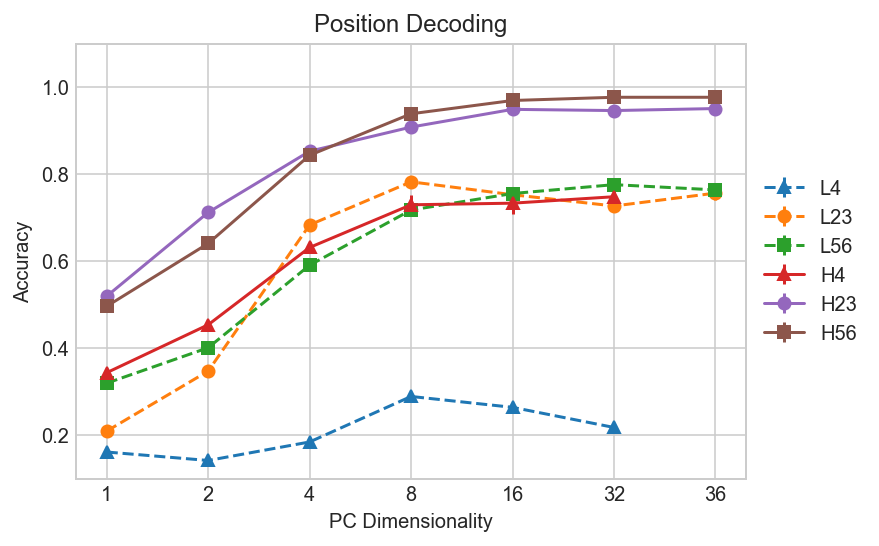

In [406]:
plt.errorbar(np.arange(len(dims4)),
             np.mean(noisy_mean_accs_L4posPC,0)[:,-1],yerr=np.var(noisy_mean_accs_L4posPC,0)[:,-1],
             label='L4',fmt='--^')
plt.errorbar(np.arange(len(dims23)),
             np.mean(noisy_mean_accs_L23posPC,0)[:,-1],yerr=np.var(noisy_mean_accs_L23posPC,0)[:,-1],
             label='L23',fmt='--o')
plt.errorbar(np.arange(len(dims56)),
             np.mean(noisy_mean_accs_L56posPC,0)[:,-1],yerr=np.var(noisy_mean_accs_L56posPC,0)[:,-1],
             label='L56',fmt='--s')
plt.errorbar(np.arange(len(dims4)),
             np.mean(noisy_mean_accs_H4posPC,0)[:,-1],yerr=np.var(noisy_mean_accs_H4posPC,0)[:,-1],
             label='H4',fmt='-^')
plt.errorbar(np.arange(len(dims23)),
             np.mean(noisy_mean_accs_H23posPC,0)[:,-1],yerr=np.var(noisy_mean_accs_H23posPC,0)[:,-1],
             label='H23',fmt='-o')
plt.errorbar(np.arange(len(dims56)),
             np.mean(noisy_mean_accs_H56posPC,0)[:,-1],yerr=np.var(noisy_mean_accs_H56posPC,0)[:,-1],
             label='H56',fmt='-s')
plt.xticks(np.arange(len(dims23)),dims23)
plt.title('Position Decoding')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('Accuracy')
plt.xlabel('PC Dimensionality')
plt.ylim(0.1,1.1)